In [2]:
import sqlite3 as sql

import numpy as np
import pandas as pd
from pandas import cut, read_sql
import pickle as pkl
from random import choices
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.optimize as optimize
from scipy import stats as sci

from standard_plotting import set_size
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.rcParams.update(tex_fonts)

outdir = "/groups/icecube/peter/workspace/analyses/multiclassification_track_cascade_neutrinos/plots/neutrino_selection_and_comparison/"

In [ ]:
indir_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Burnsample_1_percent_all_events_all_variables.csv"
indir_MC_139008_muons_neutrinos_and_noise = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"
indir_MC_130000_muons_and_noise = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Old_muon_more_noise_Monte_Carlo_all_events_all_variables.csv"


In [ ]:
use_130000_muons = True
use_lvl3_cuts = True
Neutrino_cut = 12
track_cut = 0.9
cascade_cut = 0.5
with_MC_truth = True
scale_MC_to_RD_in_comparison_plots = True

use_cols_MC = ['track_mu_pred', 'event_no', 'energy_pred', 'zenith_pred',
       'zenith_kappa', 'azimuth_pred', 'azimuth_kappa', 'pid_noise_pred',
       'pid_muon_pred', 'pid_neutrino_pred', 'pid', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'total_osc_weight',
       'L3_oscNext_bool', 'azimuth', 'zenith', 'energy', 'position_z',
       'position_y', 'position_x', 'track_mu']
use_cols_RD = ['track_mu_pred', 'event_no', 'energy_pred', 'zenith_pred',
       'zenith_kappa', 'azimuth_pred', 'azimuth_kappa', 'pid_noise_pred',
       'pid_muon_pred', 'pid_neutrino_pred', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'total_osc_weight',
       'L3_oscNext_bool']



use_cols_MC_small = ['track_mu_pred', 'event_no', 'pid', 'pid_neutrino_pred_logit',
       'pid_neutrino_pred','total_osc_weight',
       'L3_oscNext_bool', 'track_mu','zenith_pred']
use_cols_RD_small = ['track_mu_pred', 'event_no', 'pid', 'pid_neutrino_pred_logit',
       'pid_neutrino_pred','total_osc_weight',
       'L3_oscNext_bool','zenith_pred']

#use_cols_MC=use_cols_MC_small
#use_cols_RD=use_cols_RD_small

In [ ]:
MC = pd.read_csv(indir_MC_139008_muons_neutrinos_and_noise,usecols=use_cols_MC).sort_values('event_no').reset_index(drop = True)
RD = pd.read_csv(indir_RD,usecols=use_cols_RD).sort_values('event_no').reset_index(drop = True)

if use_130000_muons:
    MC.drop(MC[MC['pid'].isin((-1,1,-13,13))].index, inplace=True)
    MC_130000 = pd.read_csv(indir_MC_130000_muons_and_noise,usecols=use_cols_MC).sort_values('event_no').reset_index(drop = True)
    MC = pd.concat([MC_130000.reset_index(drop=True),MC.reset_index(drop=True)])
    MC.loc[MC['pid'].isin((-1,1,-13,13)), 'event_no'] += 68459218

KeyboardInterrupt: 

In [ ]:
# print(len(MC[MC['pid'].isin((-13,13))]))
# print(len(MC[MC['pid'].isin((-1,1))]))

In [ ]:
print(np.sum(MC['total_osc_weight']))
print(np.sum(RD['total_osc_weight']))

11.430270364546047
15.76526454276436


In [ ]:
if use_lvl3_cuts:
    print(np.shape(MC))
    print(np.shape(RD))
    MC = MC.loc[MC['L3_oscNext_bool'] == 1]
    RD = RD.loc[RD['L3_oscNext_bool'] == 1]
    print(np.shape(MC))
    print(np.shape(RD))

(67541072, 9)
(61739862, 8)
(24767642, 9)
(2227216, 8)


In [ ]:
print(np.sum(MC['total_osc_weight']))
print(np.sum(RD['total_osc_weight']))

0.4665492703475699
0.5687192730342938


[0.00000000e+00 2.32592739e-05 3.29984730e-06 3.43538089e-06
 3.77883271e-06 4.47409082e-06 5.10699701e-06 6.43967821e-06
 7.90348008e-06 9.85332839e-06]
[0.1181614  1.30786356 1.08536236]
True
13786.507712931294
62
0.0


/tmp/ipykernel_10144/133504135.py:51: RuntimeWarning: invalid value encountered in divide
  multiclass_logit_ratio = counts_RD_fit/(counts_noise_plot + counts_muon_plot + counts_neutrino_plot)


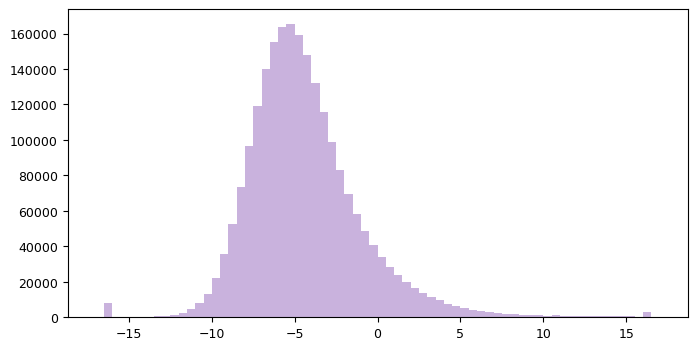

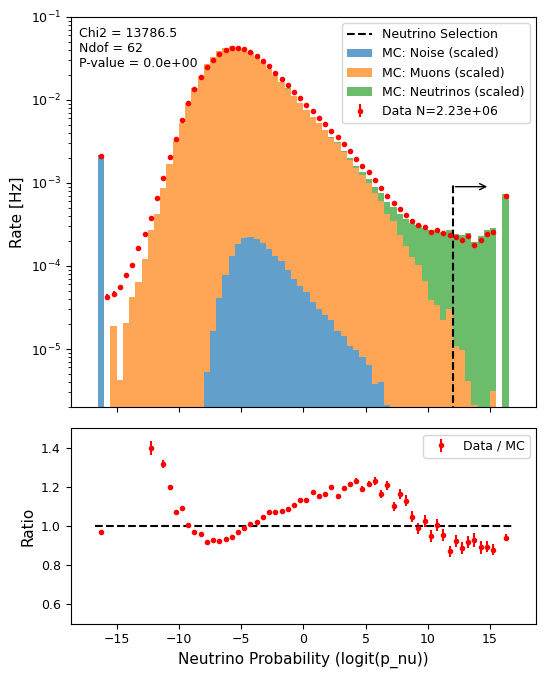

In [ ]:
bins = np.linspace(-17,17,69)
bins_middle = (bins[1:]+bins[:-1])/2
bin_width = bins[1]-bins[0]

fig,axs =  plt.subplots(figsize=(8, 4))
counts_neutrino_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][MC['pid'].isin((-12,12,-14,14,-16,16))])
counts_muon_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][MC['pid'].isin((-13,13))],bins=bins,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][MC['pid'].isin((-13,13))])
counts_noise_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][MC['pid'].isin((-1,1))],bins=bins,density=False,alpha=0.5,label='MC Noise',weights=MC['total_osc_weight'][MC['pid'].isin((-1,1))])
counts_RD_fit, _,_ = axs.hist(RD['pid_neutrino_pred_logit'],bins=bins,density=False,alpha=0.5,label='RD',weights=RD['total_osc_weight'])
counts_RD_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred_logit'],bins=bins,density=False,alpha=0.5,label='RD')




multiclass_uncertainty_RD_fit = np.zeros_like(counts_RD_not_rate)
for i in range(len(multiclass_uncertainty_RD_fit)):
    if counts_RD_not_rate[i]!= 0 :
        multiclass_uncertainty_RD_fit[i] = (1/np.sqrt(counts_RD_not_rate[i])) * counts_RD_fit[i]

print(multiclass_uncertainty_RD_fit[:10])

def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins)-1):
        if counts_RD_fit[i] != 0:
            sum+= (counts_RD_fit[i] - N_scalers[0]*counts_noise_fit[i] - N_scalers[1]*counts_muon_fit[i] - N_scalers[2]*counts_neutrino_fit[i])**2/multiclass_uncertainty_RD_fit[i]**2
    return sum

N_0 = [1,1,1]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

counts_noise_plot = counts_noise_fit*res.x[0]#
counts_muon_plot = counts_muon_fit*res.x[1]##
counts_neutrino_plot = counts_neutrino_fit*res.x[2]#*#


RD_uncertainties_on_count = np.sqrt(counts_RD_not_rate)
RD_percent_uncertainty_on_count = np.zeros_like(RD_uncertainties_on_count)
RD_uncertainties_on_rate = np.zeros_like(RD_uncertainties_on_count)

for i in range(len(RD_uncertainties_on_count)):
    if RD_uncertainties_on_count[i] == 0:
        RD_uncertainties_on_rate[i] = 0
        RD_percent_uncertainty_on_count[i] = 0
    else:
        RD_percent_uncertainty_on_count[i] = RD_uncertainties_on_count[i]/counts_RD_not_rate[i]
        RD_uncertainties_on_rate[i] = counts_RD_fit[i]*RD_percent_uncertainty_on_count[i]

multiclass_logit_ratio = counts_RD_fit/(counts_noise_plot + counts_muon_plot + counts_neutrino_plot)
multiclass_logit_ratio_uncertainties = multiclass_logit_ratio*RD_percent_uncertainty_on_count

multiclass_logit_residual = counts_RD_fit - (counts_noise_plot + counts_muon_plot + counts_neutrino_plot)
multiclass_logit_chi_2 = 0
for i in range(len(multiclass_logit_residual)):
    if RD_uncertainties_on_rate[i] !=0:
        multiclass_logit_chi_2 += (multiclass_logit_residual[i]/RD_uncertainties_on_rate[i])**2
print(multiclass_logit_chi_2)
multiclass_logit_ndof = np.sum([RD_uncertainties_on_rate!=0]) - 3
print(multiclass_logit_ndof)
multiclass_logit_p_value = sci.chi2.sf(multiclass_logit_chi_2,multiclass_logit_ndof)
print(multiclass_logit_p_value)

figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])



axs[0].bar(bins_middle,counts_noise_plot,width=bin_width,label='MC: Noise (scaled)',alpha=0.7)
axs[0].bar(bins_middle,counts_muon_plot,width=bin_width,bottom=counts_noise_plot,label='MC: Muons (scaled)',alpha=0.7)
axs[0].bar(bins_middle,counts_neutrino_plot,width=bin_width,bottom=counts_noise_plot+counts_muon_plot,label='MC: Neutrinos (scaled)',alpha=0.7)
axs[0].errorbar(x=bins_middle,y=counts_RD_fit,yerr=RD_uncertainties_on_rate,fmt='.',label='Data N={:.2e}'.format(int(np.sum(counts_RD_not_rate))),color='red')
axs[0].vlines(Neutrino_cut,0,10**(-3),color='black',label='Neutrino Selection',linestyles='dashed')

axs[0].set_ylabel('Rate [Hz]')
axs[0].set_yscale('log')
axs[0].set_ylim(top=0.1,bottom=2*10**(-6))
#axs[0].set_xlim(-17,17)
axs[0].legend(loc='upper right')
axs[0].annotate("", xy=(Neutrino_cut+3, 0.9*10**(-3)), xytext=(Neutrino_cut, 0.9*10**(-3)),
            arrowprops=dict(arrowstyle="->"))
axs[0].text(-18, 0.025, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.1e}'.format(multiclass_logit_chi_2,multiclass_logit_ndof,multiclass_logit_p_value),fontsize=9)
axs[1].set_xlabel('Neutrino Probability (logit(p_nu))')
axs[1].set_ylabel('Ratio')
axs[1].errorbar(bins_middle,multiclass_logit_ratio,yerr=multiclass_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(bins_middle),np.max(bins_middle),color='k',linestyles='dashed')
axs[1].legend()
axs[1].set_ylim(0.5,1.5)

fig.tight_layout()
fig.savefig(outdir + 'multiclass_neutrino_prob.png',bbox_inches='tight',dpi=400)

[     0.   8297.    167.    181.    219.    307.    400.    636.    958.
   1489.   2606.   4498.   7915.  13353.  22349.  35565.  52509.  73221.
  96384. 119006. 139775. 155093. 163677. 165406. 158893. 148018. 132311.
 115913.  98883.  83066.  69427.  58414.  48371.  40632.  33817.]
[ 0.         91.08786966 12.92284798 13.45362405 14.79864859 17.52141547
 20.         25.21904043 30.95157508 38.58756276]
[0.         0.01097841 0.07738232 0.07432941 0.06757374 0.05707301
 0.05       0.03965258 0.03230853 0.02591509]
[0.00000000e+00 2.32592739e-05 3.29984730e-06 3.43538089e-06
 3.77883271e-06 4.47409082e-06 5.10699701e-06 6.43967821e-06
 7.90348008e-06 9.85332839e-06]
597599.5235352684
597599.5235352684
0.0


/tmp/ipykernel_10144/2300861548.py:24: RuntimeWarning: invalid value encountered in divide
  multiclass_logit_ratio = counts_RD_fit/(counts_noise_fit + counts_muon_fit + counts_neutrino_fit)


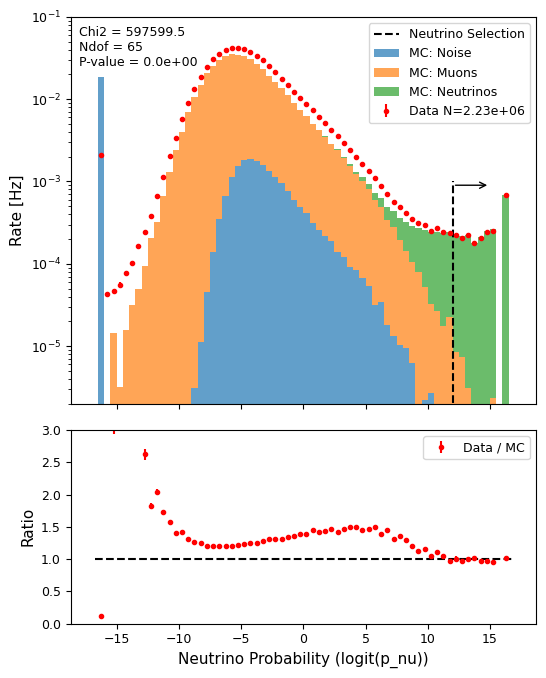

In [ ]:

bins_to_use = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_to_fit = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2



print(counts_RD_not_rate[:35])
RD_uncertainties_on_count = np.sqrt(counts_RD_not_rate)
print(RD_uncertainties_on_count[:10])
RD_percent_uncertainty_on_count = np.zeros_like(RD_uncertainties_on_count)
RD_uncertainties_on_rate = np.zeros_like(RD_uncertainties_on_count)

for i in range(len(RD_uncertainties_on_count)):
    if RD_uncertainties_on_count[i] == 0:
        RD_uncertainties_on_rate[i] = 0
        RD_percent_uncertainty_on_count[i] = 0
    else:
        RD_percent_uncertainty_on_count[i] = RD_uncertainties_on_count[i]/counts_RD_not_rate[i]
        RD_uncertainties_on_rate[i] = counts_RD_fit[i]*RD_percent_uncertainty_on_count[i]

print(RD_percent_uncertainty_on_count[:10])
print(RD_uncertainties_on_rate[:10])

multiclass_logit_ratio = counts_RD_fit/(counts_noise_fit + counts_muon_fit + counts_neutrino_fit)
multiclass_logit_ratio_uncertainties = multiclass_logit_ratio*RD_percent_uncertainty_on_count

multiclass_logit_residual = counts_RD_fit - (counts_noise_fit + counts_muon_fit + counts_neutrino_fit)
multiclass_logit_chi_2 = 0
for i in range(len(multiclass_logit_residual)):
    if RD_uncertainties_on_rate[i] !=0:
        multiclass_logit_chi_2 += (multiclass_logit_residual[i]/RD_uncertainties_on_rate[i])**2
print(multiclass_logit_chi_2)
multiclass_logit_ndof = len(bins_middle) - 3
print(multiclass_logit_chi_2)
multiclass_logit_p_value = sci.chi2.sf(multiclass_logit_chi_2,multiclass_logit_ndof)
print(multiclass_logit_p_value)

figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])
bins_to_use = np.linspace(-17,17,69)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2
bin_width = bins_to_use[1]-bins_to_use[0]

axs[0].bar(bins_middle,counts_noise_fit,width=bin_width,label='MC: Noise',alpha=0.7)
axs[0].bar(bins_middle,counts_muon_fit,width=bin_width,bottom=counts_noise_fit,label='MC: Muons',alpha=0.7)
axs[0].bar(bins_middle,counts_neutrino_fit,width=bin_width,bottom=counts_noise_fit+counts_muon_fit,label='MC: Neutrinos',alpha=0.7)
axs[0].errorbar(x=bins_middle,y=counts_RD_fit,yerr=RD_uncertainties_on_rate,fmt='.',label='Data N={:.2e}'.format(int(np.sum(counts_RD_not_rate))),color='red')
axs[0].vlines(Neutrino_cut,0,10**(-3),color='black',label='Neutrino Selection',linestyles='dashed')

axs[0].set_ylabel('Rate [Hz]')
axs[0].set_yscale('log')
axs[0].set_ylim(top=0.1,bottom=2*10**(-6))
#axs[0].set_xlim(-17,17)
axs[0].legend(loc='upper right')
axs[0].annotate("", xy=(Neutrino_cut+3, 0.9*10**(-3)), xytext=(Neutrino_cut, 0.9*10**(-3)),
            arrowprops=dict(arrowstyle="->"))
axs[0].text(-18, 0.025, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.1e}'.format(multiclass_logit_chi_2,multiclass_logit_ndof,multiclass_logit_p_value),fontsize=9)
axs[1].set_xlabel('Neutrino Probability (logit(p_nu))')
axs[1].set_ylabel('Ratio')
axs[1].errorbar(bins_middle,multiclass_logit_ratio,yerr=multiclass_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(bins_middle),np.max(bins_middle),color='k',linestyles='dashed')
axs[1].legend()
axs[1].set_ylim(top=3,bottom=0)
fig.tight_layout()
fig.savefig(outdir + 'multiclass_neutrino_prob_no_scaling.png',bbox_inches='tight',dpi=400)

[2.78945841e-04 1.16278427e-04 8.40861281e-05 6.79384179e-05
 5.77096312e-05 5.06166271e-05 4.55940727e-05 4.12514503e-05
 3.80890917e-05 3.55285160e-05]
[0.         1.31815682 1.29284547]
True
[1193352.  207361.  108437.   70788.   51077.   39293.   31882.   26098.
   22250.   19359.   17116.   15306.   13731.   12308.   11201.   10354.
    9584.    8945.    8407.    7844.    7352.    6991.    6650.    6299.
    6084.    5915.    5561.    5342.    5112.    4908.    4614.    4511.
    4376.    4146.    4140.]
[1092.40651774  455.36908108  329.29773762  266.06014358  226.00221238
  198.22462007  178.55531356  161.54875425  149.1643389   139.1366235 ]
[0.00091541 0.00219602 0.00303677 0.00375855 0.00442474 0.00504478
 0.00560051 0.00619008 0.00670402 0.00718718]
[2.78945841e-04 1.16278427e-04 8.40861281e-05 6.79384179e-05
 5.77096312e-05 5.06166271e-05 4.55940727e-05 4.12514503e-05
 3.80890917e-05 3.55285160e-05]
9274.911956400587
97
0.0


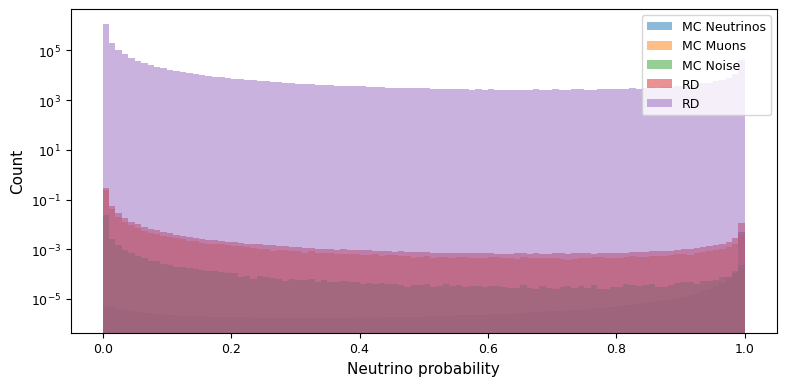

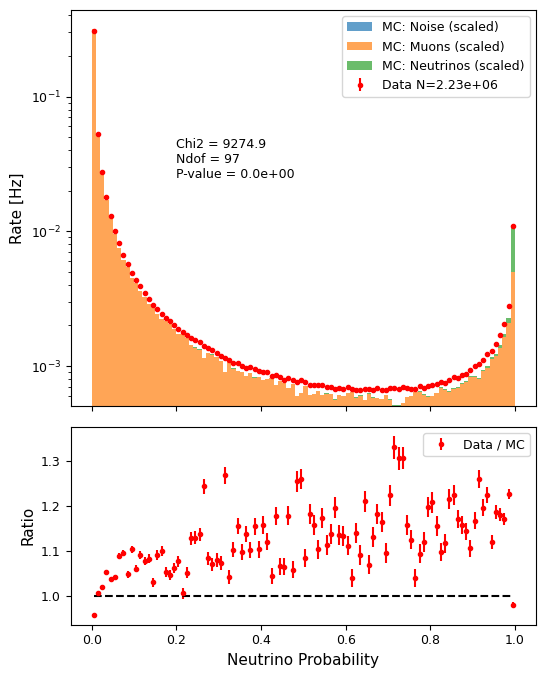

In [ ]:
bins = np.linspace(0,1,101)#np.linspace(-17,17,101)

bins_middle = (bins[1:]+bins[:-1])/2


fig,axs =  plt.subplots(figsize=(8, 4))
not_logit_counts_neutrino_fit, _,_ = axs.hist(MC['pid_neutrino_pred'][(MC['pid'].isin((-12,12,-14,14,-16,16))) ],bins=bins,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][(MC['pid'].isin((-12,12,-14,14,-16,16))) ])
not_logit_counts_muon_fit, _,_ = axs.hist(MC['pid_neutrino_pred'][(MC['pid'].isin((-13,13))) ],bins=bins,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][(MC['pid'].isin((-13,13))) ])
not_logit_counts_noise_fit, _,_ = axs.hist(MC['pid_neutrino_pred'][(MC['pid'].isin((-1,1))) ],bins=bins,density=False,alpha=0.5,label='MC Noise',weights = MC['total_osc_weight'][(MC['pid'].isin((-1,1))) ])
not_logit_counts_RD_fit, _,_ = axs.hist(RD['pid_neutrino_pred'],bins=bins,density=False,alpha=0.5,label='RD',weights=RD['total_osc_weight'])
not_logit_counts_RD_fit_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred'],bins=bins,density=False,alpha=0.5,label='RD')





axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig.tight_layout()

not_logit_multiclass_uncertainty_RD_fit = np.zeros_like(not_logit_counts_RD_fit_not_rate)
for i in range(len(not_logit_multiclass_uncertainty_RD_fit)):
    if not_logit_counts_RD_fit_not_rate[i]!= 0 :
        not_logit_multiclass_uncertainty_RD_fit[i] = (1/np.sqrt(not_logit_counts_RD_fit_not_rate[i])) * not_logit_counts_RD_fit[i]

print(not_logit_multiclass_uncertainty_RD_fit[:10])

def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins)-1):
        if not_logit_counts_RD_fit[i] != 0:
            sum+= (not_logit_counts_RD_fit[i] - N_scalers[0]*not_logit_counts_noise_fit[i] - N_scalers[1]*not_logit_counts_muon_fit[i] - N_scalers[2]*not_logit_counts_neutrino_fit[i])**2/not_logit_multiclass_uncertainty_RD_fit[i]**2
    return sum

N_0 = [ 0.2, 1,  1]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

not_logit_counts_noise_plot = not_logit_counts_noise_fit*res.x[0]#
not_logit_counts_muon_plot = not_logit_counts_muon_fit*res.x[1]##
not_logit_counts_neutrino_plot = not_logit_counts_neutrino_fit*res.x[2]#*#



bin_width = bins[1]-bins[0]


bins = np.linspace(0,1,101)#np.linspace(-17,17,101)
bins = np.linspace(0,1,101)#np.linspace(-17,17,101)
bins_middle = (bins[1:]+bins[:-1])/2



print(not_logit_counts_RD_fit_not_rate[:35])
not_logit_RD_uncertainties_on_count = np.sqrt(not_logit_counts_RD_fit_not_rate)
print(not_logit_RD_uncertainties_on_count[:10])
not_logit_RD_percent_uncertainty_on_count = np.zeros_like(not_logit_RD_uncertainties_on_count)
not_logit_RD_uncertainties_on_rate = np.zeros_like(not_logit_RD_uncertainties_on_count)

for i in range(len(not_logit_RD_uncertainties_on_count)):
    if not_logit_RD_uncertainties_on_count[i] == 0:
        not_logit_RD_uncertainties_on_rate[i] = 0
        not_logit_RD_percent_uncertainty_on_count[i] = 0
    else:
        not_logit_RD_percent_uncertainty_on_count[i] = not_logit_RD_uncertainties_on_count[i]/not_logit_counts_RD_fit_not_rate[i]
        not_logit_RD_uncertainties_on_rate[i] = not_logit_counts_RD_fit[i]*not_logit_RD_percent_uncertainty_on_count[i]

print(not_logit_RD_percent_uncertainty_on_count[:10])
print(not_logit_RD_uncertainties_on_rate[:10])

not_logit_multiclass_logit_ratio = not_logit_counts_RD_fit/(not_logit_counts_noise_plot + not_logit_counts_muon_plot + not_logit_counts_neutrino_plot)
not_logit_multiclass_logit_ratio_uncertainties = not_logit_multiclass_logit_ratio*not_logit_RD_percent_uncertainty_on_count

not_logit_multiclass_logit_residual = not_logit_counts_RD_fit - (not_logit_counts_noise_plot + not_logit_counts_muon_plot + not_logit_counts_neutrino_plot)
not_logit_multiclass_logit_chi_2 = 0
for i in range(len(not_logit_multiclass_logit_residual)):
    if not_logit_RD_uncertainties_on_rate[i] !=0:
        not_logit_multiclass_logit_chi_2 += (not_logit_multiclass_logit_residual[i]/not_logit_RD_uncertainties_on_rate[i])**2
print(not_logit_multiclass_logit_chi_2)
not_logit_multiclass_logit_ndof = np.sum(not_logit_RD_uncertainties_on_rate!=0) - 3
print(not_logit_multiclass_logit_ndof)
not_logit_multiclass_logit_p_value = sci.chi2.sf(not_logit_multiclass_logit_chi_2,not_logit_multiclass_logit_ndof)
print(not_logit_multiclass_logit_p_value)

figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])
bins = np.linspace(0,1,101)
bins_middle = (bins[1:]+bins[:-1])/2
bin_width = bins[1]-bins[0]

axs[0].bar(bins_middle,not_logit_counts_noise_plot,width=bin_width,label='MC: Noise (scaled)',alpha=0.7)
axs[0].bar(bins_middle,not_logit_counts_muon_plot,width=bin_width,bottom=not_logit_counts_noise_plot,label='MC: Muons (scaled)',alpha=0.7)
axs[0].bar(bins_middle,not_logit_counts_neutrino_plot,width=bin_width,bottom=not_logit_counts_noise_plot+not_logit_counts_muon_plot,label='MC: Neutrinos (scaled)',alpha=0.7)
axs[0].errorbar(x=bins_middle,y=not_logit_counts_RD_fit,yerr=not_logit_RD_uncertainties_on_rate,fmt='.',label='Data N={:.2e}'.format(int(np.sum(not_logit_counts_RD_fit_not_rate))),color='red')
#axs[0].vlines(Neutrino_cut,0,10**(-3),color='black',label='Neutrino Selection',linestyles='dashed')

axs[0].set_ylabel('Rate [Hz]')
axs[0].set_yscale('log')
#axs[0].set_ylim(top=0.1,bottom=2*10**(-6))
#axs[0].set_xlim(-17,17)
axs[0].legend(loc='upper right')
#axs[0].annotate("", xy=(Neutrino_cut+3, 0.9*10**(-3)), xytext=(Neutrino_cut, 0.9*10**(-3)),
#            arrowprops=dict(arrowstyle="->"))
axs[0].text(0.2, 0.025, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.1e}'.format(not_logit_multiclass_logit_chi_2,not_logit_multiclass_logit_ndof,not_logit_multiclass_logit_p_value),fontsize=9)
axs[1].set_xlabel('Neutrino Probability')
axs[1].set_ylabel('Ratio')
axs[1].errorbar(bins_middle,not_logit_multiclass_logit_ratio,yerr=not_logit_multiclass_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(bins_middle),np.max(bins_middle),color='k',linestyles='dashed')
axs[1].legend()

fig.tight_layout()
fig.savefig(outdir + 'multiclass_neutrino_prob_not_logit.png',bbox_inches='tight',dpi=400)

[2.78945841e-04 1.16278427e-04 8.40861281e-05 6.79384179e-05
 5.77096312e-05 5.06166271e-05 4.55940727e-05 4.12514503e-05
 3.80890917e-05 3.55285160e-05]
[0.2        1.30062238 1.29734435]
True
[1193352.  207361.  108437.   70788.   51077.   39293.   31882.   26098.
   22250.   19359.   17116.   15306.   13731.   12308.   11201.   10354.
    9584.    8945.    8407.    7844.    7352.    6991.    6650.    6299.
    6084.    5915.    5561.    5342.    5112.    4908.    4614.    4511.
    4376.    4146.    4140.]
[1092.40651774  455.36908108  329.29773762  266.06014358  226.00221238
  198.22462007  178.55531356  161.54875425  149.1643389   139.1366235 ]
[0.00091541 0.00219602 0.00303677 0.00375855 0.00442474 0.00504478
 0.00560051 0.00619008 0.00670402 0.00718718]
[2.78945841e-04 1.16278427e-04 8.40861281e-05 6.79384179e-05
 5.77096312e-05 5.06166271e-05 4.55940727e-05 4.12514503e-05
 3.80890917e-05 3.55285160e-05]
80305.2304449291
97
0.0


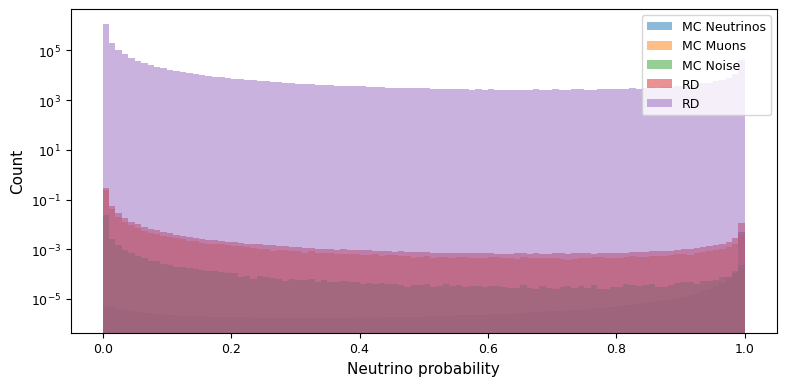

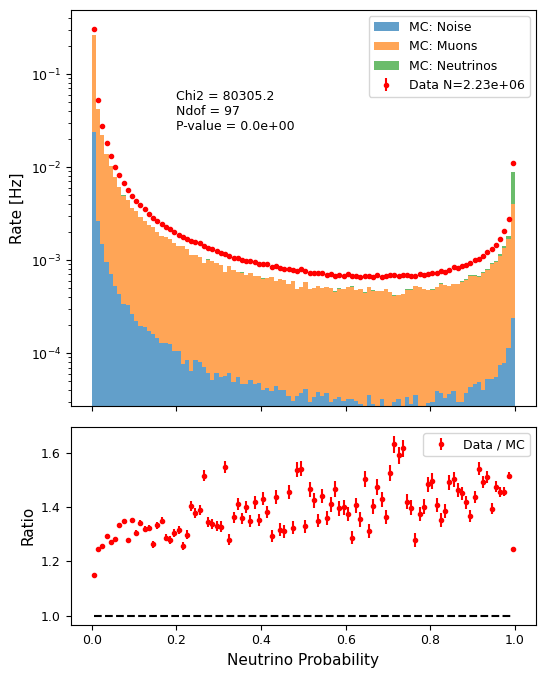

In [ ]:
bins = np.linspace(0,1,101)#np.linspace(-17,17,101)

bins_middle = (bins[1:]+bins[:-1])/2


fig,axs =  plt.subplots(figsize=(8, 4))
not_logit_counts_neutrino_fit, _,_ = axs.hist(MC['pid_neutrino_pred'][(MC['pid'].isin((-12,12,-14,14,-16,16))) ],bins=bins,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][(MC['pid'].isin((-12,12,-14,14,-16,16))) ])
not_logit_counts_muon_fit, _,_ = axs.hist(MC['pid_neutrino_pred'][(MC['pid'].isin((-13,13))) ],bins=bins,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][(MC['pid'].isin((-13,13))) ])
not_logit_counts_noise_fit, _,_ = axs.hist(MC['pid_neutrino_pred'][(MC['pid'].isin((-1,1))) ],bins=bins,density=False,alpha=0.5,label='MC Noise',weights = MC['total_osc_weight'][(MC['pid'].isin((-1,1))) ])
not_logit_counts_RD_fit, _,_ = axs.hist(RD['pid_neutrino_pred'],bins=bins,density=False,alpha=0.5,label='RD',weights=RD['total_osc_weight'])
not_logit_counts_RD_fit_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred'],bins=bins,density=False,alpha=0.5,label='RD')





axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig.tight_layout()

not_logit_multiclass_uncertainty_RD_fit = np.zeros_like(not_logit_counts_RD_fit_not_rate)
for i in range(len(not_logit_multiclass_uncertainty_RD_fit)):
    if not_logit_counts_RD_fit_not_rate[i]!= 0 :
        not_logit_multiclass_uncertainty_RD_fit[i] = (1/np.sqrt(not_logit_counts_RD_fit_not_rate[i])) * not_logit_counts_RD_fit[i]

print(not_logit_multiclass_uncertainty_RD_fit[:10])

def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins)-1):
        if not_logit_counts_RD_fit[i] != 0:
            sum+= (not_logit_counts_RD_fit[i] - N_scalers[0]*not_logit_counts_noise_fit[i] - N_scalers[1]*not_logit_counts_muon_fit[i] - N_scalers[2]*not_logit_counts_neutrino_fit[i])**2/not_logit_multiclass_uncertainty_RD_fit[i]**2
    return sum

N_0 = [ 0.2, 1,  1]
res = optimize.minimize(chi_square,N_0,bounds = ((0.2, None),(0, None), (0, None)))
print(res.x)
print(res.success)

not_logit_counts_noise_plot = not_logit_counts_noise_fit#*res.x[0]#
not_logit_counts_muon_plot = not_logit_counts_muon_fit#*res.x[1]##
not_logit_counts_neutrino_plot = not_logit_counts_neutrino_fit#*res.x[2]#*#



bin_width = bins[1]-bins[0]


bins = np.linspace(0,1,101)#np.linspace(-17,17,101)
bins = np.linspace(0,1,101)#np.linspace(-17,17,101)
bins_middle = (bins[1:]+bins[:-1])/2



print(not_logit_counts_RD_fit_not_rate[:35])
not_logit_RD_uncertainties_on_count = np.sqrt(not_logit_counts_RD_fit_not_rate)
print(not_logit_RD_uncertainties_on_count[:10])
not_logit_RD_percent_uncertainty_on_count = np.zeros_like(not_logit_RD_uncertainties_on_count)
not_logit_RD_uncertainties_on_rate = np.zeros_like(not_logit_RD_uncertainties_on_count)

for i in range(len(not_logit_RD_uncertainties_on_count)):
    if not_logit_RD_uncertainties_on_count[i] == 0:
        not_logit_RD_uncertainties_on_rate[i] = 0
        not_logit_RD_percent_uncertainty_on_count[i] = 0
    else:
        not_logit_RD_percent_uncertainty_on_count[i] = not_logit_RD_uncertainties_on_count[i]/not_logit_counts_RD_fit_not_rate[i]
        not_logit_RD_uncertainties_on_rate[i] = not_logit_counts_RD_fit[i]*not_logit_RD_percent_uncertainty_on_count[i]

print(not_logit_RD_percent_uncertainty_on_count[:10])
print(not_logit_RD_uncertainties_on_rate[:10])

not_logit_multiclass_logit_ratio = not_logit_counts_RD_fit/(not_logit_counts_noise_plot + not_logit_counts_muon_plot + not_logit_counts_neutrino_plot)
not_logit_multiclass_logit_ratio_uncertainties = not_logit_multiclass_logit_ratio*not_logit_RD_percent_uncertainty_on_count

not_logit_multiclass_logit_residual = not_logit_counts_RD_fit - (not_logit_counts_noise_plot + not_logit_counts_muon_plot + not_logit_counts_neutrino_plot)
not_logit_multiclass_logit_chi_2 = 0
for i in range(len(not_logit_multiclass_logit_residual)):
    if not_logit_RD_uncertainties_on_rate[i] !=0:
        not_logit_multiclass_logit_chi_2 += (not_logit_multiclass_logit_residual[i]/not_logit_RD_uncertainties_on_rate[i])**2
print(not_logit_multiclass_logit_chi_2)
not_logit_multiclass_logit_ndof = np.sum(not_logit_RD_uncertainties_on_rate!=0) - 3
print(not_logit_multiclass_logit_ndof)
not_logit_multiclass_logit_p_value = sci.chi2.sf(not_logit_multiclass_logit_chi_2,not_logit_multiclass_logit_ndof)
print(not_logit_multiclass_logit_p_value)

figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])
bins = np.linspace(0,1,101)
bins_middle = (bins[1:]+bins[:-1])/2
bin_width = bins[1]-bins[0]

axs[0].bar(bins_middle,not_logit_counts_noise_plot,width=bin_width,label='MC: Noise',alpha=0.7)
axs[0].bar(bins_middle,not_logit_counts_muon_plot,width=bin_width,bottom=not_logit_counts_noise_plot,label='MC: Muons',alpha=0.7)
axs[0].bar(bins_middle,not_logit_counts_neutrino_plot,width=bin_width,bottom=not_logit_counts_noise_plot+not_logit_counts_muon_plot,label='MC: Neutrinos',alpha=0.7)
axs[0].errorbar(x=bins_middle,y=not_logit_counts_RD_fit,yerr=not_logit_RD_uncertainties_on_rate,fmt='.',label='Data N={:.2e}'.format(int(np.sum(not_logit_counts_RD_fit_not_rate))),color='red')
#axs[0].vlines(Neutrino_cut,0,10**(-3),color='black',label='Neutrino Selection',linestyles='dashed')

axs[0].set_ylabel('Rate [Hz]')
axs[0].set_yscale('log')
#axs[0].set_ylim(top=0.1,bottom=2*10**(-6))
#axs[0].set_xlim(-17,17)
axs[0].legend(loc='upper right')
#axs[0].annotate("", xy=(Neutrino_cut+3, 0.9*10**(-3)), xytext=(Neutrino_cut, 0.9*10**(-3)),
#            arrowprops=dict(arrowstyle="->"))
axs[0].text(0.2, 0.025, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.1e}'.format(not_logit_multiclass_logit_chi_2,not_logit_multiclass_logit_ndof,not_logit_multiclass_logit_p_value),fontsize=9)
axs[1].set_xlabel('Neutrino Probability')
axs[1].set_ylabel('Ratio')
axs[1].errorbar(bins_middle,not_logit_multiclass_logit_ratio,yerr=not_logit_multiclass_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(bins_middle),np.max(bins_middle),color='k',linestyles='dashed')
axs[1].legend()

fig.tight_layout()
fig.savefig(outdir + 'multiclass_neutrino_prob_not_logit_unscaled.png',bbox_inches='tight',dpi=400)

In [ ]:
pure_neutrino_selection_RD = RD['event_no'][RD['pid_neutrino_pred_logit'] > Neutrino_cut]
pure_neutrino_selection_MC = MC['event_no'][MC['pid_neutrino_pred_logit'] > Neutrino_cut]

pure_neutrino_selection_MC_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit'] > Neutrino_cut) & (~MC['pid'].isin((-13,13)))]
pure_neutrino_selection_MC_muons = MC['event_no'][(MC['pid_neutrino_pred_logit'] > Neutrino_cut) & (MC['pid'].isin((-13,13)))]

print('this is the rate of muons surviving in MC',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_neutrino_selection_MC_muons.to_list())]))
print('this is the rate of neutrinos surviving in MC',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_neutrino_selection_MC_neutrinos.to_list())]))
print('this is the total rate of particles surviving in MC',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_neutrino_selection_MC.to_list())]),'with this many events:',len(pure_neutrino_selection_MC))
print('this is the total rate of particles surviving in RD',np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_neutrino_selection_RD.to_list())]),'with this many events:',len(pure_neutrino_selection_RD))

print(np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_neutrino_selection_RD.to_list())])/np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_neutrino_selection_MC.to_list())]))

this is the rate of muons surviving in MC 2.601973584428542e-05
this is the rate of neutrinos surviving in MC 0.002224562395705728
this is the total rate of particles surviving in MC 0.002250582131550016 with this many events: 9609948
this is the total rate of particles surviving in RD 0.002235077243010643 with this many events: 8753
0.9931107208566102


In [ ]:
track_event_no = MC['event_no'][MC['track_mu']==1]
cascade_event_no = MC['event_no'][MC['track_mu']==0]
pure_neutrino_track_selection = track_event_no[track_event_no.isin((pure_neutrino_selection_MC_neutrinos))].reset_index(drop=True)
pure_neutrino_cascade_selection = cascade_event_no[cascade_event_no.isin((pure_neutrino_selection_MC_neutrinos))].reset_index(drop=True)
sneaky_muons_selection = MC['event_no'][(MC['pid_neutrino_pred_logit']>12)&(MC['pid'].isin((-13,13)))]

In [ ]:
# bins = np.linspace(0,1,101)
# bins_middle = (bins[1:]+bins[:-1])/2
# bin_width = bins[1]-bins[0]

# fig, axs = plt.subplots(figsize=(8, 5))

# counts_track_fit, _,_ = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(pure_neutrino_track_selection)],density=False,bins=bins,label='track neutrinos MC',alpha=0.5,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_neutrino_track_selection)])
# counts_cascade_fit, _,_ = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(pure_neutrino_cascade_selection)],density=False,bins=bins,label='cascade neutrinos MC',alpha=0.5,weights = MC['total_osc_weight'][MC['event_no'].isin(pure_neutrino_cascade_selection)])
# counts_muons_fit, _,_ = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(sneaky_muons_selection)],density=False,bins=bins,label='muons MC',alpha=0.5,weights = MC['total_osc_weight'][MC['event_no'].isin(sneaky_muons_selection)])
# TC_counts_RD_fit, _,_ = axs.hist(RD['track_mu_pred'][RD['event_no'].isin(pure_neutrino_selection_RD)],density=False,bins=bins,label='pure neutrinos RD',alpha=0.5,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_neutrino_selection_RD)])
# TC_counts_RD_fit_not_rate, _,_ = axs.hist(RD['track_mu_pred'][RD['event_no'].isin(pure_neutrino_selection_RD)],density=False,bins=bins,label='pure neutrinos RD',alpha=0.5)
# print(len(counts_cascade_fit))
# print(len(counts_muon_fit))

# TC_uncertainty_RD_fit = np.zeros_like(TC_counts_RD_fit_not_rate)
# for i in range(len(TC_uncertainty_RD_fit)):
#     if TC_counts_RD_fit_not_rate[i]!= 0 :
#         TC_uncertainty_RD_fit[i] = (1/np.sqrt(TC_counts_RD_fit_not_rate[i])) * TC_counts_RD_fit[i]

# def chi_square(N_scalers):
#     sum = 0
#     for i in range(len(bins)-1):
#         if TC_counts_RD_fit[i] != 0:
#             sum+= (TC_counts_RD_fit[i] - N_scalers[0]*counts_track_fit[i] - N_scalers[1]*counts_cascade_fit[i] - N_scalers[2]*counts_muons_fit[i])**2/TC_uncertainty_RD_fit[i]**2
#     return sum

# N_0 = [1,1,1]
# res = optimize.minimize(chi_square,N_0,bounds = ((0, None), (0, None),(0, None)))
# print(res.x)
# print(res.success)

# counts_track_plot = counts_track_fit*res.x[0]#
# counts_cascade_plot = counts_cascade_fit*res.x[1]##
# counts_muons_plot = counts_muon_fit*res.x[2]##
# print(len(counts_cascade_plot))
# print(len(counts_muon_plot))


# print(TC_counts_RD_fit_not_rate[:35])
# TC_RD_uncertainties_on_count = np.sqrt(TC_counts_RD_fit_not_rate)
# print(TC_RD_uncertainties_on_count[:10])
# TC_RD_percent_uncertainty_on_count = np.zeros_like(TC_RD_uncertainties_on_count)
# TC_RD_uncertainties_on_rate = np.zeros_like(TC_RD_uncertainties_on_count)

# for i in range(len(TC_RD_uncertainties_on_count)):
#     if TC_RD_uncertainties_on_count[i] == 0:
#         TC_RD_uncertainties_on_rate[i] = 0
#         TC_RD_percent_uncertainty_on_count[i] = 0
#     else:
#         TC_RD_percent_uncertainty_on_count[i] = TC_RD_uncertainties_on_count[i]/TC_counts_RD_fit_not_rate[i]
#         TC_RD_uncertainties_on_rate[i] = TC_counts_RD_fit[i]*TC_RD_percent_uncertainty_on_count[i]

# print(TC_RD_percent_uncertainty_on_count[:10])
# print(TC_RD_uncertainties_on_rate[:10])

# TC_logit_ratio = TC_counts_RD_fit/(counts_track_plot + counts_cascade_plot + counts_muon_plot)
# TC_logit_ratio_uncertainties = TC_logit_ratio*TC_RD_percent_uncertainty_on_count

# TC_logit_residual = TC_counts_RD_fit - (counts_track_plot + counts_cascade_plot+ counts_muon_plot)
# TC_logit_chi_2 = 0
# for i in range(len(TC_logit_residual)):
#     if TC_RD_uncertainties_on_rate[i] !=0:
#         TC_logit_chi_2 += (TC_logit_residual[i]/TC_RD_uncertainties_on_rate[i])**2
# print(TC_logit_chi_2)
# TC_logit_ndof = np.sum([TC_RD_uncertainties_on_rate!=0])-2
# print(TC_logit_ndof)
# TC_logit_p_value = sci.chi2.sf(TC_logit_chi_2,TC_logit_ndof)
# print(TC_logit_p_value)








# figure_size = set_size('thesis',subplots = (2,1))
# figure_size_yfrac = 1
# fig, axs2 = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])

# axs2[0].bar(bins_middle,counts_muon_plot,width=bin_width,label='MC: Muons (scaled)',color='C2',alpha=0.7)
# axs2[0].bar(bins_middle,counts_cascade_plot,width=bin_width,bottom=counts_muon_plot,label='MC: Cascade Nu (scaled)',color='C1',alpha=0.7)
# axs2[0].bar(bins_middle,counts_track_plot,width=bin_width,bottom=counts_cascade_plot + counts_muon_plot,label='MC: Track Nu (scaled)',color='C0',alpha=0.7)
# axs2[0].hist(MC['track_mu_pred'][MC['event_no'].isin(sneaky_muons_selection)],density=False,bins=bins,label='MC: Muons (unscaled)',alpha=0.7,weights=MC['total_osc_weight'][MC['event_no'].isin(sneaky_muons_selection)])
# axs2[0].errorbar(bins_middle,TC_counts_RD_fit,yerr=TC_RD_uncertainties_on_rate,fmt='.',label='Data N={}'.format(int(np.sum(TC_counts_RD_fit_not_rate))),color='red')
# axs2[0].vlines(track_cut,0,2*10**-4,color='black',label='Track Selection')
# axs2[0].vlines(cascade_cut,0,2*10**-4,color='black',linestyle='dashed',label='Cascade Selection')

# axs2[0].set_ylabel('Rate [Hz]')
# axs2[0].set_yscale('log')
# axs2[0].legend(loc='upper left')
# axs2[0].set_ylim(top=0.5*10**(-2))

# axs2[0].text(0.82, 1.3*10**(-3), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(TC_logit_chi_2,TC_logit_ndof,TC_logit_p_value),fontsize=9)

# axs2[0].annotate("", xy=(track_cut+0.08, 2*0.9*10**(-4)), xytext=(track_cut, 2*0.9*10**(-4)),
#              arrowprops=dict(arrowstyle="->"))
# axs2[0].annotate("", xy=(cascade_cut-0.08, 2*0.9*10**(-4)), xytext=(cascade_cut, 2*0.9*10**(-4)),
#              arrowprops=dict(arrowstyle="->"))

# axs2[1].set_xlabel('Track Nu Probability')
# axs2[1].set_ylabel('Ratio')
# axs2[1].errorbar(bins_middle,TC_logit_ratio,yerr=TC_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
# axs2[1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')
# axs2[1].legend()

# fig.tight_layout()
# fig.savefig(outdir + 'track_probability.png',bbox_inches='tight',dpi=400)

[1.05727362 0.8625968 ]
True
[  0.   2.  12.  15.  20.  27.  36.  52.  60.  46.  51.  62.  58.  60.
  49.  58.  54.  43.  65.  61.  63.  49.  55.  59.  65.  65.  66.  65.
  70.  63.  63.  81.  78. 104. 106.]
[0.         1.41421356 3.46410162 3.87298335 4.47213595 5.19615242
 6.         7.21110255 7.74596669 6.78232998]
[0.         0.70710678 0.28867513 0.25819889 0.2236068  0.19245009
 0.16666667 0.13867505 0.12909944 0.14744196]
[0.00000000e+00 3.61119222e-07 8.84557830e-07 9.88965719e-07
 1.14195925e-06 1.32683675e-06 1.53209910e-06 1.84135396e-06
 1.97793144e-06 1.73186695e-06]
124.05234658762404
97
0.03338517285750827


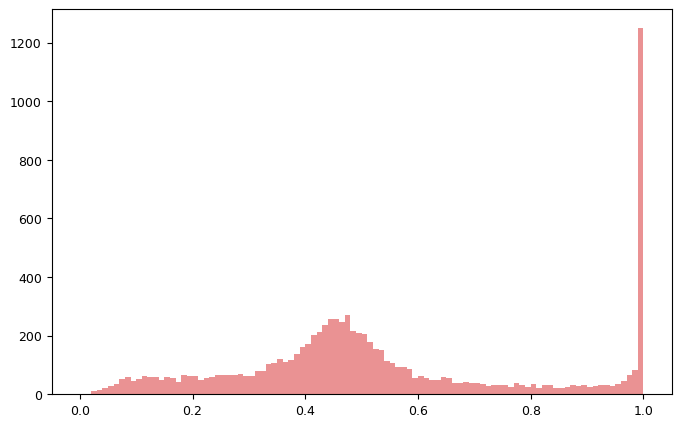

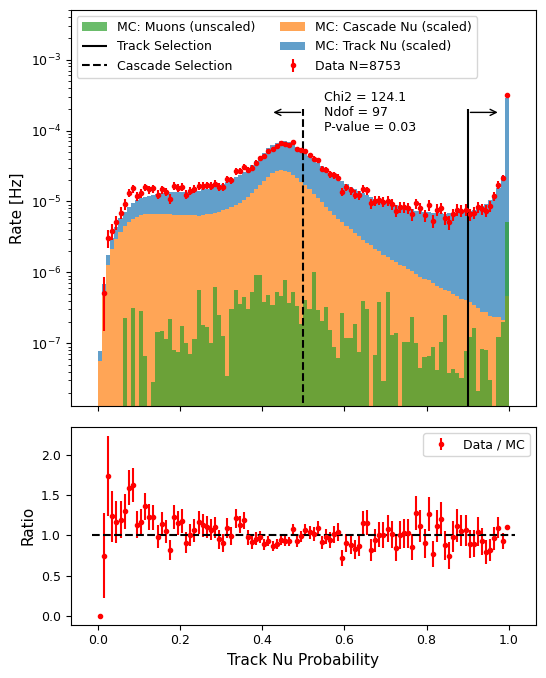

In [ ]:
bins = np.linspace(0,1,101)
bins_middle = (bins[1:]+bins[:-1])/2
bin_width = bins[1]-bins[0]

fig, axs = plt.subplots(figsize=(8, 5))

counts_track_fit, _,_ = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(pure_neutrino_track_selection)],density=False,bins=bins,label='track neutrinos MC',alpha=0.5,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_neutrino_track_selection)])
counts_cascade_fit, _,_ = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(pure_neutrino_cascade_selection)],density=False,bins=bins,label='cascade neutrinos MC',alpha=0.5,weights = MC['total_osc_weight'][MC['event_no'].isin(pure_neutrino_cascade_selection)])
TC_counts_RD_fit, _,_ = axs.hist(RD['track_mu_pred'][RD['event_no'].isin(pure_neutrino_selection_RD)],density=False,bins=bins,label='pure neutrinos RD',alpha=0.5,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_neutrino_selection_RD)])
TC_counts_RD_fit_not_rate, _,_ = axs.hist(RD['track_mu_pred'][RD['event_no'].isin(pure_neutrino_selection_RD)],density=False,bins=bins,label='pure neutrinos RD',alpha=0.5)


TC_uncertainty_RD_fit = np.zeros_like(TC_counts_RD_fit_not_rate)
for i in range(len(TC_uncertainty_RD_fit)):
    if TC_counts_RD_fit_not_rate[i]!= 0 :
        TC_uncertainty_RD_fit[i] = (1/np.sqrt(TC_counts_RD_fit_not_rate[i])) * TC_counts_RD_fit[i]

def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins)-1):
        if TC_counts_RD_fit[i] != 0:
            sum+= (TC_counts_RD_fit[i] - N_scalers[0]*counts_track_fit[i] - N_scalers[1]*counts_cascade_fit[i])**2/TC_uncertainty_RD_fit[i]**2
    return sum

N_0 = [50,50]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None), (0, None)))
print(res.x)
print(res.success)

counts_track_plot = counts_track_fit*res.x[0]#
counts_cascade_plot = counts_cascade_fit*res.x[1]##




print(TC_counts_RD_fit_not_rate[:35])
TC_RD_uncertainties_on_count = np.sqrt(TC_counts_RD_fit_not_rate)
print(TC_RD_uncertainties_on_count[:10])
TC_RD_percent_uncertainty_on_count = np.zeros_like(TC_RD_uncertainties_on_count)
TC_RD_uncertainties_on_rate = np.zeros_like(TC_RD_uncertainties_on_count)

for i in range(len(TC_RD_uncertainties_on_count)):
    if TC_RD_uncertainties_on_count[i] == 0:
        TC_RD_uncertainties_on_rate[i] = 0
        TC_RD_percent_uncertainty_on_count[i] = 0
    else:
        TC_RD_percent_uncertainty_on_count[i] = TC_RD_uncertainties_on_count[i]/TC_counts_RD_fit_not_rate[i]
        TC_RD_uncertainties_on_rate[i] = TC_counts_RD_fit[i]*TC_RD_percent_uncertainty_on_count[i]

print(TC_RD_percent_uncertainty_on_count[:10])
print(TC_RD_uncertainties_on_rate[:10])

TC_logit_ratio = TC_counts_RD_fit/(counts_track_plot + counts_cascade_plot)
TC_logit_ratio_uncertainties = TC_logit_ratio*TC_RD_percent_uncertainty_on_count

TC_logit_residual = TC_counts_RD_fit - (counts_track_plot + counts_cascade_plot)
TC_logit_chi_2 = 0
for i in range(len(TC_logit_residual)):
    if TC_RD_uncertainties_on_rate[i] !=0:
        TC_logit_chi_2 += (TC_logit_residual[i]/TC_RD_uncertainties_on_rate[i])**2
print(TC_logit_chi_2)
TC_logit_ndof = np.sum([TC_RD_uncertainties_on_rate!=0])-2
print(TC_logit_ndof)
TC_logit_p_value = sci.chi2.sf(TC_logit_chi_2,TC_logit_ndof)
print(TC_logit_p_value)








figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs2 = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])


axs2[0].bar(bins_middle,counts_cascade_plot,width=bin_width,label='MC: Cascade Nu (scaled)',color='C1',alpha=0.7)
axs2[0].bar(bins_middle,counts_track_plot,width=bin_width,bottom=counts_cascade_plot,label='MC: Track Nu (scaled)',color='C0',alpha=0.7)
axs2[0].hist(MC['track_mu_pred'][MC['event_no'].isin(sneaky_muons_selection)],density=False,bins=bins,label='MC: Muons (unscaled)',alpha=0.7,weights=MC['total_osc_weight'][MC['event_no'].isin(sneaky_muons_selection)],color='C2')
axs2[0].errorbar(bins_middle,TC_counts_RD_fit,yerr=TC_RD_uncertainties_on_rate,fmt='.',label='Data N={}'.format(int(np.sum(TC_counts_RD_fit_not_rate))),color='red')
axs2[0].vlines(track_cut,0,2*10**-4,color='black',label='Track Selection')
axs2[0].vlines(cascade_cut,0,2*10**-4,color='black',linestyle='dashed',label='Cascade Selection')

axs2[0].set_ylabel('Rate [Hz]')
axs2[0].set_yscale('log')
axs2[0].legend(loc='upper left',ncol=2)
axs2[0].set_ylim(top=0.5*10**(-2))

axs2[0].text(0.55, 1*10**(-4), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(TC_logit_chi_2,TC_logit_ndof,TC_logit_p_value),fontsize=9)

axs2[0].annotate("", xy=(track_cut+0.08, 2*0.9*10**(-4)), xytext=(track_cut, 2*0.9*10**(-4)),
             arrowprops=dict(arrowstyle="->"))
axs2[0].annotate("", xy=(cascade_cut-0.08, 2*0.9*10**(-4)), xytext=(cascade_cut, 2*0.9*10**(-4)),
             arrowprops=dict(arrowstyle="->"))

axs2[1].set_xlabel('Track Nu Probability')
axs2[1].set_ylabel('Ratio')
axs2[1].errorbar(bins_middle,TC_logit_ratio,yerr=TC_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
axs2[1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')
axs2[1].legend()

fig.tight_layout()
fig.savefig(outdir + 'track_probability.png',bbox_inches='tight',dpi=400)

[  0.   2.  12.  15.  20.  27.  36.  52.  60.  46.  51.  62.  58.  60.
  49.  58.  54.  43.  65.  61.  63.  49.  55.  59.  65.  65.  66.  65.
  70.  63.  63.  81.  78. 104. 106.]
[0.         1.41421356 3.46410162 3.87298335 4.47213595 5.19615242
 6.         7.21110255 7.74596669 6.78232998]
[0.         0.70710678 0.28867513 0.25819889 0.2236068  0.19245009
 0.16666667 0.13867505 0.12909944 0.14744196]
[0.00000000e+00 3.61119222e-07 8.84557830e-07 9.88965719e-07
 1.14195925e-06 1.32683675e-06 1.53209910e-06 1.84135396e-06
 1.97793144e-06 1.73186695e-06]
135.3271565771974
135.3271565771974
0.007472277285717497


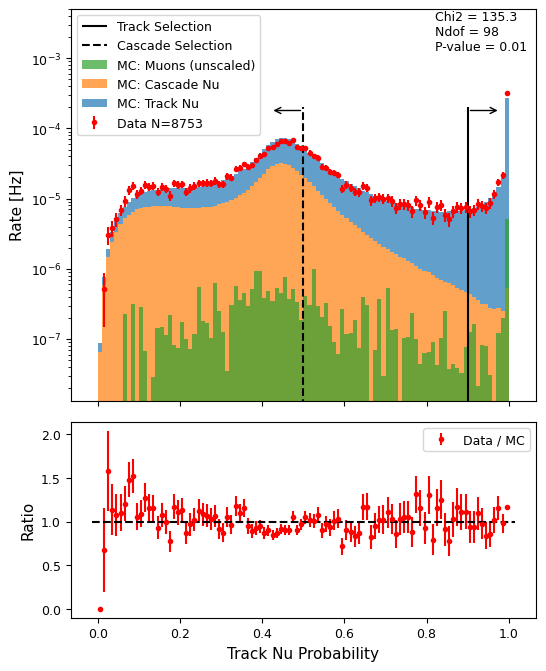

In [ ]:
bins_to_use = np.linspace(0,1,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2
bin_width = bins_to_use[1]-bins_to_use[0]

print(TC_counts_RD_fit_not_rate[:35])
TC_RD_uncertainties_on_count = np.sqrt(TC_counts_RD_fit_not_rate)
print(TC_RD_uncertainties_on_count[:10])
TC_RD_percent_uncertainty_on_count = np.zeros_like(TC_RD_uncertainties_on_count)
TC_RD_uncertainties_on_rate = np.zeros_like(TC_RD_uncertainties_on_count)

for i in range(len(TC_RD_uncertainties_on_count)):
    if TC_RD_uncertainties_on_count[i] == 0:
        TC_RD_uncertainties_on_rate[i] = 0
        TC_RD_percent_uncertainty_on_count[i] = 0
    else:
        TC_RD_percent_uncertainty_on_count[i] = TC_RD_uncertainties_on_count[i]/TC_counts_RD_fit_not_rate[i]
        TC_RD_uncertainties_on_rate[i] = TC_counts_RD_fit[i]*TC_RD_percent_uncertainty_on_count[i]

print(TC_RD_percent_uncertainty_on_count[:10])
print(TC_RD_uncertainties_on_rate[:10])

TC_logit_ratio = TC_counts_RD_fit/(counts_track_fit + counts_cascade_fit)
TC_logit_ratio_uncertainties = TC_logit_ratio*TC_RD_percent_uncertainty_on_count

TC_logit_residual = TC_counts_RD_fit - (counts_track_fit + counts_cascade_fit)
TC_logit_chi_2 = 0
for i in range(len(TC_logit_residual)):
    if TC_RD_uncertainties_on_rate[i] !=0:
        TC_logit_chi_2 += (TC_logit_residual[i]/TC_RD_uncertainties_on_rate[i])**2
print(TC_logit_chi_2)
TC_logit_ndof = len(bins_middle)-2
print(TC_logit_chi_2)
TC_logit_p_value = sci.chi2.sf(TC_logit_chi_2,TC_logit_ndof)
print(TC_logit_p_value)








figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs2 = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])


axs2[0].bar(bins_middle,counts_cascade_fit,width=bin_width,label='MC: Cascade Nu',color='C1',alpha=0.7)
axs2[0].bar(bins_middle,counts_track_fit,width=bin_width,bottom=counts_cascade_fit,label='MC: Track Nu',color='C0',alpha=0.7)
axs2[0].errorbar(bins_middle,TC_counts_RD_fit,yerr=TC_RD_uncertainties_on_rate,fmt='.',label='Data N={}'.format(int(np.sum(TC_counts_RD_fit_not_rate))),color='red')
axs2[0].vlines(track_cut,0,2*10**-4,color='black',label='Track Selection')
axs2[0].vlines(cascade_cut,0,2*10**-4,color='black',linestyle='dashed',label='Cascade Selection')
axs2[0].hist(MC['track_mu_pred'][MC['event_no'].isin(sneaky_muons_selection)],density=False,bins=bins,label='MC: Muons (unscaled)',alpha=0.7,weights=MC['total_osc_weight'][MC['event_no'].isin(sneaky_muons_selection)],color='C2')

axs2[0].set_ylabel('Rate [Hz]')
axs2[0].set_yscale('log')
axs2[0].legend(loc='upper left')
axs2[0].set_ylim(top=0.5*10**(-2))

axs2[0].text(0.82, 1.3*10**(-3), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(TC_logit_chi_2,TC_logit_ndof,TC_logit_p_value),fontsize=9)

axs2[0].annotate("", xy=(track_cut+0.08, 2*0.9*10**(-4)), xytext=(track_cut, 2*0.9*10**(-4)),
             arrowprops=dict(arrowstyle="->"))
axs2[0].annotate("", xy=(cascade_cut-0.08, 2*0.9*10**(-4)), xytext=(cascade_cut, 2*0.9*10**(-4)),
             arrowprops=dict(arrowstyle="->"))

axs2[1].set_xlabel('Track Nu Probability')
axs2[1].set_ylabel('Ratio')
axs2[1].errorbar(bins_middle,TC_logit_ratio,yerr=TC_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
axs2[1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')
axs2[1].legend()

fig.tight_layout()
fig.savefig(outdir + 'track_probability_unscaled.png',bbox_inches='tight',dpi=400)

In [ ]:
pure_track_event_no_MC = MC['event_no'][(MC['track_mu_pred']>track_cut)]# & (MC['track_mu_pred'] < track_cut_2) ]
pure_track_event_no_RD = RD['event_no'][(RD['track_mu_pred']>track_cut)]# & (RD['track_mu_pred'] < track_cut_2)]


pure_cascade_event_no_MC = MC['event_no'][MC['track_mu_pred']<cascade_cut]
pure_cascade_event_no_RD = RD['event_no'][RD['track_mu_pred']<cascade_cut]


pure_track_selection_MC = pure_track_event_no_MC[pure_track_event_no_MC.isin(pure_neutrino_selection_MC)]
pure_track_selection_MC_muons = pure_track_event_no_MC[pure_track_event_no_MC.isin(pure_neutrino_selection_MC_muons)]
pure_track_selection_MC_neutrinos = pure_track_event_no_MC[pure_track_event_no_MC.isin(pure_neutrino_selection_MC_neutrinos)]
pure_track_selection_RD = pure_track_event_no_RD[pure_track_event_no_RD.isin(pure_neutrino_selection_RD)]


pure_cascade_selection_MC = pure_cascade_event_no_MC[pure_cascade_event_no_MC.isin(pure_neutrino_selection_MC)]
pure_cascade_selection_MC_muons = pure_cascade_event_no_MC[pure_cascade_event_no_MC.isin(pure_neutrino_selection_MC_muons)]
pure_cascade_selection_MC_neutrinos = pure_cascade_event_no_MC[pure_cascade_event_no_MC.isin(pure_neutrino_selection_MC_neutrinos)]
pure_cascade_selection_RD = pure_cascade_event_no_RD[pure_cascade_event_no_RD.isin(pure_neutrino_selection_RD)]

print(len(pure_track_selection_MC))
print(len(pure_track_selection_MC_muons))
print(len(pure_track_selection_MC_neutrinos))
print(len(pure_track_selection_RD))
print(len(pure_cascade_selection_MC))
print(len(pure_cascade_selection_MC_muons))
print(len(pure_cascade_selection_MC_neutrinos))
print(len(pure_cascade_selection_RD))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC_muons.to_list())]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC_neutrinos.to_list())]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC.to_list())]))
print(np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD.to_list())]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC_muons.to_list())]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC_neutrinos.to_list())]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC.to_list())]))
print(np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD.to_list())]))

1088645
25
1088620
1628
6161853
211
6161642
4807
6.032904554603147e-06
0.0003723312764739479
0.00037836418102855116
0.00041570955690864013
1.2961106425194043e-05
0.0012577142034548004
0.0012706753098799945
0.0012274667322234847


[0.00000000e+00 2.18961566e-05 1.55323250e-06 1.96137942e-06
 2.60406774e-06 3.32935472e-06 4.08559761e-06 5.45875633e-06
 6.84223255e-06 8.80494273e-06]
[0.10199098 1.20298177 1.19481905]
True
[0.00000e+00 7.35300e+03 3.70000e+01 5.90000e+01 1.04000e+02 1.70000e+02
 2.56000e+02 4.57000e+02 7.18000e+02 1.18900e+03 2.19500e+03 3.87500e+03
 6.91100e+03 1.17230e+04 1.96590e+04 3.09670e+04 4.52720e+04 6.26780e+04
 8.10620e+04 9.84340e+04 1.12649e+05 1.21149e+05 1.23905e+05 1.21168e+05
 1.12511e+05 1.01404e+05 8.78450e+04 7.41190e+04 6.07040e+04 4.91660e+04
 3.92850e+04 3.12660e+04 2.46050e+04 1.92500e+04 1.47990e+04]
[ 0.         85.74963557  6.08276253  7.68114575 10.19803903 13.03840481
 16.         21.37755833 26.79552201 34.4818793 ]
[0.         0.01166186 0.16439899 0.13018891 0.09805807 0.0766965
 0.0625     0.04677803 0.03731967 0.02900074]
[0.00000000e+00 2.18961566e-05 1.55323250e-06 1.96137942e-06
 2.60406774e-06 3.32935472e-06 4.08559761e-06 5.45875633e-06
 6.84223255e-06 8.8049

/tmp/ipykernel_10144/4199338329.py:82: RuntimeWarning: invalid value encountered in divide
  track_only_multiclass_logit_ratio = track_only_counts_RD/(track_only_counts_noise_plot + track_only_counts_muon_plot + track_only_counts_neutrino_plot)


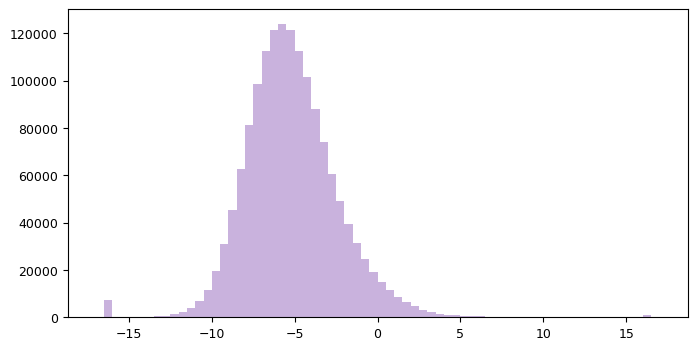

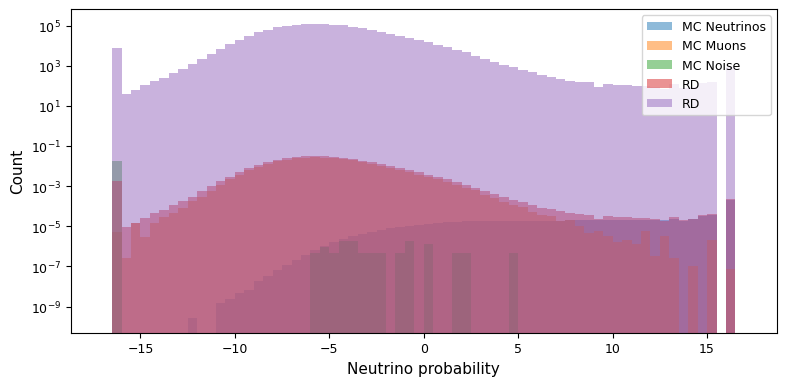

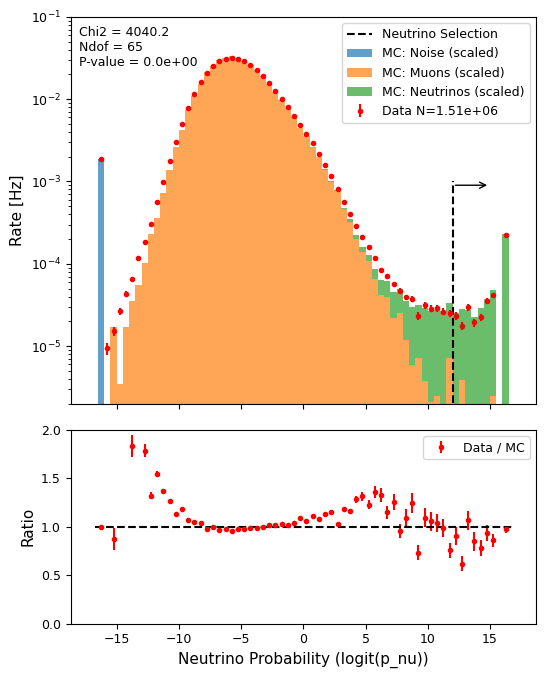

In [ ]:
bins_to_use = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_to_fit = bins_to_use#np.linspace(-17,17,101)

fig,axs =  plt.subplots(figsize=(8, 4))
track_only_counts_neutrino_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())])
track_only_counts_muon_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())])
track_only_counts_noise_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Noise',weights = MC['total_osc_weight'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())])
track_only_counts_RD_fit, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_track_event_no_RD.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='RD',weights=RD['total_osc_weight'][RD['event_no'].isin(pure_track_event_no_RD.to_list())])
track_only_counts_RD_fit_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_track_event_no_RD.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='RD')


fig, axs = plt.subplots(figsize=(8, 4))


bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

track_only_counts_neutrino, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())])
track_only_counts_muon, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())])
track_only_counts_noise, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Noise',weights=MC['total_osc_weight'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_track_event_no_MC.to_list())])
track_only_counts_RD, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_track_event_no_RD.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='RD',weights = RD['total_osc_weight'][RD['event_no'].isin(pure_track_event_no_RD.to_list())])
track_only_counts_RD_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_track_event_no_RD.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='RD')


axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig.tight_layout()

track_only_multiclass_uncertainty_RD_fit = np.zeros_like(track_only_counts_RD_fit_not_rate)
for i in range(len(track_only_multiclass_uncertainty_RD_fit)):
    if track_only_counts_RD_fit_not_rate[i]!= 0 :
        track_only_multiclass_uncertainty_RD_fit[i] = (1/np.sqrt(track_only_counts_RD_fit_not_rate[i])) * track_only_counts_RD_fit[i]

print(track_only_multiclass_uncertainty_RD_fit[:10])

def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins_to_fit)-1):
        if track_only_counts_RD_fit[i] != 0:
            sum+= (track_only_counts_RD_fit[i] - N_scalers[0]*track_only_counts_noise_fit[i] - N_scalers[1]*track_only_counts_muon_fit[i] - N_scalers[2]*track_only_counts_neutrino_fit[i])**2/track_only_multiclass_uncertainty_RD_fit[i]**2
    return sum

N_0 = [ 1.69090118, 17.63873833,  0.03073277]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

track_only_counts_noise_plot = track_only_counts_noise*res.x[0]#
track_only_counts_muon_plot = track_only_counts_muon*res.x[1]##
track_only_counts_neutrino_plot = track_only_counts_neutrino*res.x[2]#*#



bin_width = bins_to_use[1]-bins_to_use[0]


bins_to_use = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_to_fit = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2



print(track_only_counts_RD_not_rate[:35])
track_only_RD_uncertainties_on_count = np.sqrt(track_only_counts_RD_not_rate)
print(track_only_RD_uncertainties_on_count[:10])
track_only_RD_percent_uncertainty_on_count = np.zeros_like(track_only_RD_uncertainties_on_count)
track_only_RD_uncertainties_on_rate = np.zeros_like(track_only_RD_uncertainties_on_count)

for i in range(len(track_only_RD_uncertainties_on_count)):
    if track_only_RD_uncertainties_on_count[i] == 0:
        track_only_RD_uncertainties_on_rate[i] = 0
        track_only_RD_percent_uncertainty_on_count[i] = 0
    else:
        track_only_RD_percent_uncertainty_on_count[i] = track_only_RD_uncertainties_on_count[i]/track_only_counts_RD_not_rate[i]
        track_only_RD_uncertainties_on_rate[i] = track_only_counts_RD[i]*track_only_RD_percent_uncertainty_on_count[i]

print(track_only_RD_percent_uncertainty_on_count[:10])
print(track_only_RD_uncertainties_on_rate[:10])

track_only_multiclass_logit_ratio = track_only_counts_RD/(track_only_counts_noise_plot + track_only_counts_muon_plot + track_only_counts_neutrino_plot)
track_only_multiclass_logit_ratio_uncertainties = track_only_multiclass_logit_ratio*track_only_RD_percent_uncertainty_on_count

track_only_multiclass_logit_residual = track_only_counts_RD - (track_only_counts_noise_plot + track_only_counts_muon_plot + track_only_counts_neutrino_plot)
track_only_multiclass_logit_chi_2 = 0
for i in range(len(track_only_multiclass_logit_residual)):
    if track_only_RD_uncertainties_on_rate[i] !=0:
        track_only_multiclass_logit_chi_2 += (track_only_multiclass_logit_residual[i]/track_only_RD_uncertainties_on_rate[i])**2
print(track_only_multiclass_logit_chi_2)
track_only_multiclass_logit_ndof = len(bins_middle) - 3
print(track_only_multiclass_logit_chi_2)
track_only_multiclass_logit_p_value = sci.chi2.sf(track_only_multiclass_logit_chi_2,track_only_multiclass_logit_ndof)
print(track_only_multiclass_logit_p_value)

figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])
bins_to_use = np.linspace(-17,17,69)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2
bin_width = bins_to_use[1]-bins_to_use[0]

axs[0].bar(bins_middle,track_only_counts_noise_plot,width=bin_width,label='MC: Noise (scaled)',alpha=0.7)
axs[0].bar(bins_middle,track_only_counts_muon_plot,width=bin_width,bottom=track_only_counts_noise_plot,label='MC: Muons (scaled)',alpha=0.7)
axs[0].bar(bins_middle,track_only_counts_neutrino_plot,width=bin_width,bottom=track_only_counts_noise_plot+track_only_counts_muon_plot,label='MC: Neutrinos (scaled)',alpha=0.7)
axs[0].errorbar(x=bins_middle,y=track_only_counts_RD,yerr=track_only_RD_uncertainties_on_rate,fmt='.',label='Data N={:.2e}'.format(int(np.sum(track_only_counts_RD_not_rate))),color='red')
axs[0].vlines(Neutrino_cut,0,10**(-3),color='black',label='Neutrino Selection',linestyles='dashed')

axs[0].set_ylabel('Rate [Hz]')
axs[0].set_yscale('log')
axs[0].set_ylim(top=0.1,bottom=2*10**(-6))
#axs[0].set_xlim(-17,17)
axs[0].legend(loc='upper right')
axs[0].annotate("", xy=(Neutrino_cut+3, 0.9*10**(-3)), xytext=(Neutrino_cut, 0.9*10**(-3)),
            arrowprops=dict(arrowstyle="->"))
axs[0].text(-18, 0.025, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.1e}'.format(track_only_multiclass_logit_chi_2,track_only_multiclass_logit_ndof,track_only_multiclass_logit_p_value),fontsize=9)
axs[1].set_xlabel('Neutrino Probability (logit(p_nu))')
axs[1].set_ylabel('Ratio')
axs[1].errorbar(bins_middle,track_only_multiclass_logit_ratio,yerr=track_only_multiclass_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(bins_middle),np.max(bins_middle),color='k',linestyles='dashed')
axs[1].set_ylim(top=2,bottom=0)
axs[1].legend()

fig.tight_layout()
fig.savefig(outdir + 'multiclass_neutrino_prob_only_tracks.png',bbox_inches='tight',dpi=400)

[0.00000000e+00 3.70037089e-06 2.01062673e-06 2.05869631e-06
 1.78744895e-06 2.15161609e-06 2.22608839e-06 2.29814866e-06
 2.51490437e-06 2.78553801e-06]
[1.71677544 1.65763299 0.94119686]
True
[    0.   210.    62.    65.    49.    71.    76.    81.    97.   119.
   141.   166.   253.   326.   504.   798.  1274.  1941.  3042.  4424.
  6531.  9332. 12349. 14927. 16601. 17183. 16457. 15774. 14499. 13050.
 11836. 10824.  9510.  8768.  7902.]
[ 0.         14.49137675  7.87400787  8.06225775  7.          8.42614977
  8.71779789  9.          9.8488578  10.90871211]
[0.         0.06900656 0.12700013 0.12403473 0.14285714 0.11867817
 0.11470787 0.11111111 0.10153462 0.09166985]
[0.00000000e+00 3.70037089e-06 2.01062673e-06 2.05869631e-06
 1.78744895e-06 2.15161609e-06 2.22608839e-06 2.29814866e-06
 2.51490437e-06 2.78553801e-06]
1942.6040643870608
1942.6040643870608
0.0


/tmp/ipykernel_10144/1226083857.py:82: RuntimeWarning: divide by zero encountered in divide
  cascade_only_multiclass_logit_ratio = cascade_only_counts_RD/(cascade_only_counts_noise_plot + cascade_only_counts_muon_plot + cascade_only_counts_neutrino_plot)
/tmp/ipykernel_10144/1226083857.py:82: RuntimeWarning: invalid value encountered in divide
  cascade_only_multiclass_logit_ratio = cascade_only_counts_RD/(cascade_only_counts_noise_plot + cascade_only_counts_muon_plot + cascade_only_counts_neutrino_plot)
/groups/icecube/peter/anaconda3/envs/graphnet/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


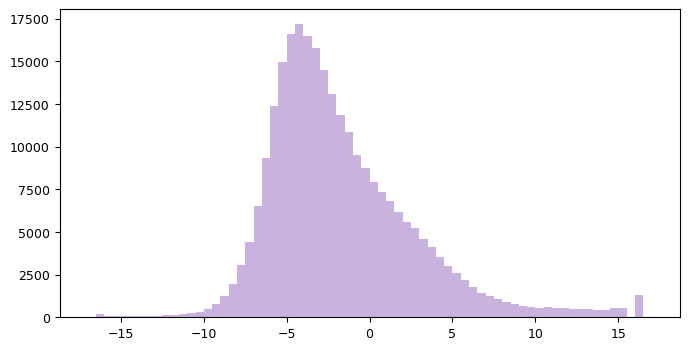

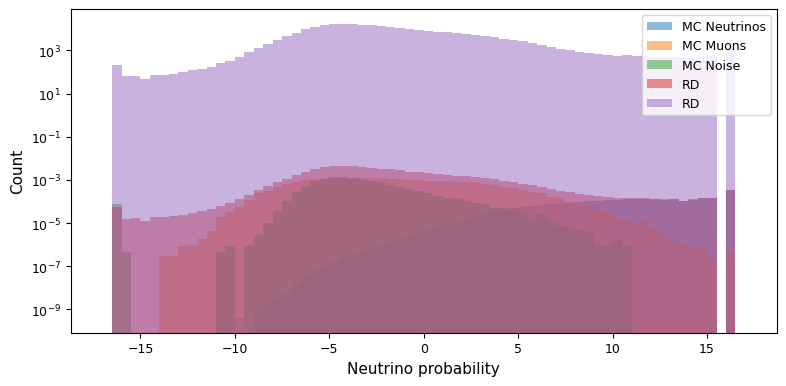

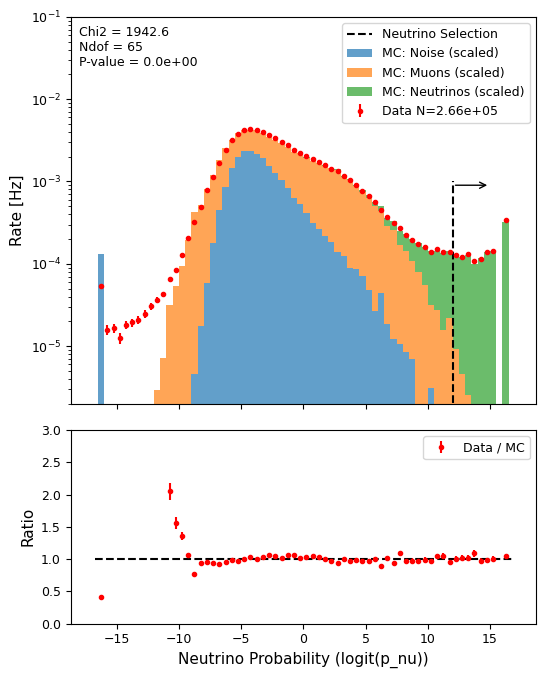

In [ ]:
bins_to_use = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_to_fit = bins_to_use#np.linspace(-17,17,101)

fig,axs =  plt.subplots(figsize=(8, 4))
cascade_only_counts_neutrino_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())])
cascade_only_counts_muon_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())])
cascade_only_counts_noise_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Noise',weights = MC['total_osc_weight'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())])
cascade_only_counts_RD_fit, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_cascade_event_no_RD.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='RD',weights=RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_event_no_RD.to_list())])
cascade_only_counts_RD_fit_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_cascade_event_no_RD.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='RD')


fig, axs = plt.subplots(figsize=(8, 4))


bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

cascade_only_counts_neutrino, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())])
cascade_only_counts_muon, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())])
cascade_only_counts_noise, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Noise',weights=MC['total_osc_weight'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_cascade_event_no_MC.to_list())])
cascade_only_counts_RD, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_cascade_event_no_RD.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='RD',weights = RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_event_no_RD.to_list())])
cascade_only_counts_RD_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_cascade_event_no_RD.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='RD')


axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig.tight_layout()

cascade_only_multiclass_uncertainty_RD_fit = np.zeros_like(cascade_only_counts_RD_fit_not_rate)
for i in range(len(cascade_only_multiclass_uncertainty_RD_fit)):
    if cascade_only_counts_RD_fit_not_rate[i]!= 0 :
        cascade_only_multiclass_uncertainty_RD_fit[i] = (1/np.sqrt(cascade_only_counts_RD_fit_not_rate[i])) * cascade_only_counts_RD_fit[i]

print(cascade_only_multiclass_uncertainty_RD_fit[:10])

def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins_to_fit)-1):
        if cascade_only_counts_RD_fit[i] != 0:
            sum+= (cascade_only_counts_RD_fit[i] - N_scalers[0]*cascade_only_counts_noise_fit[i] - N_scalers[1]*cascade_only_counts_muon_fit[i] - N_scalers[2]*cascade_only_counts_neutrino_fit[i])**2/cascade_only_multiclass_uncertainty_RD_fit[i]**2
    return sum

N_0 = [ 1.69090118, 17.63873833,  0.03073277]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

cascade_only_counts_noise_plot = cascade_only_counts_noise*res.x[0]#
cascade_only_counts_muon_plot = cascade_only_counts_muon*res.x[1]##
cascade_only_counts_neutrino_plot = cascade_only_counts_neutrino*res.x[2]#*#



bin_width = bins_to_use[1]-bins_to_use[0]


bins_to_use = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_to_fit = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2



print(cascade_only_counts_RD_not_rate[:35])
cascade_only_RD_uncertainties_on_count = np.sqrt(cascade_only_counts_RD_not_rate)
print(cascade_only_RD_uncertainties_on_count[:10])
cascade_only_RD_percent_uncertainty_on_count = np.zeros_like(cascade_only_RD_uncertainties_on_count)
cascade_only_RD_uncertainties_on_rate = np.zeros_like(cascade_only_RD_uncertainties_on_count)

for i in range(len(cascade_only_RD_uncertainties_on_count)):
    if cascade_only_RD_uncertainties_on_count[i] == 0:
        cascade_only_RD_uncertainties_on_rate[i] = 0
        cascade_only_RD_percent_uncertainty_on_count[i] = 0
    else:
        cascade_only_RD_percent_uncertainty_on_count[i] = cascade_only_RD_uncertainties_on_count[i]/cascade_only_counts_RD_not_rate[i]
        cascade_only_RD_uncertainties_on_rate[i] = cascade_only_counts_RD[i]*cascade_only_RD_percent_uncertainty_on_count[i]

print(cascade_only_RD_percent_uncertainty_on_count[:10])
print(cascade_only_RD_uncertainties_on_rate[:10])

cascade_only_multiclass_logit_ratio = cascade_only_counts_RD/(cascade_only_counts_noise_plot + cascade_only_counts_muon_plot + cascade_only_counts_neutrino_plot)
cascade_only_multiclass_logit_ratio_uncertainties = cascade_only_multiclass_logit_ratio*cascade_only_RD_percent_uncertainty_on_count

cascade_only_multiclass_logit_residual = cascade_only_counts_RD - (cascade_only_counts_noise_plot + cascade_only_counts_muon_plot + cascade_only_counts_neutrino_plot)
cascade_only_multiclass_logit_chi_2 = 0
for i in range(len(cascade_only_multiclass_logit_residual)):
    if cascade_only_RD_uncertainties_on_rate[i] !=0:
        cascade_only_multiclass_logit_chi_2 += (cascade_only_multiclass_logit_residual[i]/cascade_only_RD_uncertainties_on_rate[i])**2
print(cascade_only_multiclass_logit_chi_2)
cascade_only_multiclass_logit_ndof = len(bins_middle) - 3
print(cascade_only_multiclass_logit_chi_2)
cascade_only_multiclass_logit_p_value = sci.chi2.sf(cascade_only_multiclass_logit_chi_2,cascade_only_multiclass_logit_ndof)
print(cascade_only_multiclass_logit_p_value)

figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])
bins_to_use = np.linspace(-17,17,69)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2
bin_width = bins_to_use[1]-bins_to_use[0]

axs[0].bar(bins_middle,cascade_only_counts_noise_plot,width=bin_width,label='MC: Noise (scaled)',alpha=0.7)
axs[0].bar(bins_middle,cascade_only_counts_muon_plot,width=bin_width,bottom=cascade_only_counts_noise_plot,label='MC: Muons (scaled)',alpha=0.7)
axs[0].bar(bins_middle,cascade_only_counts_neutrino_plot,width=bin_width,bottom=cascade_only_counts_noise_plot+cascade_only_counts_muon_plot,label='MC: Neutrinos (scaled)',alpha=0.7)
axs[0].errorbar(x=bins_middle,y=cascade_only_counts_RD,yerr=cascade_only_RD_uncertainties_on_rate,fmt='.',label='Data N={:.2e}'.format(int(np.sum(cascade_only_counts_RD_not_rate))),color='red')
axs[0].vlines(Neutrino_cut,0,10**(-3),color='black',label='Neutrino Selection',linestyles='dashed')

axs[0].set_ylabel('Rate [Hz]')
axs[0].set_yscale('log')
axs[0].set_ylim(top=0.1,bottom=2*10**(-6))
#axs[0].set_xlim(-17,17)
axs[0].legend(loc='upper right')
axs[0].annotate("", xy=(Neutrino_cut+3, 0.9*10**(-3)), xytext=(Neutrino_cut, 0.9*10**(-3)),
            arrowprops=dict(arrowstyle="->"))
axs[0].text(-18, 0.025, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.1e}'.format(cascade_only_multiclass_logit_chi_2,cascade_only_multiclass_logit_ndof,cascade_only_multiclass_logit_p_value),fontsize=9)
axs[1].set_xlabel('Neutrino Probability (logit(p_nu))')
axs[1].set_ylabel('Ratio')
axs[1].errorbar(bins_middle,cascade_only_multiclass_logit_ratio,yerr=cascade_only_multiclass_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(bins_middle),np.max(bins_middle),color='k',linestyles='dashed')
axs[1].legend()
axs[1].set_ylim(top=3,bottom=0)

fig.tight_layout()
fig.savefig(outdir + 'multiclass_neutrino_prob_only_cascades.png',bbox_inches='tight',dpi=400)

[0.00000000e+00 2.29729733e-05 1.96137942e-06 1.92784910e-06
 1.73186695e-06 1.76911566e-06 1.76911566e-06 2.19660247e-06
 2.31229124e-06 2.36801710e-06]
[0.12301919 3.31554689 0.82744684]
True
[   0. 8094.   59.   57.   46.   48.   48.   74.   82.   86.   89.   83.
   87.  118.  137.  203.  277.  374.  643. 1180. 1912. 3175. 4754. 6297.
 7308. 7952. 7958. 7646. 7103. 6286. 5711. 5136. 4576. 4083. 3654.]
[ 0.         89.96666049  7.68114575  7.54983444  6.78232998  6.92820323
  6.92820323  8.60232527  9.05538514  9.2736185 ]
[0.         0.01111523 0.13018891 0.13245324 0.14744196 0.14433757
 0.14433757 0.11624764 0.11043153 0.10783277]
[0.00000000e+00 2.29729733e-05 1.96137942e-06 1.92784910e-06
 1.73186695e-06 1.76911566e-06 1.76911566e-06 2.19660247e-06
 2.31229124e-06 2.36801710e-06]
11781.666226483992
11781.666226483992
0.0


/tmp/ipykernel_10144/4242847998.py:88: RuntimeWarning: divide by zero encountered in divide
  upgoing_only_multiclass_logit_ratio = upgoing_only_counts_RD/(upgoing_only_counts_noise_plot + upgoing_only_counts_muon_plot + upgoing_only_counts_neutrino_plot)
/tmp/ipykernel_10144/4242847998.py:88: RuntimeWarning: invalid value encountered in divide
  upgoing_only_multiclass_logit_ratio = upgoing_only_counts_RD/(upgoing_only_counts_noise_plot + upgoing_only_counts_muon_plot + upgoing_only_counts_neutrino_plot)


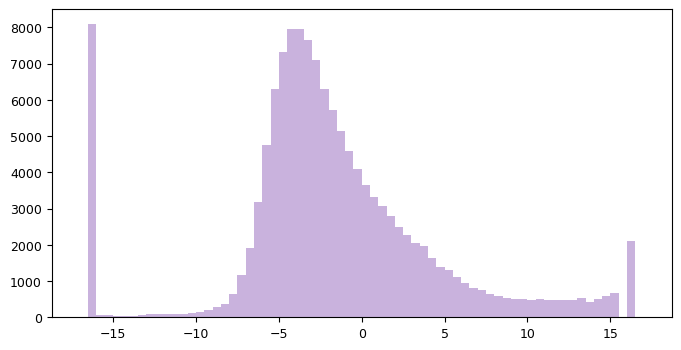

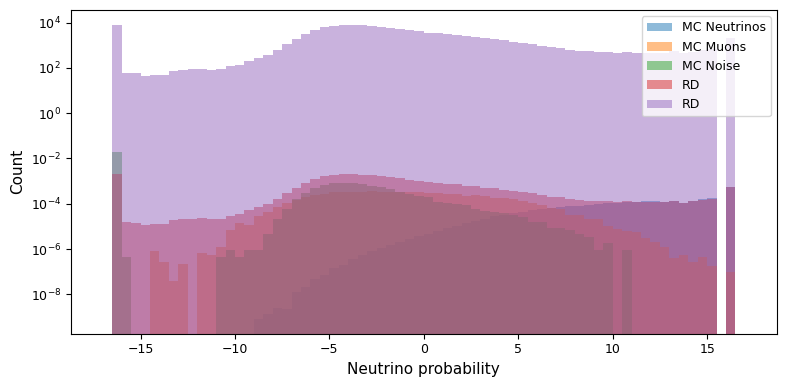

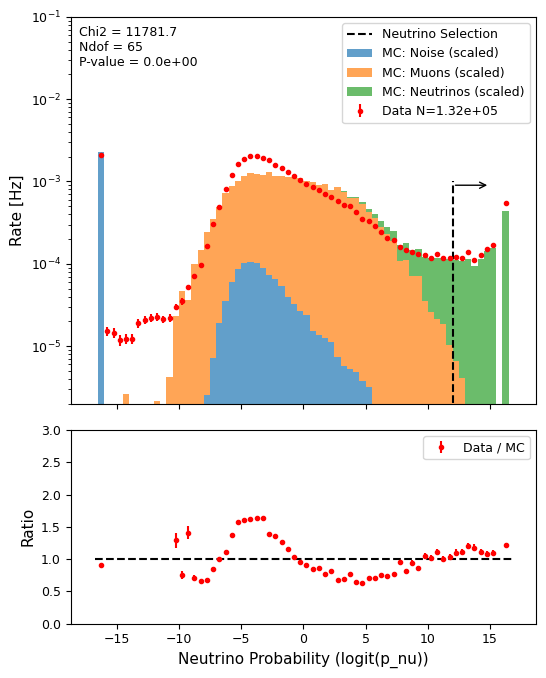

In [ ]:
upgoing_event_nos_MC = MC['event_no'][MC['zenith_pred']>np.pi/2]
pure_up_neutrinos_MC = MC['event_no'][(MC['event_no'].isin(upgoing_event_nos_MC.to_list()))]
upgoing_event_nos_RD = RD['event_no'][RD['zenith_pred']>np.pi/2]
pure_up_neutrinos_RD = RD['event_no'][(RD['event_no'].isin(upgoing_event_nos_RD.to_list()))]


bins_to_use = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_to_fit = bins_to_use#np.linspace(-17,17,101)

fig,axs =  plt.subplots(figsize=(8, 4))
upgoing_only_counts_neutrino_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
upgoing_only_counts_muon_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
upgoing_only_counts_noise_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Noise',weights = MC['total_osc_weight'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
upgoing_only_counts_RD_fit, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='RD',weights=RD['total_osc_weight'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())])
upgoing_only_counts_RD_fit_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='RD')


fig, axs = plt.subplots(figsize=(8, 4))


bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

upgoing_only_counts_neutrino, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
upgoing_only_counts_muon, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
upgoing_only_counts_noise, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Noise',weights=MC['total_osc_weight'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
upgoing_only_counts_RD, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='RD',weights = RD['total_osc_weight'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())])
upgoing_only_counts_RD_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='RD')


axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig.tight_layout()

upgoing_only_multiclass_uncertainty_RD_fit = np.zeros_like(upgoing_only_counts_RD_fit_not_rate)
for i in range(len(upgoing_only_multiclass_uncertainty_RD_fit)):
    if upgoing_only_counts_RD_fit_not_rate[i]!= 0 :
        upgoing_only_multiclass_uncertainty_RD_fit[i] = (1/np.sqrt(upgoing_only_counts_RD_fit_not_rate[i])) * upgoing_only_counts_RD_fit[i]

print(upgoing_only_multiclass_uncertainty_RD_fit[:10])

def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins_to_fit)-1):
        if upgoing_only_counts_RD_fit[i] != 0:
            sum+= (upgoing_only_counts_RD_fit[i] - N_scalers[0]*upgoing_only_counts_noise_fit[i] - N_scalers[1]*upgoing_only_counts_muon_fit[i] - N_scalers[2]*upgoing_only_counts_neutrino_fit[i])**2/upgoing_only_multiclass_uncertainty_RD_fit[i]**2
    return sum

N_0 = [ 1.69090118, 17.63873833,  0.03073277]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

upgoing_only_counts_noise_plot = upgoing_only_counts_noise*res.x[0]#
upgoing_only_counts_muon_plot = upgoing_only_counts_muon*res.x[1]##
upgoing_only_counts_neutrino_plot = upgoing_only_counts_neutrino*res.x[2]#*#



bin_width = bins_to_use[1]-bins_to_use[0]


bins_to_use = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_to_fit = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2



print(upgoing_only_counts_RD_not_rate[:35])
upgoing_only_RD_uncertainties_on_count = np.sqrt(upgoing_only_counts_RD_not_rate)
print(upgoing_only_RD_uncertainties_on_count[:10])
upgoing_only_RD_percent_uncertainty_on_count = np.zeros_like(upgoing_only_RD_uncertainties_on_count)
upgoing_only_RD_uncertainties_on_rate = np.zeros_like(upgoing_only_RD_uncertainties_on_count)

for i in range(len(upgoing_only_RD_uncertainties_on_count)):
    if upgoing_only_RD_uncertainties_on_count[i] == 0:
        upgoing_only_RD_uncertainties_on_rate[i] = 0
        upgoing_only_RD_percent_uncertainty_on_count[i] = 0
    else:
        upgoing_only_RD_percent_uncertainty_on_count[i] = upgoing_only_RD_uncertainties_on_count[i]/upgoing_only_counts_RD_not_rate[i]
        upgoing_only_RD_uncertainties_on_rate[i] = upgoing_only_counts_RD[i]*upgoing_only_RD_percent_uncertainty_on_count[i]

print(upgoing_only_RD_percent_uncertainty_on_count[:10])
print(upgoing_only_RD_uncertainties_on_rate[:10])

upgoing_only_multiclass_logit_ratio = upgoing_only_counts_RD/(upgoing_only_counts_noise_plot + upgoing_only_counts_muon_plot + upgoing_only_counts_neutrino_plot)
upgoing_only_multiclass_logit_ratio_uncertainties = upgoing_only_multiclass_logit_ratio*upgoing_only_RD_percent_uncertainty_on_count

upgoing_only_multiclass_logit_residual = upgoing_only_counts_RD - (upgoing_only_counts_noise_plot + upgoing_only_counts_muon_plot + upgoing_only_counts_neutrino_plot)
upgoing_only_multiclass_logit_chi_2 = 0
for i in range(len(upgoing_only_multiclass_logit_residual)):
    if upgoing_only_RD_uncertainties_on_rate[i] !=0:
        upgoing_only_multiclass_logit_chi_2 += (upgoing_only_multiclass_logit_residual[i]/upgoing_only_RD_uncertainties_on_rate[i])**2
print(upgoing_only_multiclass_logit_chi_2)
upgoing_only_multiclass_logit_ndof = len(bins_middle) - 3
print(upgoing_only_multiclass_logit_chi_2)
upgoing_only_multiclass_logit_p_value = sci.chi2.sf(upgoing_only_multiclass_logit_chi_2,upgoing_only_multiclass_logit_ndof)
print(upgoing_only_multiclass_logit_p_value)

figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])
bins_to_use = np.linspace(-17,17,69)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2
bin_width = bins_to_use[1]-bins_to_use[0]

axs[0].bar(bins_middle,upgoing_only_counts_noise_plot,width=bin_width,label='MC: Noise (scaled)',alpha=0.7)
axs[0].bar(bins_middle,upgoing_only_counts_muon_plot,width=bin_width,bottom=upgoing_only_counts_noise_plot,label='MC: Muons (scaled)',alpha=0.7)
axs[0].bar(bins_middle,upgoing_only_counts_neutrino_plot,width=bin_width,bottom=upgoing_only_counts_noise_plot+upgoing_only_counts_muon_plot,label='MC: Neutrinos (scaled)',alpha=0.7)
axs[0].errorbar(x=bins_middle,y=upgoing_only_counts_RD,yerr=upgoing_only_RD_uncertainties_on_rate,fmt='.',label='Data N={:.2e}'.format(int(np.sum(upgoing_only_counts_RD_not_rate))),color='red')
axs[0].vlines(Neutrino_cut,0,10**(-3),color='black',label='Neutrino Selection',linestyles='dashed')

axs[0].set_ylabel('Rate [Hz]')
axs[0].set_yscale('log')
axs[0].set_ylim(top=0.1,bottom=2*10**(-6))
#axs[0].set_xlim(-17,17)
axs[0].legend(loc='upper right')
axs[0].annotate("", xy=(Neutrino_cut+3, 0.9*10**(-3)), xytext=(Neutrino_cut, 0.9*10**(-3)),
            arrowprops=dict(arrowstyle="->"))
axs[0].text(-18, 0.025, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.1e}'.format(upgoing_only_multiclass_logit_chi_2,upgoing_only_multiclass_logit_ndof,upgoing_only_multiclass_logit_p_value),fontsize=9)
axs[1].set_xlabel('Neutrino Probability (logit(p_nu))')
axs[1].set_ylabel('Ratio')
axs[1].errorbar(bins_middle,upgoing_only_multiclass_logit_ratio,yerr=upgoing_only_multiclass_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(bins_middle),np.max(bins_middle),color='k',linestyles='dashed')
axs[1].set_ylim(0,3)
axs[1].legend()

fig.tight_layout()
fig.savefig(outdir + 'multiclass_neutrino_prob_only_upgoing.png',bbox_inches='tight',dpi=400)

[0.00000000e+00 3.63817535e-06 2.65367349e-06 2.84345560e-06
 3.35860291e-06 4.10946693e-06 4.79078786e-06 6.05346124e-06
 7.55766541e-06 9.56454784e-06]
[2.68349725 1.20835525 1.16197338]
True
[0.00000e+00 2.03000e+02 1.08000e+02 1.24000e+02 1.73000e+02 2.59000e+02
 3.52000e+02 5.62000e+02 8.76000e+02 1.40300e+03 2.51700e+03 4.41500e+03
 7.82800e+03 1.32350e+04 2.22120e+04 3.53620e+04 5.22320e+04 7.28470e+04
 9.57410e+04 1.17826e+05 1.37863e+05 1.51918e+05 1.58923e+05 1.59109e+05
 1.51585e+05 1.40066e+05 1.24353e+05 1.08267e+05 9.17800e+04 7.67800e+04
 6.37160e+04 5.32780e+04 4.37950e+04 3.65490e+04 3.01630e+04]
[ 0.         14.24780685 10.39230485 11.13552873 13.15294644 16.09347694
 18.76166304 23.70653918 29.59729717 37.4566416 ]
[0.         0.07018624 0.09622504 0.08980265 0.07602859 0.06213698
 0.05330018 0.04218245 0.03378687 0.02669753]
[0.00000000e+00 3.63817535e-06 2.65367349e-06 2.84345560e-06
 3.35860291e-06 4.10946693e-06 4.79078786e-06 6.05346124e-06
 7.55766541e-06 9.564

/tmp/ipykernel_10144/1270041588.py:88: RuntimeWarning: invalid value encountered in divide
  downgoing_only_multiclass_logit_ratio = downgoing_only_counts_RD/(downgoing_only_counts_noise_plot + downgoing_only_counts_muon_plot + downgoing_only_counts_neutrino_plot)


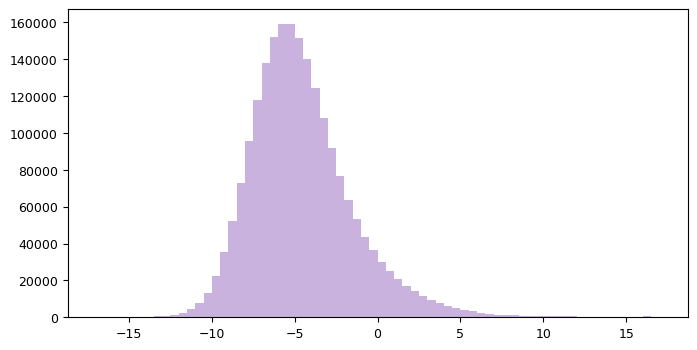

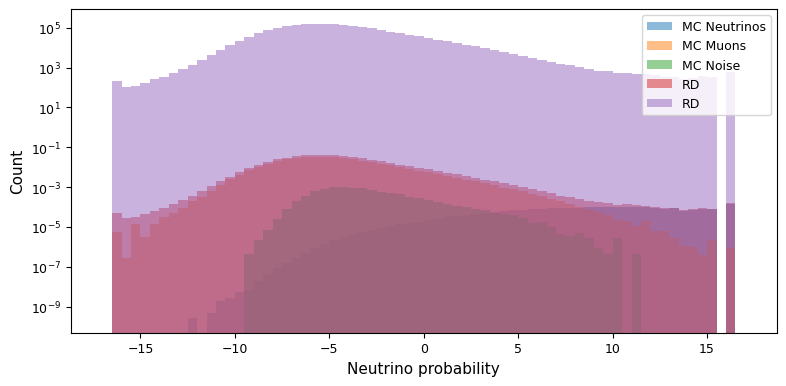

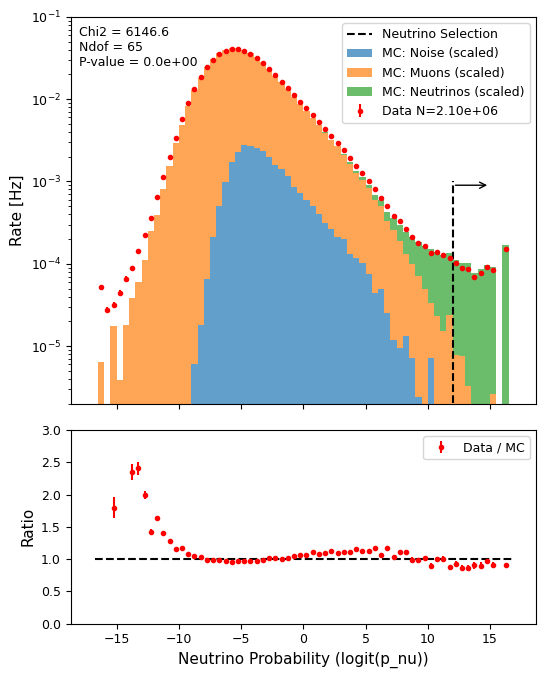

In [ ]:
downgoing_event_nos_MC = MC['event_no'][MC['zenith_pred']<np.pi/2]
pure_up_neutrinos_MC = MC['event_no'][(MC['event_no'].isin(downgoing_event_nos_MC.to_list()))]
downgoing_event_nos_RD = RD['event_no'][RD['zenith_pred']<np.pi/2]
pure_up_neutrinos_RD = RD['event_no'][(RD['event_no'].isin(downgoing_event_nos_RD.to_list()))]


bins_to_use = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_to_fit = bins_to_use#np.linspace(-17,17,101)

fig,axs =  plt.subplots(figsize=(8, 4))
downgoing_only_counts_neutrino_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
downgoing_only_counts_muon_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
downgoing_only_counts_noise_fit, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='MC Noise',weights = MC['total_osc_weight'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
downgoing_only_counts_RD_fit, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='RD',weights=RD['total_osc_weight'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())])
downgoing_only_counts_RD_fit_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())],bins=bins_to_fit,density=False,alpha=0.5,label='RD')


fig, axs = plt.subplots(figsize=(8, 4))


bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

downgoing_only_counts_neutrino, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Neutrinos',weights=MC['total_osc_weight'][(MC['pid'].isin((-12,12,-14,14,-16,16))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
downgoing_only_counts_muon, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Muons',weights=MC['total_osc_weight'][(MC['pid'].isin((-13,13))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
downgoing_only_counts_noise, _,_ = axs.hist(MC['pid_neutrino_pred_logit'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='MC Noise',weights=MC['total_osc_weight'][(MC['pid'].isin((-1,1))) & MC['event_no'].isin(pure_up_neutrinos_MC.to_list())])
downgoing_only_counts_RD, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='RD',weights = RD['total_osc_weight'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())])
downgoing_only_counts_RD_not_rate, _,_ = axs.hist(RD['pid_neutrino_pred_logit'][RD['event_no'].isin(pure_up_neutrinos_RD.to_list())],bins=bins_to_use,density=False,alpha=0.5,label='RD')


axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig.tight_layout()

downgoing_only_multiclass_uncertainty_RD_fit = np.zeros_like(downgoing_only_counts_RD_fit_not_rate)
for i in range(len(downgoing_only_multiclass_uncertainty_RD_fit)):
    if downgoing_only_counts_RD_fit_not_rate[i]!= 0 :
        downgoing_only_multiclass_uncertainty_RD_fit[i] = (1/np.sqrt(downgoing_only_counts_RD_fit_not_rate[i])) * downgoing_only_counts_RD_fit[i]

print(downgoing_only_multiclass_uncertainty_RD_fit[:10])

def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins_to_fit)-1):
        if downgoing_only_counts_RD_fit[i] != 0:
            sum+= (downgoing_only_counts_RD_fit[i] - N_scalers[0]*downgoing_only_counts_noise_fit[i] - N_scalers[1]*downgoing_only_counts_muon_fit[i] - N_scalers[2]*downgoing_only_counts_neutrino_fit[i])**2/downgoing_only_multiclass_uncertainty_RD_fit[i]**2
    return sum

N_0 = [ 1.69090118, 17.63873833,  0.03073277]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

downgoing_only_counts_noise_plot = downgoing_only_counts_noise*res.x[0]#
downgoing_only_counts_muon_plot = downgoing_only_counts_muon*res.x[1]##
downgoing_only_counts_neutrino_plot = downgoing_only_counts_neutrino*res.x[2]#*#



bin_width = bins_to_use[1]-bins_to_use[0]


bins_to_use = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_to_fit = np.linspace(-17,17,69)#np.linspace(-17,17,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2



print(downgoing_only_counts_RD_not_rate[:35])
downgoing_only_RD_uncertainties_on_count = np.sqrt(downgoing_only_counts_RD_not_rate)
print(downgoing_only_RD_uncertainties_on_count[:10])
downgoing_only_RD_percent_uncertainty_on_count = np.zeros_like(downgoing_only_RD_uncertainties_on_count)
downgoing_only_RD_uncertainties_on_rate = np.zeros_like(downgoing_only_RD_uncertainties_on_count)

for i in range(len(downgoing_only_RD_uncertainties_on_count)):
    if downgoing_only_RD_uncertainties_on_count[i] == 0:
        downgoing_only_RD_uncertainties_on_rate[i] = 0
        downgoing_only_RD_percent_uncertainty_on_count[i] = 0
    else:
        downgoing_only_RD_percent_uncertainty_on_count[i] = downgoing_only_RD_uncertainties_on_count[i]/downgoing_only_counts_RD_not_rate[i]
        downgoing_only_RD_uncertainties_on_rate[i] = downgoing_only_counts_RD[i]*downgoing_only_RD_percent_uncertainty_on_count[i]

print(downgoing_only_RD_percent_uncertainty_on_count[:10])
print(downgoing_only_RD_uncertainties_on_rate[:10])

downgoing_only_multiclass_logit_ratio = downgoing_only_counts_RD/(downgoing_only_counts_noise_plot + downgoing_only_counts_muon_plot + downgoing_only_counts_neutrino_plot)
downgoing_only_multiclass_logit_ratio_uncertainties = downgoing_only_multiclass_logit_ratio*downgoing_only_RD_percent_uncertainty_on_count

downgoing_only_multiclass_logit_residual = downgoing_only_counts_RD - (downgoing_only_counts_noise_plot + downgoing_only_counts_muon_plot + downgoing_only_counts_neutrino_plot)
downgoing_only_multiclass_logit_chi_2 = 0
for i in range(len(downgoing_only_multiclass_logit_residual)):
    if downgoing_only_RD_uncertainties_on_rate[i] !=0:
        downgoing_only_multiclass_logit_chi_2 += (downgoing_only_multiclass_logit_residual[i]/downgoing_only_RD_uncertainties_on_rate[i])**2
print(downgoing_only_multiclass_logit_chi_2)
downgoing_only_multiclass_logit_ndof = len(bins_middle) - 3
print(downgoing_only_multiclass_logit_chi_2)
downgoing_only_multiclass_logit_p_value = sci.chi2.sf(downgoing_only_multiclass_logit_chi_2,downgoing_only_multiclass_logit_ndof)
print(downgoing_only_multiclass_logit_p_value)

figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])
bins_to_use = np.linspace(-17,17,69)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2
bin_width = bins_to_use[1]-bins_to_use[0]

axs[0].bar(bins_middle,downgoing_only_counts_noise_plot,width=bin_width,label='MC: Noise (scaled)',alpha=0.7)
axs[0].bar(bins_middle,downgoing_only_counts_muon_plot,width=bin_width,bottom=downgoing_only_counts_noise_plot,label='MC: Muons (scaled)',alpha=0.7)
axs[0].bar(bins_middle,downgoing_only_counts_neutrino_plot,width=bin_width,bottom=downgoing_only_counts_noise_plot+downgoing_only_counts_muon_plot,label='MC: Neutrinos (scaled)',alpha=0.7)
axs[0].errorbar(x=bins_middle,y=downgoing_only_counts_RD,yerr=downgoing_only_RD_uncertainties_on_rate,fmt='.',label='Data N={:.2e}'.format(int(np.sum(downgoing_only_counts_RD_not_rate))),color='red')
axs[0].vlines(Neutrino_cut,0,10**(-3),color='black',label='Neutrino Selection',linestyles='dashed')

axs[0].set_ylabel('Rate [Hz]')
axs[0].set_yscale('log')
axs[0].set_ylim(top=0.1,bottom=2*10**(-6))
#axs[0].set_xlim(-17,17)
axs[0].legend(loc='upper right')
axs[0].annotate("", xy=(Neutrino_cut+3, 0.9*10**(-3)), xytext=(Neutrino_cut, 0.9*10**(-3)),
            arrowprops=dict(arrowstyle="->"))
axs[0].text(-18, 0.025, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.1e}'.format(downgoing_only_multiclass_logit_chi_2,downgoing_only_multiclass_logit_ndof,downgoing_only_multiclass_logit_p_value),fontsize=9)
axs[1].set_xlabel('Neutrino Probability (logit(p_nu))')
axs[1].set_ylabel('Ratio')
axs[1].errorbar(bins_middle,downgoing_only_multiclass_logit_ratio,yerr=downgoing_only_multiclass_logit_ratio_uncertainties,fmt='.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(bins_middle),np.max(bins_middle),color='k',linestyles='dashed')
axs[1].set_ylim(0,3)
axs[1].legend()

fig.tight_layout()
fig.savefig(outdir + 'multiclass_neutrino_prob_only_downgoing.png',bbox_inches='tight',dpi=400)

In [ ]:
def uncertainties_from_counts_rates(counts,rates):
    uncertainties = np.zeros(len(counts))
    fractional_uncertainty = np.zeros(len(counts))
    for i in range(len(uncertainties)):
        if counts[i]!=0:
            uncertainties[i] = 1/np.sqrt(counts[i]) * rates[i]
            fractional_uncertainty[i] = 1/np.sqrt(counts[i])
    #print(uncertainties)
    return uncertainties,fractional_uncertainty

def chi2_calculation(MC_rates,RD_rates,RD_uncertainties,parameters=1):
    chi2 = 0
    ndof = np.sum(RD_rates!=0)-parameters
    for i in range(len(RD_rates)):
        if RD_rates[i]!=0 and MC_rates[i]!=0:
            chi2 += (RD_rates[i]-MC_rates[i])**2/RD_uncertainties[i]**2
    p_value = sci.chi2.sf(chi2,ndof)

    return chi2,ndof,p_value


if scale_MC_to_RD_in_comparison_plots == True:
    scale_track = np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])/np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)])
    print(scale_track)
    scale_cascade = np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])/np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)])
    print(scale_cascade)
else:
    scale_track = 1
    scale_cascade = 1

1.09870219685851
0.9659955794210006


KeyError: 'position_x_pred'

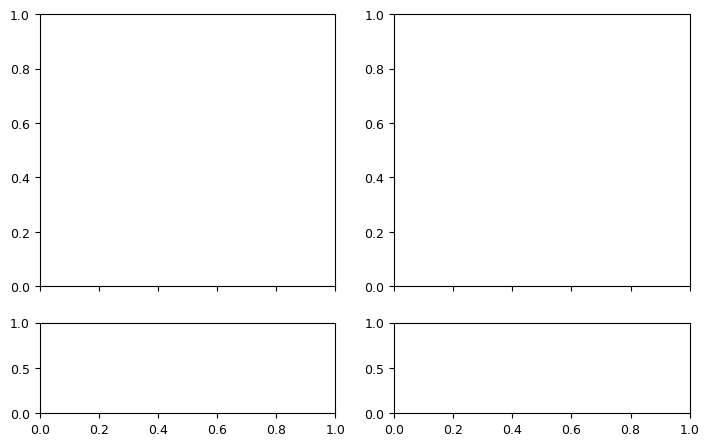

In [ ]:

figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.5
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex='col',height_ratios=[3, 1])

min_RD = np.min(RD['position_x_pred'][RD['event_no'].isin(pure_track_selection_RD)])
min_MC = np.min(MC['position_x_pred'][MC['event_no'].isin(pure_track_selection_MC)])
bins=np.linspace(-230,270,81)
bins_middle = (bins[1:] + bins[:-1])/2
track_rates, _ = np.histogram(np.clip(RD['position_x_pred'][RD['event_no'].isin(pure_track_selection_RD)],-230,270),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])
track_counts, _ = np.histogram(np.clip(RD['position_x_pred'][RD['event_no'].isin(pure_track_selection_RD)],-230,270),density=False,bins=bins)
track_uncertainty,track_fractional_uncertainty = uncertainties_from_counts_rates(track_counts,track_rates)


track_rates_MC,_,_ = axs[0,0].hist(np.clip(MC['position_x_pred'][MC['event_no'].isin(pure_track_selection_MC)],-230,270), histtype='step',density=False,label='MC: Track Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[0,0].errorbar(bins_middle,track_rates,yerr=track_uncertainty,fmt='.',label='Data N={}'.format(len(pure_track_selection_RD)),color='red')
track_ratio = track_rates/track_rates_MC
track_ratio_uncertainty = track_ratio*track_fractional_uncertainty
if with_MC_truth:
    axs[0,0].hist(MC['position_x'][MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=False,label='MC: Track Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)


axs[1,0].set_xlabel(r'Position x (m)')
axs[0,0].set_ylabel('Rate (Hz)')
axs[0,0].set_ylim(top=2.5*10**(-5))
axs[0,0].legend(loc='upper right')

axs[1,0].errorbar(bins_middle,track_ratio,yerr=track_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,0].set_ylabel('Ratio')

track_chi2,track_ndof,track_p_value = chi2_calculation(track_rates_MC,track_rates,track_uncertainty)
print(track_chi2,track_ndof,track_p_value)
axs[0,0].text(-220, 1.5*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(track_chi2,track_ndof,track_p_value),fontsize=9)
axs[1,0].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

min_RD = np.min(RD['position_x_pred'][RD['event_no'].isin(pure_cascade_selection_RD)])
min_MC = np.min(MC['position_x_pred'][MC['event_no'].isin(pure_cascade_selection_MC)])
bins=np.linspace(-200,200,101)
bins_middle = (bins[1:] + bins[:-1])/2

cascade_rates, _ = np.histogram(np.clip(RD['position_x_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],-200,200),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])
cascade_counts, _ = np.histogram(np.clip(RD['position_x_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],-200,200),density=False,bins=bins)
cascade_uncertainty,cascade_fractional_uncertainty = uncertainties_from_counts_rates(cascade_counts,cascade_rates)



cascade_rates_MC,_,_ = axs[0,1].hist(np.clip(MC['position_x_pred'][MC['event_no'].isin(pure_cascade_selection_MC)],-200,200), histtype='step',density=False,label='MC: Cascade Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)


cascade_ratio = cascade_rates/cascade_rates_MC
cascade_ratio_uncertainty = cascade_ratio*cascade_fractional_uncertainty
axs[0,1].errorbar(bins_middle,cascade_rates,yerr=cascade_uncertainty,fmt='.',label='Data N={}'.format(len(pure_cascade_selection_RD)),color='red')
axs[1,1].set_xlabel(r'Position x (m)')
axs[0,1].set_ylabel('Rate (Hz)')
axs[0,1].set_ylim(top=7.2*10**(-5))

axs[1,1].errorbar(bins_middle,cascade_ratio,yerr=cascade_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,1].set_ylabel('Ratio')
axs[1,1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')
if with_MC_truth:
    axs[0,1].hist(MC['position_x'][MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=False,label='MC: Cascade Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)

axs[0,1].legend(loc='upper right')
cascade_chi2,cascade_ndof,cascade_p_value = chi2_calculation(cascade_rates_MC,cascade_rates,cascade_uncertainty)
print(cascade_chi2,cascade_ndof,cascade_p_value)
axs[0,1].text(-200, 4*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(cascade_chi2,cascade_ndof,cascade_p_value),fontsize=9)
axs[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
axs[0,0].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
fig.tight_layout()
fig.savefig(outdir + 'position_x_track_cascade_rate_ratio.png',bbox_inches='tight',dpi=200)

303.8879931538427 79 4.162464343467745e-28
1386.3473803052634 99 6.805882434704913e-226


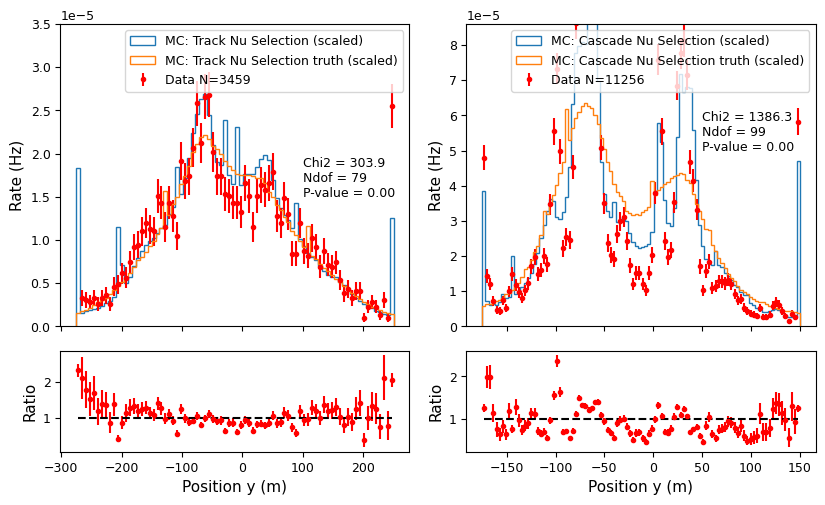

In [ ]:

figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.5
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex='col',height_ratios=[3, 1])

min_RD = np.min(RD['position_y_pred'][RD['event_no'].isin(pure_track_selection_RD)])
min_MC = np.min(MC['position_y_pred'][MC['event_no'].isin(pure_track_selection_MC)])
bins=np.linspace(-275,250,81)
bins_middle = (bins[1:] + bins[:-1])/2
track_rates, _ = np.histogram(np.clip(RD['position_y_pred'][RD['event_no'].isin(pure_track_selection_RD)],-275,250),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])
track_counts, _ = np.histogram(np.clip(RD['position_y_pred'][RD['event_no'].isin(pure_track_selection_RD)],-275,250),density=False,bins=bins)
track_uncertainty,track_fractional_uncertainty = uncertainties_from_counts_rates(track_counts,track_rates)


track_rates_MC,_,_ = axs[0,0].hist(np.clip(MC['position_y_pred'][MC['event_no'].isin(pure_track_selection_MC)],-275,250), histtype='step',density=False,label='MC: Track Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[0,0].errorbar(bins_middle,track_rates,yerr=track_uncertainty,fmt='.',label='Data N={}'.format(len(pure_track_selection_RD)),color='red')
track_ratio = track_rates/track_rates_MC
track_ratio_uncertainty = track_ratio*track_fractional_uncertainty
if with_MC_truth:
    axs[0,0].hist(MC['position_y'][MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=False,label='MC: Track Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)

axs[1,0].set_xlabel(r'Position y (m)')
axs[0,0].set_ylabel('Rate (Hz)')
axs[0,0].set_ylim(top=3.5*10**(-5))
axs[0,0].legend(loc='upper right')

axs[1,0].errorbar(bins_middle,track_ratio,yerr=track_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,0].set_ylabel('Ratio')

track_chi2,track_ndof,track_p_value = chi2_calculation(track_rates_MC,track_rates,track_uncertainty)
print(track_chi2,track_ndof,track_p_value)
axs[0,0].text(100, 1.5*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(track_chi2,track_ndof,track_p_value),fontsize=9)
axs[1,0].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

min_RD = np.min(RD['position_y_pred'][RD['event_no'].isin(pure_cascade_selection_RD)])
min_MC = np.min(MC['position_y_pred'][MC['event_no'].isin(pure_cascade_selection_MC)])
bins=np.linspace(-175,150,101)
bins_middle = (bins[1:] + bins[:-1])/2

cascade_rates, _ = np.histogram(np.clip(RD['position_y_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],-175,150),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])
cascade_counts, _ = np.histogram(np.clip(RD['position_y_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],-175,150),density=False,bins=bins)
cascade_uncertainty,cascade_fractional_uncertainty = uncertainties_from_counts_rates(cascade_counts,cascade_rates)



cascade_rates_MC,_,_ = axs[0,1].hist(np.clip(MC['position_y_pred'][MC['event_no'].isin(pure_cascade_selection_MC)],-175,150), histtype='step',density=False,label='MC: Cascade Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)


cascade_ratio = cascade_rates/cascade_rates_MC
cascade_ratio_uncertainty = cascade_ratio*cascade_fractional_uncertainty
axs[0,1].errorbar(bins_middle,cascade_rates,yerr=cascade_uncertainty,fmt='.',label='Data N={}'.format(len(pure_cascade_selection_RD)),color='red')
axs[1,1].set_xlabel(r'Position y (m)')
axs[0,1].set_ylabel('Rate (Hz)')
axs[0,1].set_ylim(top=8.6*10**(-5))

axs[1,1].errorbar(bins_middle,cascade_ratio,yerr=cascade_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,1].set_ylabel('Ratio')
axs[1,1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')
if with_MC_truth:
    axs[0,1].hist(MC['position_y'][MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=False,label='MC: Cascade Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)
axs[0,1].legend(loc='upper right')
cascade_chi2,cascade_ndof,cascade_p_value = chi2_calculation(cascade_rates_MC,cascade_rates,cascade_uncertainty)
print(cascade_chi2,cascade_ndof,cascade_p_value)
axs[0,1].text(50, 5*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(cascade_chi2,cascade_ndof,cascade_p_value),fontsize=9)
axs[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
axs[0,0].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
fig.tight_layout()
fig.savefig(outdir + 'position_y_track_cascade_rate_ratio.png',bbox_inches='tight',dpi=200)

355.2543113475467 79 1.1381666984806294e-36
1104.0041399233523 99 2.2627107845154045e-169


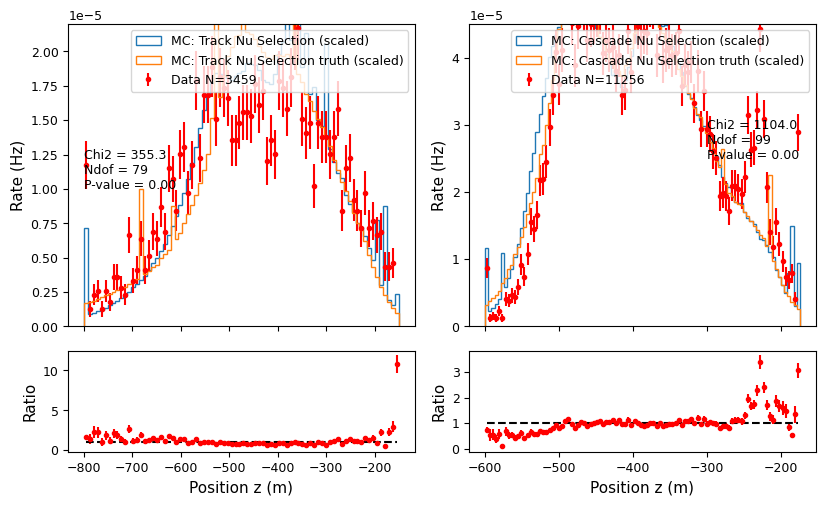

In [ ]:
figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.5
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex='col',height_ratios=[3, 1])

min_RD = np.min(RD['position_z_pred'][RD['event_no'].isin(pure_track_selection_RD)])
min_MC = np.min(MC['position_z_pred'][MC['event_no'].isin(pure_track_selection_MC)])
bins=np.linspace(-800,-150,81)
bins_middle = (bins[1:] + bins[:-1])/2
track_rates, _ = np.histogram(np.clip(RD['position_z_pred'][RD['event_no'].isin(pure_track_selection_RD)],-800,-150),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])
track_counts, _ = np.histogram(np.clip(RD['position_z_pred'][RD['event_no'].isin(pure_track_selection_RD)],-800,-150),density=False,bins=bins)
track_uncertainty,track_fractional_uncertainty = uncertainties_from_counts_rates(track_counts,track_rates)


track_rates_MC,_,_ = axs[0,0].hist(np.clip(MC['position_z_pred'][MC['event_no'].isin(pure_track_selection_MC)],-800,-150), histtype='step',density=False,label='MC: Track Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[0,0].errorbar(bins_middle,track_rates,yerr=track_uncertainty,fmt='.',label='Data N={}'.format(len(pure_track_selection_RD)),color='red')
track_ratio = track_rates/track_rates_MC
track_ratio_uncertainty = track_ratio*track_fractional_uncertainty
if with_MC_truth:
    axs[0,0].hist(MC['position_z'][MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=False,label='MC: Track Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)

axs[1,0].set_xlabel(r'Position z (m)')
axs[0,0].set_ylabel('Rate (Hz)')
axs[0,0].set_ylim(top=2.2*10**(-5))
axs[0,0].legend(loc='upper right')

axs[1,0].errorbar(bins_middle,track_ratio,yerr=track_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,0].set_ylabel('Ratio')

track_chi2,track_ndof,track_p_value = chi2_calculation(track_rates_MC,track_rates,track_uncertainty)
print(track_chi2,track_ndof,track_p_value)
axs[0,0].text(-800, 1*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(track_chi2,track_ndof,track_p_value),fontsize=9)
axs[1,0].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

min_RD = np.min(RD['position_z_pred'][RD['event_no'].isin(pure_cascade_selection_RD)])
min_MC = np.min(MC['position_z_pred'][MC['event_no'].isin(pure_cascade_selection_MC)])
bins=np.linspace(-600,-175,101)
bins_middle = (bins[1:] + bins[:-1])/2

cascade_rates, _ = np.histogram(np.clip(RD['position_z_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],-600,-175),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])
cascade_counts, _ = np.histogram(np.clip(RD['position_z_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],-600,-175),density=False,bins=bins)
cascade_uncertainty,cascade_fractional_uncertainty = uncertainties_from_counts_rates(cascade_counts,cascade_rates)



cascade_rates_MC,_,_ = axs[0,1].hist(np.clip(MC['position_z_pred'][MC['event_no'].isin(pure_cascade_selection_MC)],-600,-175), histtype='step',density=False,label='MC: Cascade Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)


cascade_ratio = cascade_rates/cascade_rates_MC
cascade_ratio_uncertainty = cascade_ratio*cascade_fractional_uncertainty
axs[0,1].errorbar(bins_middle,cascade_rates,yerr=cascade_uncertainty,fmt='.',label='Data N={}'.format(len(pure_cascade_selection_RD)),color='red')
axs[1,1].set_xlabel(r'Position z (m)')
axs[0,1].set_ylabel('Rate (Hz)')
axs[0,1].set_ylim(top=4.5*10**(-5))

axs[1,1].errorbar(bins_middle,cascade_ratio,yerr=cascade_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,1].set_ylabel('Ratio')
axs[1,1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')
if with_MC_truth:
    axs[0,1].hist(MC['position_z'][MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=False,label='MC: Cascade Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)
axs[0,1].legend(loc='upper right')
cascade_chi2,cascade_ndof,cascade_p_value = chi2_calculation(cascade_rates_MC,cascade_rates,cascade_uncertainty)
print(cascade_chi2,cascade_ndof,cascade_p_value)
axs[0,1].text(-300, 2.5*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(cascade_chi2,cascade_ndof,cascade_p_value),fontsize=9)
axs[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
axs[0,0].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
fig.tight_layout()
fig.savefig(outdir + 'position_z_track_cascade_rate_ratio.png',bbox_inches='tight',dpi=200)

In [ ]:
def calc_rho_36(x,y) :
    '''
    Radial distance from string 36 (approximately central within DeepCore)
    '''
    return np.sqrt( (x-46.29) ** 2 + (y+34.88) ** 2 )
MC['rho_pred'] = calc_rho_36(MC['position_x_pred'].values,MC['position_y_pred'].values)
MC['rho'] = calc_rho_36(MC['position_x'].values,MC['position_y'].values)
RD['rho_pred'] = calc_rho_36(RD['position_x_pred'].values,RD['position_y_pred'].values)

324.80577472757477 79 1.5169361210611607e-31
2064.56845533843 99 0.0


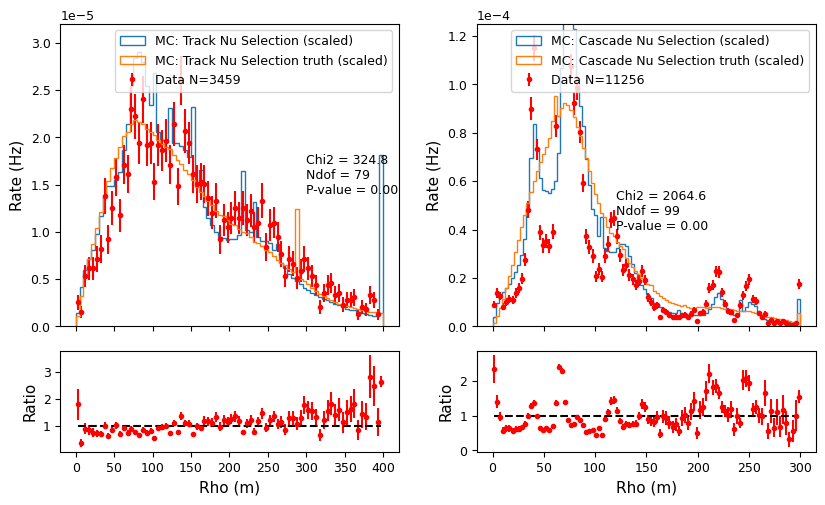

In [ ]:

figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.5
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex='col',height_ratios=[3, 1])

min_RD = np.min(RD['rho_pred'][RD['event_no'].isin(pure_track_selection_RD)])
min_MC = np.min(MC['rho_pred'][MC['event_no'].isin(pure_track_selection_MC)])
bins=np.linspace(0,400,81)
bins_middle = (bins[1:] + bins[:-1])/2
track_rates, _ = np.histogram(np.clip(RD['rho_pred'][RD['event_no'].isin(pure_track_selection_RD)],0,400),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])
track_counts, _ = np.histogram(np.clip(RD['rho_pred'][RD['event_no'].isin(pure_track_selection_RD)],0,400),density=False,bins=bins)
track_uncertainty,track_fractional_uncertainty = uncertainties_from_counts_rates(track_counts,track_rates)


track_rates_MC,_,_ = axs[0,0].hist(np.clip(MC['rho_pred'][MC['event_no'].isin(pure_track_selection_MC)],0,400), histtype='step',density=False,label='MC: Track Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[0,0].errorbar(bins_middle,track_rates,yerr=track_uncertainty,fmt='.',label='Data N={}'.format(len(pure_track_selection_RD)),color='red')
track_ratio = track_rates/track_rates_MC
track_ratio_uncertainty = track_ratio*track_fractional_uncertainty
if with_MC_truth:
    axs[0,0].hist(MC['rho'][MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=False,label='MC: Track Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)

axs[1,0].set_xlabel(r'Rho (m)')
axs[0,0].set_ylabel('Rate (Hz)')
axs[0,0].set_ylim(top=3.2*10**(-5))
axs[0,0].legend(loc='upper right')

axs[1,0].errorbar(bins_middle,track_ratio,yerr=track_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,0].set_ylabel('Ratio')

track_chi2,track_ndof,track_p_value = chi2_calculation(track_rates_MC,track_rates,track_uncertainty)
print(track_chi2,track_ndof,track_p_value)
axs[0,0].text(300, 1.4*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(track_chi2,track_ndof,track_p_value),fontsize=9)
axs[1,0].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

min_RD = np.min(RD['rho_pred'][RD['event_no'].isin(pure_cascade_selection_RD)])
min_MC = np.min(MC['rho_pred'][MC['event_no'].isin(pure_cascade_selection_MC)])
bins=np.linspace(0,300,101)
bins_middle = (bins[1:] + bins[:-1])/2

cascade_rates, _ = np.histogram(np.clip(RD['rho_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],-0,300),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])
cascade_counts, _ = np.histogram(np.clip(RD['rho_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],-0,300),density=False,bins=bins)
cascade_uncertainty,cascade_fractional_uncertainty = uncertainties_from_counts_rates(cascade_counts,cascade_rates)



cascade_rates_MC,_,_ = axs[0,1].hist(np.clip(MC['rho_pred'][MC['event_no'].isin(pure_cascade_selection_MC)],-0,300), histtype='step',density=False,label='MC: Cascade Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)


cascade_ratio = cascade_rates/cascade_rates_MC
cascade_ratio_uncertainty = cascade_ratio*cascade_fractional_uncertainty
axs[0,1].errorbar(bins_middle,cascade_rates,yerr=cascade_uncertainty,fmt='.',label='Data N={}'.format(len(pure_cascade_selection_RD)),color='red')
axs[1,1].set_xlabel(r'Rho (m)')
axs[0,1].set_ylabel('Rate (Hz)')
axs[0,1].set_ylim(top=1.25*10**(-4))

axs[1,1].errorbar(bins_middle,cascade_ratio,yerr=cascade_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,1].set_ylabel('Ratio')
axs[1,1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')
if with_MC_truth:
    axs[0,1].hist(MC['rho'][MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=False,label='MC: Cascade Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)
axs[0,1].legend(loc='upper right')
cascade_chi2,cascade_ndof,cascade_p_value = chi2_calculation(cascade_rates_MC,cascade_rates,cascade_uncertainty)
print(cascade_chi2,cascade_ndof,cascade_p_value)
axs[0,1].text(120, 0.4*10**(-4), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(cascade_chi2,cascade_ndof,cascade_p_value),fontsize=9)
axs[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
axs[0,0].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
fig.tight_layout()
fig.savefig(outdir + 'rho_track_cascade_rate_ratio.png',bbox_inches='tight',dpi=200)

48.16352020411513 29 0.01413408188653441
599.0156107136422 49 1.1376793087118725e-95


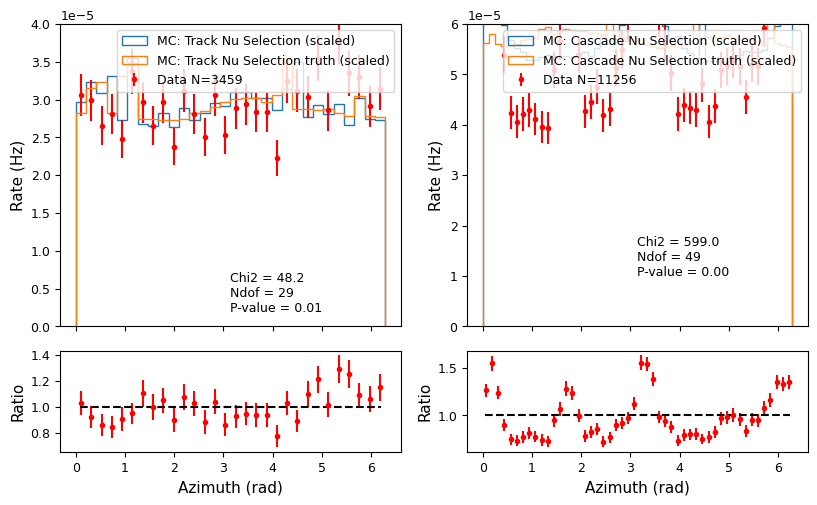

In [ ]:
figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.5
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[3, 1])

bins=np.linspace(0,np.pi*2,31)
bins_middle = (bins[1:] + bins[:-1])/2
track_rates, _ = np.histogram(RD['azimuth_pred'][RD['event_no'].isin(pure_track_selection_RD)],density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])
track_counts, _ = np.histogram(RD['azimuth_pred'][RD['event_no'].isin(pure_track_selection_RD)],density=False,bins=bins)
track_uncertainty,track_fractional_uncertainty = uncertainties_from_counts_rates(track_counts,track_rates)


track_rates_MC,_,_ = axs[0,0].hist(MC['azimuth_pred'][MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=False,label='MC: Track Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[0,0].errorbar(bins_middle,track_rates,yerr=track_uncertainty,fmt='.',label='Data N={}'.format(len(pure_track_selection_RD)),color='red')
track_ratio = track_rates/track_rates_MC
track_ratio_uncertainty = track_ratio*track_fractional_uncertainty

if with_MC_truth:
    axs[0,0].hist(MC['azimuth'][MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=False,label='MC: Track Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[1,0].set_xlabel('Azimuth (rad)')
axs[0,0].set_ylabel('Rate (Hz)')
axs[0,0].set_ylim(top=4*10**(-5))
axs[0,0].legend(loc='upper right')

axs[1,0].errorbar(bins_middle,track_ratio,yerr=track_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,0].set_ylabel('Ratio')

track_chi2,track_ndof,track_p_value = chi2_calculation(track_rates_MC,track_rates,track_uncertainty)
print(track_chi2,track_ndof,track_p_value)
axs[0,0].text(np.pi, 0.2*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(track_chi2,track_ndof,track_p_value),fontsize=9)
axs[1,0].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

bins=np.linspace(0,np.pi*2,51)
bins_middle = (bins[1:] + bins[:-1])/2

cascade_rates, _ = np.histogram(RD['azimuth_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])
cascade_counts, _ = np.histogram(RD['azimuth_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],density=False,bins=bins)
cascade_uncertainty,cascade_fractional_uncertainty = uncertainties_from_counts_rates(cascade_counts,cascade_rates)



cascade_rates_MC,_,_ = axs[0,1].hist(MC['azimuth_pred'][MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=False,label='MC: Cascade Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)


cascade_ratio = cascade_rates/cascade_rates_MC
cascade_ratio_uncertainty = cascade_ratio*cascade_fractional_uncertainty
axs[0,1].errorbar(bins_middle,cascade_rates,yerr=cascade_uncertainty,fmt='.',label='Data N={}'.format(len(pure_cascade_selection_RD)),color='red')
if with_MC_truth:
    axs[0,1].hist(MC['azimuth'][MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=False,label='MC: Cascade Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)
axs[1,1].set_xlabel('Azimuth (rad)')
axs[0,1].set_ylabel('Rate (Hz)')
axs[0,1].set_ylim(top=6*10**(-5))
axs[0,1].legend(loc='upper right')
axs[1,1].errorbar(bins_middle,cascade_ratio,yerr=cascade_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,1].set_ylabel('Ratio')
axs[1,1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

cascade_chi2,cascade_ndof,cascade_p_value = chi2_calculation(cascade_rates_MC,cascade_rates,cascade_uncertainty)
print(cascade_chi2,cascade_ndof,cascade_p_value)
axs[0,1].text(np.pi, 1*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(cascade_chi2,cascade_ndof,cascade_p_value),fontsize=9)

fig.tight_layout()
fig.savefig(outdir + 'azimuth_track_cascade_rate_ratio.png',bbox_inches='tight',dpi=200)

49.067201140926514 29 0.011360703227610463
3132.326815410327 29 0.0


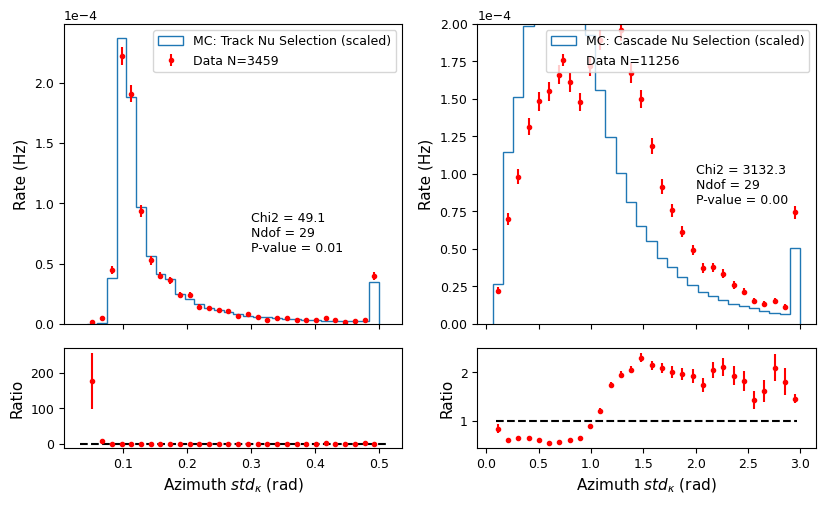

In [ ]:


figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.5
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex='col',height_ratios=[3, 1])

min_RD = np.min(1/np.sqrt(RD['azimuth_kappa'][RD['event_no'].isin(pure_track_selection_RD)]))
min_MC = np.min(1/np.sqrt(MC['azimuth_kappa'][MC['event_no'].isin(pure_track_selection_MC)]))
bins=np.linspace(np.min([min_RD,min_MC]),0.5,31)
bins_middle = (bins[1:] + bins[:-1])/2
track_rates, _ = np.histogram(np.clip(1/np.sqrt(RD['azimuth_kappa'][RD['event_no'].isin(pure_track_selection_RD)]),0,0.5),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])
track_counts, _ = np.histogram(np.clip(1/np.sqrt(RD['azimuth_kappa'][RD['event_no'].isin(pure_track_selection_RD)]),0,0.5),density=False,bins=bins)
track_uncertainty,track_fractional_uncertainty = uncertainties_from_counts_rates(track_counts,track_rates)


track_rates_MC,_,_ = axs[0,0].hist(np.clip(1/np.sqrt(MC['azimuth_kappa'][MC['event_no'].isin(pure_track_selection_MC)]),0,0.5), histtype='step',density=False,label='MC: Track Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[0,0].errorbar(bins_middle,track_rates,yerr=track_uncertainty,fmt='.',label='Data N={}'.format(len(pure_track_selection_RD)),color='red')
track_ratio = track_rates/track_rates_MC
track_ratio_uncertainty = track_ratio*track_fractional_uncertainty

axs[1,0].set_xlabel(r'Azimuth $std_{\kappa}$ (rad)')
axs[0,0].set_ylabel('Rate (Hz)')
#axs[0,0].set_ylim(top=4*10**(-5))
axs[0,0].legend(loc='upper right')

axs[1,0].errorbar(bins_middle,track_ratio,yerr=track_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,0].set_ylabel('Ratio')

track_chi2,track_ndof,track_p_value = chi2_calculation(track_rates_MC,track_rates,track_uncertainty)
print(track_chi2,track_ndof,track_p_value)
axs[0,0].text(0.3, 0.00006, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(track_chi2,track_ndof,track_p_value),fontsize=9)
axs[1,0].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

min_RD = np.min(1/np.sqrt(RD['azimuth_kappa'][RD['event_no'].isin(pure_cascade_selection_RD)]))
min_MC = np.min(1/np.sqrt(MC['azimuth_kappa'][MC['event_no'].isin(pure_cascade_selection_MC)]))
bins=np.linspace(np.min([min_RD,min_MC]),3,31)
bins_middle = (bins[1:] + bins[:-1])/2

cascade_rates, _ = np.histogram(np.clip(1/np.sqrt(RD['azimuth_kappa'][RD['event_no'].isin(pure_cascade_selection_RD)]),0,3),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])
cascade_counts, _ = np.histogram(np.clip(1/np.sqrt(RD['azimuth_kappa'][RD['event_no'].isin(pure_cascade_selection_RD)]),0,3),density=False,bins=bins)
cascade_uncertainty,cascade_fractional_uncertainty = uncertainties_from_counts_rates(cascade_counts,cascade_rates)



cascade_rates_MC,_,_ = axs[0,1].hist(np.clip(1/np.sqrt(MC['azimuth_kappa'][MC['event_no'].isin(pure_cascade_selection_MC)]),0,3), histtype='step',density=False,label='MC: Cascade Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)


cascade_ratio = cascade_rates/cascade_rates_MC
cascade_ratio_uncertainty = cascade_ratio*cascade_fractional_uncertainty
axs[0,1].errorbar(bins_middle,cascade_rates,yerr=cascade_uncertainty,fmt='.',label='Data N={}'.format(len(pure_cascade_selection_RD)),color='red')
axs[1,1].set_xlabel(r'Azimuth $std_{\kappa}$ (rad)')
axs[0,1].set_ylabel('Rate (Hz)')
axs[0,1].set_ylim(top=0.0002)
axs[0,1].legend(loc='upper right')
axs[1,1].errorbar(bins_middle,cascade_ratio,yerr=cascade_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,1].set_ylabel('Ratio')
axs[1,1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

cascade_chi2,cascade_ndof,cascade_p_value = chi2_calculation(cascade_rates_MC,cascade_rates,cascade_uncertainty)
print(cascade_chi2,cascade_ndof,cascade_p_value)
axs[0,1].text(2, 0.00008, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(cascade_chi2,cascade_ndof,cascade_p_value),fontsize=9)
axs[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
axs[0,0].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
fig.tight_layout()
fig.savefig(outdir + 'azimuth_kappa_track_cascade_rate_ratio.png',bbox_inches='tight',dpi=200)

498.23498821103556 28 1.5552395504284701e-87


/groups/icecube/peter/anaconda3/envs/graphnet/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


752.1782476047538 29 1.2171901048194043e-139


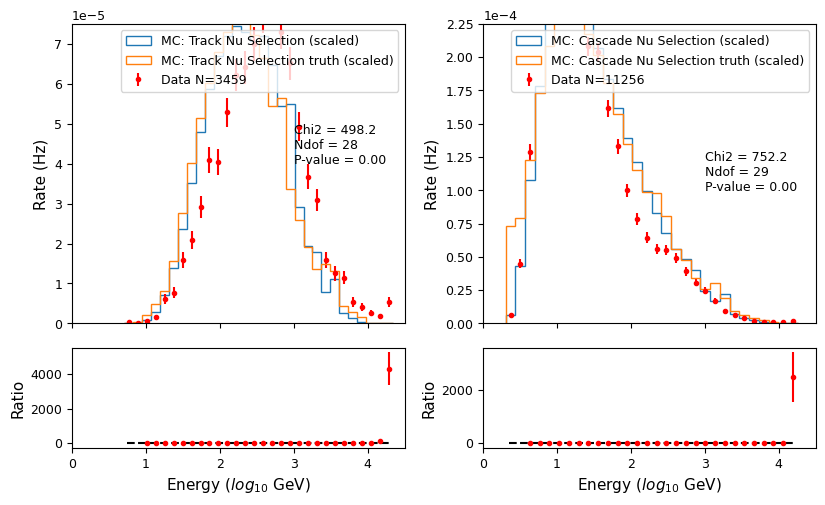

In [ ]:
figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.5
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[3, 1])

track_max_MC = np.max(np.log10(MC['energy_pred'][MC['event_no'].isin(pure_track_selection_MC)]))
track_max_RD = np.max(np.log10(RD['energy_pred'][RD['event_no'].isin(pure_track_selection_RD)]))
track_min_MC = np.min(np.log10(MC['energy_pred'][MC['event_no'].isin(pure_track_selection_MC)]))
track_min_RD = np.min(np.log10(RD['energy_pred'][RD['event_no'].isin(pure_track_selection_RD)]))
track_max = np.min([track_max_MC,track_max_RD])
track_min = np.max([track_min_MC,track_min_RD])
bins=np.linspace(track_min,track_max,31)
bins_middle = (bins[1:] + bins[:-1])/2
track_rates, _ = np.histogram(np.clip(np.log10(RD['energy_pred'][RD['event_no'].isin(pure_track_selection_RD)]),track_min,track_max),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])
track_counts, _ = np.histogram(np.clip(np.log10(RD['energy_pred'][RD['event_no'].isin(pure_track_selection_RD)]),track_min,track_max),density=False,bins=bins)
track_uncertainty,track_fractional_uncertainty = uncertainties_from_counts_rates(track_counts,track_rates)


track_rates_MC,_,_ = axs[0,0].hist(np.clip(np.log10(MC['energy_pred'][MC['event_no'].isin(pure_track_selection_MC)]),track_min,track_max), histtype='step',density=False,label='MC: Track Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[0,0].errorbar(bins_middle,track_rates,yerr=track_uncertainty,fmt='.',label='Data N={}'.format(len(pure_track_selection_RD)),color='red')
track_ratio = track_rates/track_rates_MC
track_ratio_uncertainty = track_ratio*track_fractional_uncertainty

if with_MC_truth:
    axs[0,0].hist(np.clip(np.log10(MC['energy'][MC['event_no'].isin(pure_track_selection_MC)]),track_min,track_max), histtype='step',density=False,label='MC: Track Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[1,0].set_xlabel(r'Energy ($log_{10}$ GeV)')
axs[0,0].set_ylabel('Rate (Hz)')
axs[0,0].set_ylim(top=7.5*10**(-5))
axs[0,0].set_xlim(0,4.5)
axs[0,0].legend(loc='upper right')

axs[1,0].errorbar(bins_middle[2:],track_ratio[2:],yerr=track_ratio_uncertainty[2:],label='Data / MC',fmt='.',color='red')
axs[1,0].set_ylabel('Ratio')

track_chi2,track_ndof,track_p_value = chi2_calculation(track_rates_MC,track_rates,track_uncertainty)
print(track_chi2,track_ndof,track_p_value)
axs[0,0].text(3, 4*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(track_chi2,track_ndof,track_p_value),fontsize=9)
axs[1,0].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

cascade_max_MC = np.max(np.log10(MC['energy_pred'][MC['event_no'].isin(pure_cascade_selection_MC)]))
cascade_max_RD = np.max(np.log10(RD['energy_pred'][RD['event_no'].isin(pure_cascade_selection_RD)]))
cascade_min_MC = np.min(np.log10(MC['energy_pred'][MC['event_no'].isin(pure_cascade_selection_MC)]))
cascade_min_RD = np.min(np.log10(RD['energy_pred'][RD['event_no'].isin(pure_cascade_selection_RD)]))
cascade_max = np.min([cascade_max_MC,cascade_max_RD])
cascade_min = np.max([cascade_min_MC,cascade_min_RD])
bins=np.linspace(cascade_min,cascade_max,31)
bins_middle = (bins[1:] + bins[:-1])/2

cascade_rates, _ = np.histogram(np.clip(np.log10(RD['energy_pred'][RD['event_no'].isin(pure_cascade_selection_RD)]),cascade_min,cascade_max),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])
cascade_counts, _ = np.histogram(np.clip(np.log10(RD['energy_pred'][RD['event_no'].isin(pure_cascade_selection_RD)]),cascade_min,cascade_max),density=False,bins=bins)
cascade_uncertainty,cascade_fractional_uncertainty = uncertainties_from_counts_rates(cascade_counts,cascade_rates)



cascade_rates_MC,_,_ = axs[0,1].hist(np.clip(np.log10(MC['energy_pred'][MC['event_no'].isin(pure_cascade_selection_MC)]),cascade_min,cascade_max), histtype='step',density=False,label='MC: Cascade Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)


cascade_ratio = cascade_rates/cascade_rates_MC
cascade_ratio_uncertainty = cascade_ratio*cascade_fractional_uncertainty
axs[0,1].errorbar(bins_middle,cascade_rates,yerr=cascade_uncertainty,fmt='.',label='Data N={}'.format(len(pure_cascade_selection_RD)),color='red')
if with_MC_truth:
    axs[0,1].hist(np.clip(np.log10(MC['energy'][MC['event_no'].isin(pure_cascade_selection_MC)]),cascade_min,cascade_max), histtype='step',density=False,label='MC: Cascade Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)
axs[1,1].set_xlabel(r'Energy ($log_{10}$ GeV)')
axs[0,1].set_ylabel('Rate (Hz)')
axs[0,1].set_ylim(top=0.000225)
axs[0,1].set_xlim(0,4.5)
axs[0,1].legend(loc='upper right')
axs[1,1].errorbar(bins_middle[2:],cascade_ratio[2:],yerr=cascade_ratio_uncertainty[2:],label='Data / MC',fmt='.',color='red')
axs[1,1].set_ylabel('Ratio')
axs[1,1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

cascade_chi2,cascade_ndof,cascade_p_value = chi2_calculation(cascade_rates_MC,cascade_rates,cascade_uncertainty)
print(cascade_chi2,cascade_ndof,cascade_p_value)
axs[0,1].text(3, 0.0001, 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(cascade_chi2,cascade_ndof,cascade_p_value),fontsize=9)
axs[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
axs[0,0].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
fig.tight_layout()
fig.savefig(outdir + 'energy_track_cascade_rate_ratio.png',bbox_inches='tight',dpi=200)

102.50339343814535 28 1.9817719210370145e-10
2133.45168525549 28 0.0


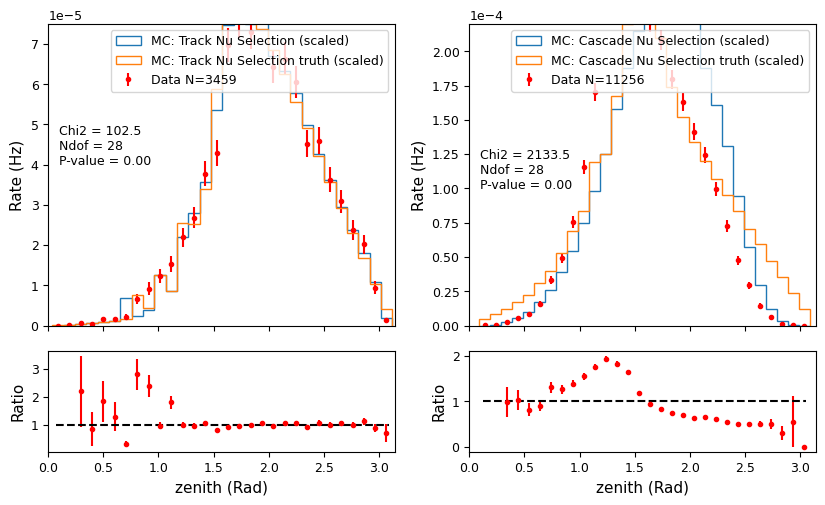

In [ ]:
figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.5
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[3, 1])

track_max_MC = np.max(MC['zenith_pred'][MC['event_no'].isin(pure_track_selection_MC)])
track_max_RD = np.max(RD['zenith_pred'][RD['event_no'].isin(pure_track_selection_RD)])
track_min_MC = np.min(MC['zenith_pred'][MC['event_no'].isin(pure_track_selection_MC)])
track_min_RD = np.min(RD['zenith_pred'][RD['event_no'].isin(pure_track_selection_RD)])
bins=np.linspace(np.min([track_min_MC,track_min_RD]),np.max([track_max_MC,track_max_RD]),31)
bins_middle = (bins[1:] + bins[:-1])/2
track_rates, _ = np.histogram(RD['zenith_pred'][RD['event_no'].isin(pure_track_selection_RD)],density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])
track_counts, _ = np.histogram(RD['zenith_pred'][RD['event_no'].isin(pure_track_selection_RD)],density=False,bins=bins)
track_uncertainty,track_fractional_uncertainty = uncertainties_from_counts_rates(track_counts,track_rates)


track_rates_MC,_,_ = axs[0,0].hist(MC['zenith_pred'][MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=False,label='MC: Track Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[0,0].errorbar(bins_middle,track_rates,yerr=track_uncertainty,fmt='.',label='Data N={}'.format(len(pure_track_selection_RD)),color='red')
track_ratio = track_rates/track_rates_MC
track_ratio_uncertainty = track_ratio*track_fractional_uncertainty

if with_MC_truth:
    axs[0,0].hist(MC['zenith'][MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=False,label='MC: Track Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[1,0].set_xlabel(r'zenith (Rad)')
axs[0,0].set_ylabel('Rate (Hz)')
axs[0,0].set_ylim(top=7.5*10**(-5))
axs[0,0].set_xlim(0,np.pi)
axs[0,0].legend(loc='upper right')

axs[1,0].errorbar(bins_middle[2:],track_ratio[2:],yerr=track_ratio_uncertainty[2:],label='Data / MC',fmt='.',color='red')
axs[1,0].set_ylabel('Ratio')

track_chi2,track_ndof,track_p_value = chi2_calculation(track_rates_MC,track_rates,track_uncertainty)
print(track_chi2,track_ndof,track_p_value)
axs[0,0].text(0.1,4*10**(-5), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(track_chi2,track_ndof,track_p_value),fontsize=9)
axs[1,0].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

cascade_max_MC = np.max(MC['zenith_pred'][MC['event_no'].isin(pure_cascade_selection_MC)])
cascade_max_RD = np.max(RD['zenith_pred'][RD['event_no'].isin(pure_cascade_selection_RD)])
cascade_min_MC = np.min(MC['zenith_pred'][MC['event_no'].isin(pure_cascade_selection_MC)])
cascade_min_RD = np.min(RD['zenith_pred'][RD['event_no'].isin(pure_cascade_selection_RD)])
bins=np.linspace(np.min([cascade_min_MC,cascade_min_RD]),np.max([cascade_max_MC,cascade_max_RD]),31)
bins_middle = (bins[1:] + bins[:-1])/2

cascade_rates, _ = np.histogram(RD['zenith_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])
cascade_counts, _ = np.histogram(RD['zenith_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],density=False,bins=bins)
cascade_uncertainty,cascade_fractional_uncertainty = uncertainties_from_counts_rates(cascade_counts,cascade_rates)



cascade_rates_MC,_,_ = axs[0,1].hist(MC['zenith_pred'][MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=False,label='MC: Cascade Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)


cascade_ratio = cascade_rates/cascade_rates_MC
cascade_ratio_uncertainty = cascade_ratio*cascade_fractional_uncertainty
axs[0,1].errorbar(bins_middle,cascade_rates,yerr=cascade_uncertainty,fmt='.',label='Data N={}'.format(len(pure_cascade_selection_RD)),color='red')
if with_MC_truth:
    axs[0,1].hist(MC['zenith'][MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=False,label='MC: Cascade Nu Selection truth (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)
axs[1,1].set_xlabel(r'zenith (Rad)')
axs[0,1].set_ylabel('Rate (Hz)')
axs[0,1].set_ylim(top=2.2*10**(-4))
axs[0,1].set_xlim(0,np.pi)
axs[0,1].legend(loc='upper right')
axs[1,1].errorbar(bins_middle[2:],cascade_ratio[2:],yerr=cascade_ratio_uncertainty[2:],label='Data / MC',fmt='.',color='red')
axs[1,1].set_ylabel('Ratio')
axs[1,1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

cascade_chi2,cascade_ndof,cascade_p_value = chi2_calculation(cascade_rates_MC,cascade_rates,cascade_uncertainty)
print(cascade_chi2,cascade_ndof,cascade_p_value)
axs[0,1].text(0.1,1*10**(-4), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(cascade_chi2,cascade_ndof,cascade_p_value),fontsize=9)
axs[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
axs[0,0].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
fig.tight_layout()
fig.savefig(outdir + 'zenith_track_cascade_rate_ratio.png',bbox_inches='tight',dpi=200)

/tmp/ipykernel_30239/4255418236.py:17: RuntimeWarning: divide by zero encountered in divide
  track_ratio = track_rates/track_rates_MC
/groups/icecube/peter/anaconda3/envs/graphnet/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


73.13667219288392 29 1.1154021245254557e-05
1443.0567600182967 28 1.0353926930334671e-286


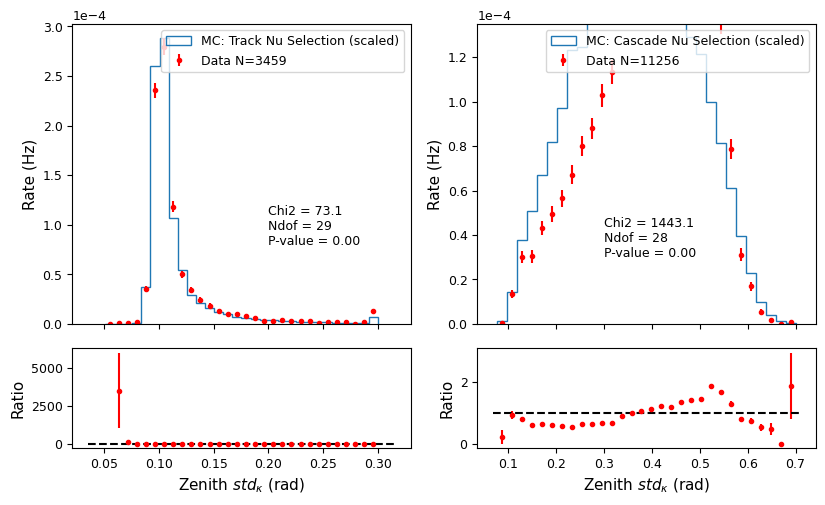

In [ ]:

figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.5
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex='col',height_ratios=[3, 1])

min_RD = np.min(1/np.sqrt(RD['zenith_kappa'][RD['event_no'].isin(pure_track_selection_RD)]))
min_MC = np.min(1/np.sqrt(MC['zenith_kappa'][MC['event_no'].isin(pure_track_selection_MC)]))
bins=np.linspace(np.min([min_RD,min_MC]),0.3,31)
bins_middle = (bins[1:] + bins[:-1])/2
track_rates, _ = np.histogram(np.clip(1/np.sqrt(RD['zenith_kappa'][RD['event_no'].isin(pure_track_selection_RD)]),0,0.3),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])
track_counts, _ = np.histogram(np.clip(1/np.sqrt(RD['zenith_kappa'][RD['event_no'].isin(pure_track_selection_RD)]),0,0.3),density=False,bins=bins)
track_uncertainty,track_fractional_uncertainty = uncertainties_from_counts_rates(track_counts,track_rates)


track_rates_MC,_,_ = axs[0,0].hist(np.clip(1/np.sqrt(MC['zenith_kappa'][MC['event_no'].isin(pure_track_selection_MC)]),0,0.3), histtype='step',density=False,label='MC: Track Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)]*scale_track)
axs[0,0].errorbar(bins_middle,track_rates,yerr=track_uncertainty,fmt='.',label='Data N={}'.format(len(pure_track_selection_RD)),color='red')
track_ratio = track_rates/track_rates_MC
track_ratio_uncertainty = track_ratio*track_fractional_uncertainty

axs[1,0].set_xlabel(r'Zenith $std_{\kappa}$ (rad)')
axs[0,0].set_ylabel('Rate (Hz)')
#axs[0,0].set_ylim(top=4*10**(-5))
axs[0,0].legend(loc='upper right')

axs[1,0].errorbar(bins_middle,track_ratio,yerr=track_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,0].set_ylabel('Ratio')

track_chi2,track_ndof,track_p_value = chi2_calculation(track_rates_MC,track_rates,track_uncertainty)
print(track_chi2,track_ndof,track_p_value)
axs[0,0].text(0.2, 0.8*10**(-4), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(track_chi2,track_ndof,track_p_value),fontsize=9)
axs[1,0].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

min_RD = np.min(1/np.sqrt(RD['zenith_kappa'][RD['event_no'].isin(pure_cascade_selection_RD)]))
min_MC = np.min(1/np.sqrt(MC['zenith_kappa'][MC['event_no'].isin(pure_cascade_selection_MC)]))
bins=np.linspace(np.min([min_RD,min_MC]),0.7,31)
bins_middle = (bins[1:] + bins[:-1])/2

cascade_rates, _ = np.histogram(np.clip(1/np.sqrt(RD['zenith_kappa'][RD['event_no'].isin(pure_cascade_selection_RD)]),0,0.7),density=False,bins=bins,weights=RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])
cascade_counts, _ = np.histogram(np.clip(1/np.sqrt(RD['zenith_kappa'][RD['event_no'].isin(pure_cascade_selection_RD)]),0,0.7),density=False,bins=bins)
cascade_uncertainty,cascade_fractional_uncertainty = uncertainties_from_counts_rates(cascade_counts,cascade_rates)



cascade_rates_MC,_,_ = axs[0,1].hist(np.clip(1/np.sqrt(MC['zenith_kappa'][MC['event_no'].isin(pure_cascade_selection_MC)]),0,0.7), histtype='step',density=False,label='MC: Cascade Nu Selection (scaled)',bins=bins,alpha=1,weights=MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)]*scale_cascade)


cascade_ratio = cascade_rates/cascade_rates_MC
cascade_ratio_uncertainty = cascade_ratio*cascade_fractional_uncertainty
axs[0,1].errorbar(bins_middle,cascade_rates,yerr=cascade_uncertainty,fmt='.',label='Data N={}'.format(len(pure_cascade_selection_RD)),color='red')
axs[1,1].set_xlabel(r'Zenith $std_{\kappa}$ (rad)')
axs[0,1].set_ylabel('Rate (Hz)')
axs[0,1].set_ylim(top=1.35*10**(-4))
axs[0,1].legend(loc='upper right')
axs[1,1].errorbar(bins_middle,cascade_ratio,yerr=cascade_ratio_uncertainty,label='Data / MC',fmt='.',color='red')
axs[1,1].set_ylabel('Ratio')
axs[1,1].hlines(1,np.min(bins_middle)-0.02,np.max(bins_middle)+0.02,color='k',linestyles='dashed')

cascade_chi2,cascade_ndof,cascade_p_value = chi2_calculation(cascade_rates_MC,cascade_rates,cascade_uncertainty)
print(cascade_chi2,cascade_ndof,cascade_p_value)
axs[0,1].text(0.3, 0.3*10**(-4), 'Chi2 = {:.1f}\nNdof = {}\nP-value = {:.2f}'.format(cascade_chi2,cascade_ndof,cascade_p_value),fontsize=9)
axs[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
axs[0,0].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
fig.tight_layout()
fig.savefig(outdir + 'zenith_kappa_track_cascade_rate_ratio.png',bbox_inches='tight',dpi=200)

In [ ]:
import math
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

In [ ]:
track_mean_energy_MC,_ = weighted_avg_and_std(MC['energy_pred'][MC['event_no'].isin(pure_track_selection_MC)],MC['total_osc_weight'][MC['event_no'].isin(pure_track_selection_MC)])
track_mean_energy_RD,_ = weighted_avg_and_std(RD['energy_pred'][RD['event_no'].isin(pure_track_selection_RD)],RD['total_osc_weight'][RD['event_no'].isin(pure_track_selection_RD)])
cascade_mean_energy_MC,_ = weighted_avg_and_std(MC['energy_pred'][MC['event_no'].isin(pure_cascade_selection_MC)],MC['total_osc_weight'][MC['event_no'].isin(pure_cascade_selection_MC)])
cascade_mean_energy_RD,_ = weighted_avg_and_std(RD['energy_pred'][RD['event_no'].isin(pure_cascade_selection_RD)],RD['total_osc_weight'][RD['event_no'].isin(pure_cascade_selection_RD)])

track_MC_energy_scale = track_mean_energy_RD/track_mean_energy_MC
cascade_MC_energy_scale = cascade_mean_energy_RD/cascade_mean_energy_MC

print(track_MC_energy_scale)
print(cascade_MC_energy_scale)

2.169852840841399
0.9606208208829852


In [ ]:
bins_azimuth = np.linspace(0,2*np.pi,17)
track_energy_per_azimuth_MC = []
track_energy_sigma_per_azimuth_MC = []
track_number_per_azimuth_MC = []
cascade_energy_per_azimuth_MC = []
cascade_energy_sigma_per_azimuth_MC = []
cascade_number_per_azimuth_MC = []
track_energy_per_azimuth_RD = []
track_energy_sigma_per_azimuth_RD = []
track_number_per_azimuth_RD = []
cascade_energy_per_azimuth_RD = []
cascade_energy_sigma_per_azimuth_RD = []
cascade_number_per_azimuth_RD = []
for i in range(len(bins_azimuth)-1):
    azi_min, azi_max = bins_azimuth[i],bins_azimuth[i+1]
    track_events_nos_for_energy_MC = MC['event_no'][(MC['azimuth_pred'] > azi_min) & (MC['azimuth_pred'] < azi_max) & (MC['event_no'].isin(pure_track_selection_MC))]
    cascade_events_nos_for_energy_MC = MC['event_no'][(MC['azimuth_pred'] > azi_min) & (MC['azimuth_pred'] < azi_max) & (MC['event_no'].isin(pure_cascade_selection_MC))]
    track_number_per_azimuth_MC.append(len(track_events_nos_for_energy_MC))
    cascade_number_per_azimuth_MC.append(len(cascade_events_nos_for_energy_MC))

    track_value_MC, track_std_MC = weighted_avg_and_std(values=MC['energy_pred'][MC['event_no'].isin(track_events_nos_for_energy_MC.to_list())], weights=MC['total_osc_weight'][MC['event_no'].isin(track_events_nos_for_energy_MC.to_list())])
    cascade_value_MC, cascade_std_MC = weighted_avg_and_std(values=MC['energy_pred'][MC['event_no'].isin(cascade_events_nos_for_energy_MC.to_list())], weights=MC['total_osc_weight'][MC['event_no'].isin(cascade_events_nos_for_energy_MC.to_list())])
    
    track_energy_per_azimuth_MC.append(track_value_MC)
    track_energy_sigma_per_azimuth_MC.append(track_std_MC/np.sqrt(len(track_events_nos_for_energy_MC)))
    cascade_energy_per_azimuth_MC.append(cascade_value_MC)
    cascade_energy_sigma_per_azimuth_MC.append(cascade_std_MC/np.sqrt(len(cascade_events_nos_for_energy_MC)))
    
    
    track_events_nos_for_energy_RD = RD['event_no'][(RD['azimuth_pred'] > azi_min) & (RD['azimuth_pred'] < azi_max) & (RD['event_no'].isin(pure_track_selection_RD))]
    cascade_events_nos_for_energy_RD = RD['event_no'][(RD['azimuth_pred'] > azi_min) & (RD['azimuth_pred'] < azi_max) & (RD['event_no'].isin(pure_cascade_selection_RD))]
    track_number_per_azimuth_RD.append(len(track_events_nos_for_energy_RD))
    cascade_number_per_azimuth_RD.append(len(cascade_events_nos_for_energy_RD))
    
    track_value_RD, track_std_RD = weighted_avg_and_std(values=RD['energy_pred'][RD['event_no'].isin(track_events_nos_for_energy_RD.to_list())], weights=RD['total_osc_weight'][RD['event_no'].isin(track_events_nos_for_energy_RD.to_list())])
    cascade_value_RD, cascade_std_RD = weighted_avg_and_std(values=RD['energy_pred'][RD['event_no'].isin(cascade_events_nos_for_energy_RD.to_list())], weights=RD['total_osc_weight'][RD['event_no'].isin(cascade_events_nos_for_energy_RD.to_list())])
    
    track_energy_per_azimuth_RD.append(track_value_RD)
    track_energy_sigma_per_azimuth_RD.append(track_std_RD/np.sqrt(len(track_events_nos_for_energy_RD)))
    cascade_energy_per_azimuth_RD.append(cascade_value_RD)
    cascade_energy_sigma_per_azimuth_RD.append(cascade_std_RD/np.sqrt(len(cascade_events_nos_for_energy_RD)))

In [ ]:
bins_zenith = np.linspace(0,np.pi,17)
track_energy_per_zenith_MC = []
track_energy_sigma_per_zenith_MC = []
track_number_per_zenith_MC = []
cascade_energy_per_zenith_MC = []
cascade_energy_sigma_per_zenith_MC = []
cascade_number_per_zenith_MC = []
track_energy_per_zenith_RD = []
track_energy_sigma_per_zenith_RD = []
track_number_per_zenith_RD = []
cascade_energy_per_zenith_RD = []
cascade_energy_sigma_per_zenith_RD = []
cascade_number_per_zenith_RD = []
for i in range(len(bins_zenith)-1):
    azi_min, azi_max = bins_zenith[i],bins_zenith[i+1]
    
    track_events_nos_for_energy_MC = MC['event_no'][(MC['zenith_pred'] > azi_min) & (MC['zenith_pred'] < azi_max) & (MC['event_no'].isin(pure_track_selection_MC))]
    cascade_events_nos_for_energy_MC = MC['event_no'][(MC['zenith_pred'] > azi_min) & (MC['zenith_pred'] < azi_max) & (MC['event_no'].isin(pure_cascade_selection_MC))]
    track_events_nos_for_energy_RD = RD['event_no'][(RD['zenith_pred'] > azi_min) & (RD['zenith_pred'] < azi_max) & (RD['event_no'].isin(pure_track_selection_RD))]
    cascade_events_nos_for_energy_RD = RD['event_no'][(RD['zenith_pred'] > azi_min) & (RD['zenith_pred'] < azi_max) & (RD['event_no'].isin(pure_cascade_selection_RD))]
    

    
    if len(track_events_nos_for_energy_MC)!=0 and len(track_events_nos_for_energy_RD)!=0: 
        track_value_MC, track_std_MC = weighted_avg_and_std(values=MC['energy_pred'][MC['event_no'].isin(track_events_nos_for_energy_MC.to_list())], weights=MC['total_osc_weight'][MC['event_no'].isin(track_events_nos_for_energy_MC.to_list())])
        track_value_RD, track_std_RD = weighted_avg_and_std(values=RD['energy_pred'][RD['event_no'].isin(track_events_nos_for_energy_RD.to_list())], weights=RD['total_osc_weight'][RD['event_no'].isin(track_events_nos_for_energy_RD.to_list())])
    
        track_number_per_zenith_MC.append(len(track_events_nos_for_energy_MC))
        track_energy_per_zenith_MC.append(track_value_MC)
        track_energy_sigma_per_zenith_MC.append(track_std_MC/np.sqrt(len(track_events_nos_for_energy_MC)))
        track_number_per_zenith_RD.append(len(track_events_nos_for_energy_RD))
        track_energy_per_zenith_RD.append(track_value_RD)
        track_energy_sigma_per_zenith_RD.append(track_std_RD/np.sqrt(len(track_events_nos_for_energy_RD)))

    else:
        track_number_per_zenith_MC.append(0)
        track_energy_per_zenith_MC.append(0)
        track_energy_sigma_per_zenith_MC.append(0)
        track_number_per_zenith_RD.append(0)
        track_energy_per_zenith_RD.append(0)
        track_energy_sigma_per_zenith_RD.append(0)

    if len(cascade_events_nos_for_energy_MC)!=0 and len(cascade_events_nos_for_energy_RD)!=0: 
        cascade_value_MC, cascade_std_MC = weighted_avg_and_std(values=MC['energy_pred'][MC['event_no'].isin(cascade_events_nos_for_energy_MC.to_list())], weights=MC['total_osc_weight'][MC['event_no'].isin(cascade_events_nos_for_energy_MC.to_list())])
        cascade_value_RD, cascade_std_RD = weighted_avg_and_std(values=RD['energy_pred'][RD['event_no'].isin(cascade_events_nos_for_energy_RD.to_list())], weights=RD['total_osc_weight'][RD['event_no'].isin(cascade_events_nos_for_energy_RD.to_list())])
    
        cascade_number_per_zenith_MC.append(len(cascade_events_nos_for_energy_MC))
        cascade_energy_per_zenith_MC.append(cascade_value_MC)
        cascade_energy_sigma_per_zenith_MC.append(cascade_std_MC/np.sqrt(len(cascade_events_nos_for_energy_MC)))
        cascade_number_per_zenith_RD.append(len(cascade_events_nos_for_energy_RD))
        cascade_energy_per_zenith_RD.append(cascade_value_RD)
        cascade_energy_sigma_per_zenith_RD.append(cascade_std_RD/np.sqrt(len(cascade_events_nos_for_energy_RD)))
    else:
        cascade_number_per_zenith_MC.append(0)
        cascade_energy_per_zenith_MC.append(0)
        cascade_energy_sigma_per_zenith_MC.append(0)
        cascade_number_per_zenith_RD.append(0)
        cascade_energy_per_zenith_RD.append(0)
        cascade_energy_sigma_per_zenith_RD.append(0)

In [ ]:
bins_position_z = np.linspace(-800,-150,36)
track_energy_per_position_z_MC = []
track_energy_sigma_per_position_z_MC = []
track_number_per_position_z_MC = []
cascade_energy_per_position_z_MC = []
cascade_energy_sigma_per_position_z_MC = []
cascade_number_per_position_z_MC = []
track_energy_per_position_z_RD = []
track_energy_sigma_per_position_z_RD = []
track_number_per_position_z_RD = []
cascade_energy_per_position_z_RD = []
cascade_energy_sigma_per_position_z_RD = []
cascade_number_per_position_z_RD = []
for i in range(len(bins_position_z)-1):
    azi_min, azi_max = bins_position_z[i],bins_position_z[i+1]
    
    track_events_nos_for_energy_MC = MC['event_no'][(MC['position_z_pred'] > azi_min) & (MC['position_z_pred'] < azi_max) & (MC['event_no'].isin(pure_track_selection_MC))]
    cascade_events_nos_for_energy_MC = MC['event_no'][(MC['position_z_pred'] > azi_min) & (MC['position_z_pred'] < azi_max) & (MC['event_no'].isin(pure_cascade_selection_MC))]
    track_events_nos_for_energy_RD = RD['event_no'][(RD['position_z_pred'] > azi_min) & (RD['position_z_pred'] < azi_max) & (RD['event_no'].isin(pure_track_selection_RD))]
    cascade_events_nos_for_energy_RD = RD['event_no'][(RD['position_z_pred'] > azi_min) & (RD['position_z_pred'] < azi_max) & (RD['event_no'].isin(pure_cascade_selection_RD))]
    

    
    if len(track_events_nos_for_energy_MC)!=0 and len(track_events_nos_for_energy_RD)!=0: 
        track_value_MC, track_std_MC = weighted_avg_and_std(values=MC['energy_pred'][MC['event_no'].isin(track_events_nos_for_energy_MC.to_list())], weights=MC['total_osc_weight'][MC['event_no'].isin(track_events_nos_for_energy_MC.to_list())])
        track_value_RD, track_std_RD = weighted_avg_and_std(values=RD['energy_pred'][RD['event_no'].isin(track_events_nos_for_energy_RD.to_list())], weights=RD['total_osc_weight'][RD['event_no'].isin(track_events_nos_for_energy_RD.to_list())])
    
        track_number_per_position_z_MC.append(len(track_events_nos_for_energy_MC))
        track_energy_per_position_z_MC.append(track_value_MC)
        track_energy_sigma_per_position_z_MC.append(track_std_MC/np.sqrt(len(track_events_nos_for_energy_MC)))
        track_number_per_position_z_RD.append(len(track_events_nos_for_energy_RD))
        track_energy_per_position_z_RD.append(track_value_RD)
        track_energy_sigma_per_position_z_RD.append(track_std_RD/np.sqrt(len(track_events_nos_for_energy_RD)))

    else:
        track_number_per_position_z_MC.append(0)
        track_energy_per_position_z_MC.append(0)
        track_energy_sigma_per_position_z_MC.append(0)
        track_number_per_position_z_RD.append(0)
        track_energy_per_position_z_RD.append(0)
        track_energy_sigma_per_position_z_RD.append(0)

    if len(cascade_events_nos_for_energy_MC)!=0 and len(cascade_events_nos_for_energy_RD)!=0: 
        cascade_value_MC, cascade_std_MC = weighted_avg_and_std(values=MC['energy_pred'][MC['event_no'].isin(cascade_events_nos_for_energy_MC.to_list())], weights=MC['total_osc_weight'][MC['event_no'].isin(cascade_events_nos_for_energy_MC.to_list())])
        cascade_value_RD, cascade_std_RD = weighted_avg_and_std(values=RD['energy_pred'][RD['event_no'].isin(cascade_events_nos_for_energy_RD.to_list())], weights=RD['total_osc_weight'][RD['event_no'].isin(cascade_events_nos_for_energy_RD.to_list())])
    
        cascade_number_per_position_z_MC.append(len(cascade_events_nos_for_energy_MC))
        cascade_energy_per_position_z_MC.append(cascade_value_MC)
        cascade_energy_sigma_per_position_z_MC.append(cascade_std_MC/np.sqrt(len(cascade_events_nos_for_energy_MC)))
        cascade_number_per_position_z_RD.append(len(cascade_events_nos_for_energy_RD))
        cascade_energy_per_position_z_RD.append(cascade_value_RD)
        cascade_energy_sigma_per_position_z_RD.append(cascade_std_RD/np.sqrt(len(cascade_events_nos_for_energy_RD)))
    else:
        cascade_number_per_position_z_MC.append(0)
        cascade_energy_per_position_z_MC.append(0)
        cascade_energy_sigma_per_position_z_MC.append(0)
        cascade_number_per_position_z_RD.append(0)
        cascade_energy_per_position_z_RD.append(0)
        cascade_energy_sigma_per_position_z_RD.append(0)

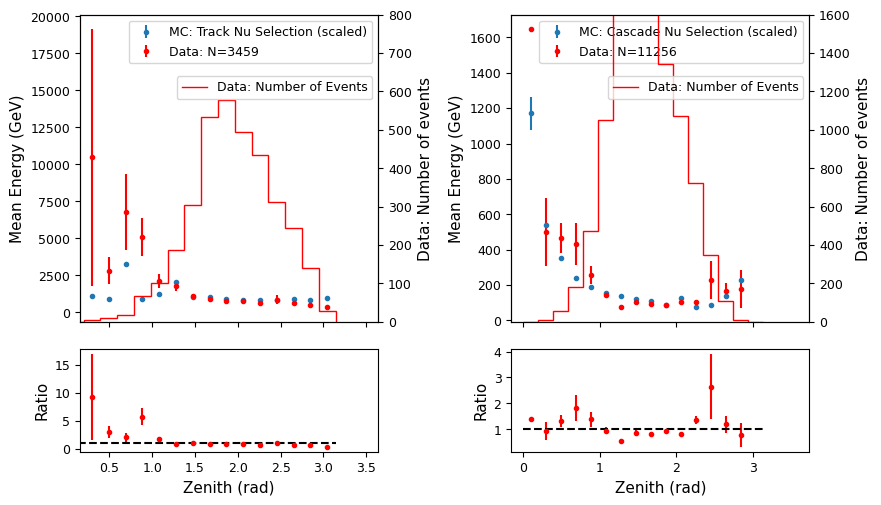

In [ ]:
track_mask = [True if track_energy_per_zenith_RD[i] !=0 else False for i in range(len(track_energy_per_zenith_RD))]
cascade_mask = [True if cascade_energy_per_zenith_RD[i] !=0 else False for i in range(len(cascade_energy_per_zenith_RD))]
track_energy_per_zenith_MC = np.array(track_energy_per_zenith_MC)
cascade_energy_per_zenith_MC = np.array(cascade_energy_per_zenith_MC)
cascade_energy_per_zenith_RD = np.array(cascade_energy_per_zenith_RD)
track_energy_per_zenith_RD = np.array(track_energy_per_zenith_RD)
track_energy_sigma_per_zenith_MC = np.array(track_energy_sigma_per_zenith_MC)
cascade_energy_sigma_per_zenith_MC = np.array(cascade_energy_sigma_per_zenith_MC)
cascade_energy_sigma_per_zenith_RD = np.array(cascade_energy_sigma_per_zenith_RD)
track_energy_sigma_per_zenith_RD = np.array(track_energy_sigma_per_zenith_RD)

bins_zenith_middle = (bins_zenith[1:]+bins_zenith[:-1])/2


figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.6
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex='col',height_ratios=[3, 1])


axs[0,0].errorbar(bins_zenith_middle[track_mask],track_energy_per_zenith_MC[track_mask]*track_MC_energy_scale,yerr=track_energy_sigma_per_zenith_MC[track_mask],fmt='.',label='MC: Track Nu Selection (scaled)')
axs[0,0].errorbar(bins_zenith_middle[track_mask],track_energy_per_zenith_RD[track_mask],yerr=track_energy_sigma_per_zenith_RD[track_mask],fmt='.',label='Data: N={}'.format(len(pure_track_selection_RD)),color='red')
axs[0,0].set_xlim(right=np.pi+0.5)
# ,yerr=np.log10(track_energy_sigma_per_zenith_MC[track_mask])
# ,yerr=np.log10(track_energy_sigma_per_zenith_RD[track_mask])
axs02 = axs[0,0].twinx()
axs02.stairs(np.array(track_number_per_zenith_RD),bins_zenith,label='Data: Number of Events',color='red')
axs02.set_ylabel('Data: Number of events')
axs02.set_ylim(top=800)
axs02.legend(bbox_to_anchor=(0.98, 0.8), loc='upper right', borderaxespad=0)

axs[0,0].set_ylabel(r'Mean Energy (GeV)')
axs[1,0].set_xlabel('Zenith (rad)')

axs[0,0].legend()

track_energy_ratio_per_zenith = track_energy_per_zenith_RD[track_mask]/(track_energy_per_zenith_MC[track_mask]*track_MC_energy_scale)
track_energy_ratio_sigma_per_zenith = track_energy_sigma_per_zenith_RD[track_mask]/(track_energy_per_zenith_RD[track_mask])*track_energy_ratio_per_zenith
axs[1,0].errorbar(bins_zenith_middle[track_mask],track_energy_ratio_per_zenith,yerr=track_energy_ratio_sigma_per_zenith,fmt='.',color='red')
axs[1,0].plot(np.linspace(0,np.pi,100),np.ones_like(np.linspace(0,np.pi,100)),linestyle='dashed',color='k')
axs[1,0].set_ylabel('Ratio')


axs[0,1].errorbar(bins_zenith_middle[cascade_mask],cascade_energy_per_zenith_MC[cascade_mask]*cascade_MC_energy_scale,yerr=cascade_energy_sigma_per_zenith_MC[cascade_mask],fmt='.',label='MC: Cascade Nu Selection (scaled)')
axs[0,1].errorbar(bins_zenith_middle[cascade_mask],cascade_energy_per_zenith_RD[cascade_mask],yerr=cascade_energy_sigma_per_zenith_RD[cascade_mask],fmt='.',label='Data: N={}'.format(len(pure_cascade_selection_RD)),color='red')
# ,yerr=np.log10(cascade_energy_sigma_per_zenith_MC[cascade_mask])
# ,yerr=np.log10(cascade_energy_sigma_per_zenith_RD[cascade_mask])
axs12 = axs[0,1].twinx()
axs12.stairs(np.array(cascade_number_per_zenith_RD),bins_zenith,label='Data: Number of Events',color='red')
axs12.set_ylabel('Data: Number of events')
axs12.set_ylim(top=1600)
axs12.legend(bbox_to_anchor=(0.98, 0.8), loc='upper right', borderaxespad=0)

axs[0,1].set_ylabel(r'Mean Energy (GeV)')
axs[1,1].set_xlabel('Zenith (rad)')
axs[0,1].legend(loc='upper right')

cascade_energy_ratio_per_zenith = cascade_energy_per_zenith_RD[cascade_mask]/(cascade_energy_per_zenith_MC[cascade_mask]*cascade_MC_energy_scale)
cascade_energy_ratio_sigma_per_zenith = cascade_energy_sigma_per_zenith_RD[cascade_mask]/(cascade_energy_per_zenith_RD[cascade_mask])*cascade_energy_ratio_per_zenith
axs[1,1].errorbar(bins_zenith_middle[cascade_mask],cascade_energy_ratio_per_zenith,yerr=cascade_energy_ratio_sigma_per_zenith,fmt='.',color='red')
axs[1,1].plot(np.linspace(0,np.pi,100),np.ones_like(np.linspace(0,np.pi,100)),linestyle='dashed',color='k')
axs[1,1].set_ylabel('Ratio')
axs[0,1].set_xlim(right=np.pi+0.6)



fig.tight_layout()
fig.savefig(outdir + 'Energy_as_func_of_zenith_track_cascade.png',bbox_inches='tight',dpi=200)

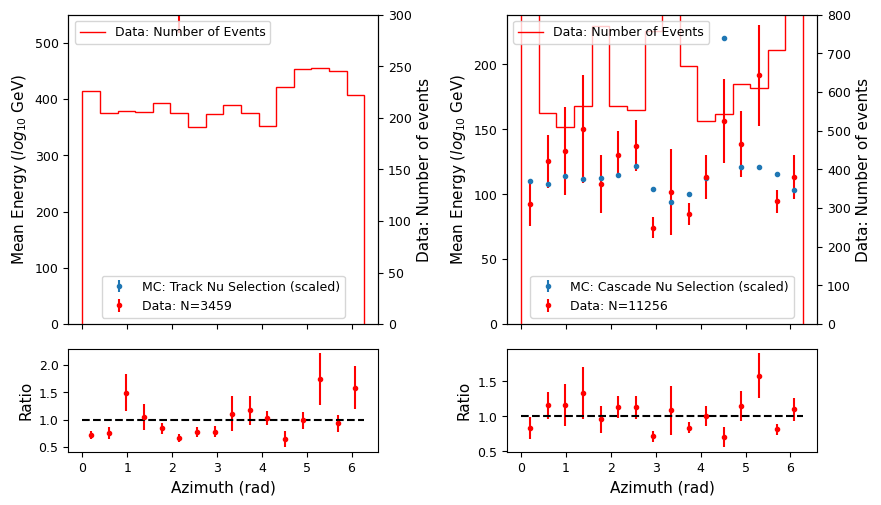

In [ ]:
bins_azimuth_middle = (bins_azimuth[1:]+bins_azimuth[:-1])/2
track_energy_per_azimuth_MC = np.array(track_energy_per_azimuth_MC)
cascade_energy_per_azimuth_MC = np.array(cascade_energy_per_azimuth_MC)
cascade_energy_per_azimuth_RD = np.array(cascade_energy_per_azimuth_RD)
track_energy_per_azimuth_RD = np.array(track_energy_per_azimuth_RD)
track_energy_sigma_per_azimuth_MC = np.array(track_energy_sigma_per_azimuth_MC)
cascade_energy_sigma_per_azimuth_MC = np.array(cascade_energy_sigma_per_azimuth_MC)
cascade_energy_sigma_per_azimuth_RD = np.array(cascade_energy_sigma_per_azimuth_RD)
track_energy_sigma_per_azimuth_RD = np.array(track_energy_sigma_per_azimuth_RD)

figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.6
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex='col',height_ratios=[3, 1])


#axs[0,0].stairs(track_energy_per_azimuth_MC),bins_azimuth,label='MC: Track Nu Selection (scaled)')
axs[0,0].errorbar(bins_azimuth_middle,np.array(track_energy_per_azimuth_MC)*track_MC_energy_scale,yerr=track_energy_sigma_per_azimuth_MC,fmt='.',label='MC: Track Nu Selection (scaled)'.format(len(pure_track_selection_RD)))
axs[0,0].errorbar(bins_azimuth_middle,track_energy_per_azimuth_RD,yerr=track_energy_sigma_per_azimuth_RD,fmt='.',label='Data: N={}'.format(len(pure_track_selection_RD)),color='red')
# ,yerr=track_energy_sigma_per_azimuth_MC)
# ,yerr=track_energy_sigma_per_azimuth_RD)
axs[0,0].set_ylabel(r'Mean Energy ($log_{10}$ GeV)')
axs[1,0].set_xlabel('Azimuth (rad)')
axs[0,0].set_ylim(top=550)
axs02 = axs[0,0].twinx()
axs02.stairs(np.array(track_number_per_azimuth_RD),bins_azimuth,label='Data: Number of Events',color='red')
axs02.set_ylabel('Data: Number of events')
axs02.set_ylim(top=300)
axs02.legend(loc='upper left')

axs[0,0].legend(loc='lower center')

track_energy_ratio_per_azimuth = track_energy_per_azimuth_RD/(np.array(track_energy_per_azimuth_MC)*track_MC_energy_scale)
track_energy_ratio_sigma_per_azimuth = track_energy_sigma_per_azimuth_RD/(track_energy_per_azimuth_RD)*track_energy_ratio_per_azimuth
axs[1,0].errorbar(bins_azimuth_middle,track_energy_ratio_per_azimuth,yerr=track_energy_ratio_sigma_per_azimuth,fmt='.',color='red')
axs[1,0].plot(np.linspace(0,2*np.pi,100),np.ones_like(np.linspace(0,2*np.pi,100)),linestyle='dashed',color='k')
axs[1,0].set_ylabel('Ratio')



axs[0,1].errorbar(bins_azimuth_middle,np.array(cascade_energy_per_azimuth_MC)*cascade_MC_energy_scale,yerr=cascade_energy_sigma_per_azimuth_MC,fmt='.',label='MC: Cascade Nu Selection (scaled)'.format(len(pure_cascade_selection_RD)))
axs[0,1].errorbar(bins_azimuth_middle,cascade_energy_per_azimuth_RD,yerr=cascade_energy_sigma_per_azimuth_RD,fmt='.',label='Data: N={}'.format(len(pure_cascade_selection_RD)),color='red')
# ,yerr=cascade_energy_sigma_per_azimuth_MC)
# ,yerr=cascade_energy_sigma_per_azimuth_RD)
axs12 = axs[0,1].twinx()
axs12.stairs(np.array(cascade_number_per_azimuth_RD),bins_azimuth,label='Data: Number of Events',color='red')
axs12.set_ylabel('Data: Number of events')
axs12.set_ylim(top=800)
axs12.legend(loc='upper left')

axs[0,1].set_ylabel(r'Mean Energy ($log_{10}$ GeV)')
axs[1,1].set_xlabel('Azimuth (rad)')
axs[0,1].legend(loc='lower center')
axs[0,1].set_ylim(0)
axs[0,0].set_ylim(0)

cascade_energy_ratio_per_azimuth = cascade_energy_per_azimuth_RD/(np.array(cascade_energy_per_azimuth_MC)*cascade_MC_energy_scale)
cascade_energy_ratio_sigma_per_azimuth = cascade_energy_sigma_per_azimuth_RD/(cascade_energy_per_azimuth_RD)*cascade_energy_ratio_per_azimuth
axs[1,1].errorbar(bins_azimuth_middle,cascade_energy_ratio_per_azimuth,yerr=cascade_energy_ratio_sigma_per_azimuth,fmt='.',color='red')
axs[1,1].plot(np.linspace(0,2*np.pi,100),np.ones_like(np.linspace(0,2*np.pi,100)),linestyle='dashed',color='k')
axs[1,1].set_ylabel('Ratio')

fig.tight_layout()
fig.savefig(outdir + 'Energy_as_func_of_azimuth_track_cascade.png',bbox_inches='tight',dpi=200)

/tmp/ipykernel_30239/4056472675.py:58: RuntimeWarning: invalid value encountered in divide
  cascade_energy_ratio_per_position_z = cascade_energy_per_position_z_RD/(np.array(cascade_energy_per_position_z_MC)*cascade_MC_energy_scale)
/tmp/ipykernel_30239/4056472675.py:59: RuntimeWarning: invalid value encountered in divide
  cascade_energy_ratio_sigma_per_position_z = cascade_energy_sigma_per_position_z_RD/(cascade_energy_per_position_z_RD)*cascade_energy_ratio_per_position_z


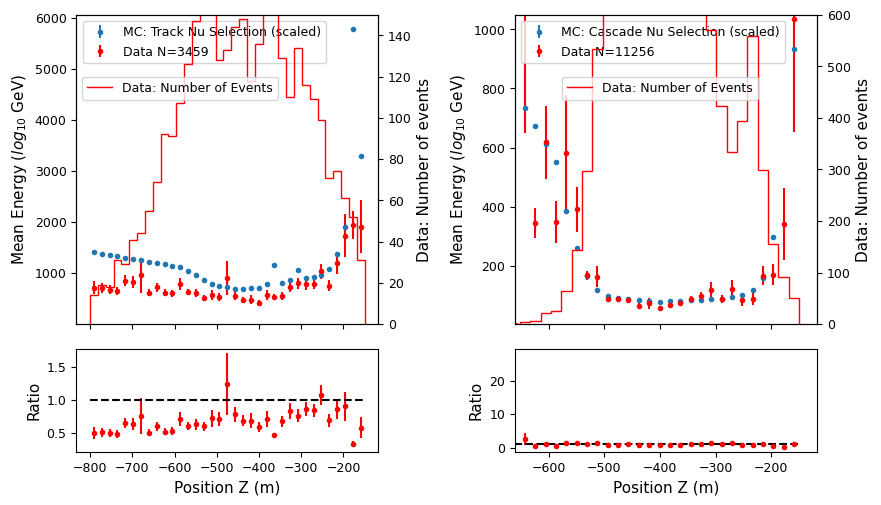

In [ ]:
bins_position_z_middle = (bins_position_z[1:]+bins_position_z[:-1])/2

track_energy_per_position_z_MC = np.array(track_energy_per_position_z_MC)
cascade_energy_per_position_z_MC = np.array(cascade_energy_per_position_z_MC)
cascade_energy_per_position_z_RD = np.array(cascade_energy_per_position_z_RD)
track_energy_per_position_z_RD = np.array(track_energy_per_position_z_RD)
track_energy_sigma_per_position_z_MC = np.array(track_energy_sigma_per_position_z_MC)
cascade_energy_sigma_per_position_z_MC = np.array(cascade_energy_sigma_per_position_z_MC)
cascade_energy_sigma_per_position_z_RD = np.array(cascade_energy_sigma_per_position_z_RD)
track_energy_sigma_per_position_z_RD = np.array(track_energy_sigma_per_position_z_RD)


figure_size = set_size('thesis',subplots = (2,2))
figure_size_yfrac = 1.5
figure_size_xfrac = 1.6
fig, axs = plt.subplots(2,2,figsize=(figure_size[0]*figure_size_xfrac,figure_size[1]*figure_size_yfrac),sharex='col',height_ratios=[3, 1])

#axs[0,0].stairs(track_energy_per_position_z_MC),bins_position_z,label='MC: Track Nu Selection (scaled)')
axs[0,0].errorbar(bins_position_z_middle,np.array(track_energy_per_position_z_MC)*track_MC_energy_scale,yerr=track_energy_sigma_per_position_z_MC,fmt='.',label='MC: Track Nu Selection (scaled)'.format(len(pure_track_selection_RD)))
axs[0,0].errorbar(bins_position_z_middle,track_energy_per_position_z_RD,yerr=track_energy_sigma_per_position_z_RD,fmt='.',label='Data N={}'.format(len(pure_track_selection_RD)),color='red')
# ,yerr=track_energy_sigma_per_position_z_MC)
# ,yerr=track_energy_sigma_per_position_z_RD)
axs02 = axs[0,0].twinx()
axs02.stairs(np.array(track_number_per_position_z_RD),bins_position_z,label='Data: Number of Events',color='red')
axs02.set_ylabel('Data: Number of events')
axs02.set_ylim(top=150)
axs02.legend(bbox_to_anchor=(0.02, 0.8), loc='upper left', borderaxespad=0)

axs[0,0].set_ylabel(r'Mean Energy ($log_{10}$ GeV)')
axs[1,0].set_xlabel('Position Z (m)')

axs[0,0].legend()

track_energy_ratio_per_position_z = track_energy_per_position_z_RD/(np.array(track_energy_per_position_z_MC)*track_MC_energy_scale)
track_energy_ratio_sigma_per_position_z = track_energy_sigma_per_position_z_RD/(track_energy_per_position_z_RD)*track_energy_ratio_per_position_z
axs[1,0].errorbar(bins_position_z_middle,track_energy_ratio_per_position_z,yerr=track_energy_ratio_sigma_per_position_z,fmt='.',color='red')
axs[1,0].plot(np.linspace(-800,-150,36),np.ones_like(np.linspace(-800,-150,36)),linestyle='dashed',color='k')
axs[1,0].set_ylabel('Ratio')

axs[0,1].errorbar(bins_position_z_middle,np.array(cascade_energy_per_position_z_MC)*cascade_MC_energy_scale,yerr=cascade_energy_sigma_per_position_z_MC,fmt='.',label='MC: Cascade Nu Selection (scaled)'.format(len(pure_cascade_selection_RD)))
axs[0,1].errorbar(bins_position_z_middle,cascade_energy_per_position_z_RD,yerr=cascade_energy_sigma_per_position_z_RD,fmt='.',label='Data N={}'.format(len(pure_cascade_selection_RD)),color='red')
# ,yerr=cascade_energy_sigma_per_position_z_MC)
# ,yerr=cascade_energy_sigma_per_position_z_RD)
axs12 = axs[0,1].twinx()
axs12.stairs(np.array(cascade_number_per_position_z_RD),bins_position_z,label='Data: Number of Events',color='red')
axs12.set_ylabel('Data: Number of events')
axs12.set_ylim(top=600)
axs12.legend(bbox_to_anchor=(0.48, 0.8), loc='upper center', borderaxespad=0)

axs[0,1].set_ylabel(r'Mean Energy ($log_{10}$ GeV)')
axs[1,1].set_xlabel('Position Z (m)')
axs[0,1].legend()
axs[0,1].set_ylim(1.5)
axs[0,0].set_ylim(2)
axs[0,1].set_xlim(left=-660)
axs12.set_xlim(left=-660)

cascade_energy_ratio_per_position_z = cascade_energy_per_position_z_RD/(np.array(cascade_energy_per_position_z_MC)*cascade_MC_energy_scale)
cascade_energy_ratio_sigma_per_position_z = cascade_energy_sigma_per_position_z_RD/(cascade_energy_per_position_z_RD)*cascade_energy_ratio_per_position_z
axs[1,1].errorbar(bins_position_z_middle,cascade_energy_ratio_per_position_z,yerr=cascade_energy_ratio_sigma_per_position_z,fmt='.',color='red')
axs[1,1].plot(np.linspace(-800,-150,36),np.ones_like(np.linspace(-800,-150,36)),linestyle='dashed',color='k')
axs[1,1].set_ylabel('Ratio')
axs[0,1].set_ylim(top=1050)


fig.tight_layout()
fig.savefig(outdir + 'Energy_as_func_of_position_z_track_cascade.png',bbox_inches='tight',dpi=200)